In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import os
for i in os.listdir("/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/"):
    print(str(len(os.listdir("/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/"+i))) +" "+ i +" audios")

632 Balbuties audios
632 Dysphonie audios
632 Frontolaterale-Teilresektion audios
632 Funktionelle-Dysphnie audios
632 Leukoplakie audios
632 Psychogene-Dysphonie audios
632 Reinke-Odem audios
632 Spasmodische-Dysphonie audios
632 Stimmlippenpolyp audios
632 Stimmlippenkarzinom audios
632 Vox-Senilis audios
632 Zentral-Laryngale-Bewegungsstorung audios


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import glob
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Dataset

In [ ]:
speechdata = "/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/"

In [ ]:
def get_features(signal, sample_rate, num_delta=5):
        mfcc = librosa.feature.mfcc(samples, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc_features= mfcc.T
        wav_features = np.empty(shape=[mfcc_features.shape[0], 0])
        delta_delta_features = librosa.feature.delta(mfcc_features, order=2)
        wav_features = np.append(wav_features, delta_delta_features, 1)
        wav_features = np.append(mfcc_features, wav_features, 1)
        return wav_features 

In [ ]:
!pip install spafe
!pip install pip install scikit-plot 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install EntropyHub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 4.9 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 115 kB 36.6 MB/s 


In [ ]:
import joblib
import scipy.signal as sg
import librosa.display
import IPython.display as ipd
from spafe.features.lpc import lpc, lpcc
#from hmmlearn import hmm
from spafe.features.rplp import rplp, plp
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from scipy import stats  # For in-built method to get PCC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from EntropyHub import SpecEn

plt.rcParams['figure.figsize'] = (10.0, 8.0)


class feature_calculation():
    def mfcc_feature(self, samples, sample_rate):
        mfcc = librosa.feature.mfcc(samples, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc_features= mfcc.T
        wav_features = np.empty(shape=[mfcc_features.shape[0], 0])
        delta_delta_features = librosa.feature.delta(mfcc_features, order=2)
        wav_features = np.append(wav_features, delta_delta_features, 1)
        wav_features = np.append(mfcc_features, wav_features, 1)
        return wav_features # it returns a np.array with size (40,'n') where n is the number of audio frames.

    def spectral_centroid_feature(self, audio, sample_rate):
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate, n_fft=2048)

        return spectral_centroid  # it returns a np.array with size (1,'n') where n is the number of audio frames.

    def spectral_rolloff_feature(self, audio, sample_rate):
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.95)

        return spectral_rolloff  # it returns a np.array with size (1,'n') where n is the number of audio frames.

    def zero_crossing_rate_features(self, audio, sample_rate):
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)

        return zero_crossing_rate # it returns a np.array with size (1,'n') where n is the number of audio frames.

    def pitch_feature(self, audio, sample_rate):
        pitches, magnitudes = librosa.core.piptrack(audio, sr=16000, fmin=75, fmax=1600)
        return pitches[:200,:]  # it returns a np.array with size (200,'n') where n is the number of audio frames.

    def onset_spectralflux_feature(self, y, sample_rate):  
        n_fft = 1024
        hop_length = int(librosa.time_to_samples(1./200, sr=sample_rate))
        lag = 2
        n_mels = 138
        fmin = 27.5
        fmax = 16000.
        max_size = 3  
        S = librosa.feature.melspectrogram(y, sr=sample_rate, n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
        odf_default = librosa.onset.onset_strength(y=y, sr=sample_rate, hop_length=hop_length)
        onset_default = librosa.onset.onset_detect(y=y, sr=sample_rate, hop_length=hop_length,
                                           units='time')

        odf_sf = librosa.onset.onset_strength(S=librosa.power_to_db(S, ref=np.max),
                                      sr=sample_rate,
                                      hop_length=hop_length,
                                      lag=lag, max_size=max_size)

        onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf,
                                      sr=sample_rate,
                                      hop_length=hop_length,
                                      units='time')
        return S, odf_default,onset_default,odf_sf ,onset_sf

    def spectral_entropy_feature(self, y, sample_rate):
        se = SpecEn(y, sample_rate)
        return se

    def RMS_feature(self, audio, sample_rate):
        rms = librosa.feature.rms(y=audio)

        return rms # it returns a np.array with size (1,'n') where n is the number of audio frames.


class feature_analysis_graphs():
    def sample_graph(self, samples, sample_rate):
        fig, ax = plt.subplots(figsize=(10, 10))
        librosa.display.waveplot(samples, sr=sample_rate)
        ax.label_outer()
        ax.set(title='Data Respresentation')
        plt.show()

    def MFCC_graph(self, samples):
        fig, ax = plt.subplots(figsize=(10, 10))
        img = librosa.display.specshow(samples, x_axis='time', ax=ax)
        ax.set(title='MFCC')
        ax.label_outer()
        plt.show()


    def zero_crossing_rate_graph(self, data):
        fig, ax = plt.subplots(figsize=(10, 10))
        times = librosa.times_like(data)
        ax.plot(times, data[0], label='zero crossing rate')
        ax.legend()
        ax.label_outer()
        plt.show()

    def root_mean_square_graph(self, data):
        fig, ax = plt.subplots(figsize=(10, 10))
        times = librosa.times_like(data)
        ax.semilogy(times, data[0], label='RMS Energy')
        ax.set(xticks=[])
        ax.legend()
        ax.label_outer()
        plt.show()

    def Spectral_Centroid_graph(self, data):
        fig, ax = plt.subplots(figsize=(10, 10))
        times = librosa.times_like(data)
        ax.plot(times, data.T, label='Spectral Centroid')
        ax.legend(loc='upper right')
        ax.set(title='log Power spectrogram')
        ax.label_outer()
        plt.show()


    def roll_off_frequency_graph(self, data):
        fig, ax = plt.subplots(figsize=(10, 10))
        times = librosa.times_like(data)
        ax.plot(times, data[0], label='roll-off frequency')
        ax.legend()
        ax.label_outer()
        plt.show()

    def pitch_graph(self, data):
        fig, ax = plt.subplots(figsize=(10, 10))
        img = librosa.display.specshow(data, x_axis='time', ax=ax)
        ax.set(title='Pitch')
        ax.label_outer()
        plt.show()

    def onset_spectralflux(self,S,sr, odf_default,onset_default,odf_sf ,onset_sf):
        n_fft = 1024
        hop_length = int(librosa.time_to_samples(1./200, sr=sr))
        lag = 2
        n_mels = 138
        fmin = 27.5
        fmax = 16000.
        max_size = 3 
    # sphinx_gallery_thumbnail_number = 2
        fig, ax =plt.figure(figsize=(6, 6))
        frame_time = librosa.frames_to_time(np.arange(len(odf_default)),
                                    sr=sr,
                                    hop_length=hop_length)
        ax = plt.subplot(2, 1, 2)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax)
        plt.xlim([0, 5.0])
        plt.axis('tight')
        plt.subplot(4, 1, 1, sharex=ax)
        plt.plot(frame_time, odf_default, label='Spectral flux')
        plt.vlines(onset_default, 0, odf_default.max(), label='Onsets')
        plt.xlim([0, 5.0])
        plt.legend()
        plt.subplot(4, 1, 2, sharex=ax)
        plt.plot(frame_time, odf_sf, color='g', label='Superflux')
        plt.vlines(onset_sf, 0, odf_sf.max(), label='Onsets')
        plt.xlim([0, 5.0])
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
# config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
# matplotlib inline
class Speech_Features_Extraction():
    def __init__(self, train_path="/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/", test_path="/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/",data_path="/content/drive/MyDrive/SpeechDisorderProject2/DataFile/",models_path="/content/drive/MyDrive/SpeechDisorderProject2/Model/"):
        self.Train = train_path
        self.Test = test_path
        self.models_path=models_path
        self.data_path=data_path

    def data_acquisition(self, filenames, sample_rate):
        # Data Acquisition
        sample, sample_rate = librosa.load(filenames, sr=sample_rate)
        return sample, sample_rate

    def speech_preprocessing(self, sample, sample_rate):
        """# **Emphasising** preEmphasis, smaller frequency to higher from y(t)=x(t)−αx(t−1"""
        pre_emphasis = 1
        emphasized_signal = np.append(sample[0], sample[1:] - pre_emphasis * sample[:-1])
        Time = np.linspace(0, len(emphasized_signal) / sample_rate, num=len(emphasized_signal))
        # Remove silence
        y = librosa.effects.split(emphasized_signal, top_db=30)
        l = []
        for i in y:
            l.append(emphasized_signal[i[0]:i[1]])
        emphasized_signal = np.concatenate(l, axis=0)
        Time = np.linspace(0, len(emphasized_signal) / sample_rate, num=len(emphasized_signal))
        b, a = sg.butter(4, 1000. / (sample_rate / 2.), 'high')
        emphasized_signal_fil = sg.filtfilt(b, a, emphasized_signal)
        # fig, ax = plt.subplots(1, 1, figsize=(6, 3))
        # ax.plot(Time, emphasized_signal, lw=1)
        # ax.plot(Time, emphasized_signal_fil, lw=1)
        return emphasized_signal_fil

    def feature_transformation_shaping(self,samples,MFCC, ZCR,SF,SE,PITCH,SC,SR,STE,max_len,i,Label,path):
        # padding and trimming
        pad_width = max_len - samples.shape[0]
        if pad_width > 0:
          samples = np.pad(samples, pad_width=((0, pad_width)), mode='constant')
        samples = samples[:max_len]
        pad_width = max_len - MFCC.shape[0]
        if pad_width > 0:
          MFCC = np.pad(MFCC, pad_width=((0, pad_width)), mode='constant')
        MFCC = MFCC[:max_len]
        pad_width = max_len - ZCR.shape[0]
        if pad_width > 0:
          ZCR = np.pad(ZCR, pad_width=((0, pad_width)), mode='constant')
        ZCR = ZCR[:max_len]
        pad_width = max_len - SF.shape[0]
        if pad_width > 0:
          SF = np.pad(SF, pad_width=((0, pad_width)), mode='constant')
        SF = SF[:max_len]
        pad_width = max_len - SE.shape[0]
        if pad_width > 0:
          SE = np.pad(SE, pad_width=((0, pad_width)), mode='constant')
        SE= SE[:max_len]
        pad_width = max_len - SE.shape[0]
        if pad_width > 0:
          SE = np.pad(SE, pad_width=((0, pad_width)), mode='constant')
        SE= SE[:max_len]
        pad_width = max_len - PITCH.shape[0]
        if pad_width > 0:
          PITCH = np.pad(PITCH, pad_width=((0, pad_width)), mode='constant')
        PITCH= PITCH[:max_len]
        pad_width = max_len - SC.shape[0]
        if pad_width > 0:
          SC = np.pad(SC, pad_width=((0, pad_width)), mode='constant')
        SC= SC[:max_len]
        pad_width = max_len - SR.shape[0]
        if pad_width > 0:
          SR = np.pad(SR, pad_width=((0, pad_width)), mode='constant')
        SR= SR[:max_len]
        pad_width = max_len - STE.shape[0]
        if pad_width > 0:
          STE = np.pad(STE, pad_width=((0, pad_width)), mode='constant')
        STE= STE[:max_len]
        Features_data = [samples,MFCC, ZCR,SF,SE,PITCH,SC,SR,STE, Label,path]
        return Features_data

    def Feature_extraction(self,no_of_classes):
        warnings.filterwarnings('ignore')
        features_cal = feature_calculation()  
      # setting the path where all file's folder are
        root = self.Train
        Features_data = pd.DataFrame(columns=['wave','MFCC', 'ZCR','SF','SE','PITCH','SC','SR','STE','Class','Path']) 
        all_wave = pd.DataFrame(columns=['features','class']) 
        all_label = []
        i = 0
        max_len = 40
        sample_rate = 16000 
        no_of_samples = 300
        MainFolder="/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/"
        labels=os.listdir(MainFolder)
        
        # Loading the features in the dataframe
        for label in labels[:no_of_classes]:
          print("Class Folder "+label)
          folders = os.path.join(root,label)
          items = os.listdir(folders)
          if no_of_samples == 0:
            no_of_samples= len(items)
          for item in items:
            #print("audio name"+item)
            path = os.path.join(folders,item)
            #Convert .wave into array
            samples, sample_rate=librosa.load(path ,sr=sample_rate)
            #Extract Feautures
            #samples=self.speech_preprocessing( samples, sample_rate)
            MFCC = features_cal.mfcc_feature(samples , sample_rate)
            ZCR = features_cal.zero_crossing_rate_features(samples , sample_rate)
            SF= np.asarray(features_cal.onset_spectralflux_feature(samples , sample_rate))
            SE= np.asarray(features_cal.spectral_entropy_feature(samples , sample_rate))
            PITCH= features_cal.pitch_feature(samples , sample_rate)
            SC= features_cal.spectral_centroid_feature(samples , sample_rate)
            SR= features_cal.spectral_rolloff_feature(samples , sample_rate)
            STE = features_cal.RMS_feature(samples , sample_rate)
            # flatten an array
            MFCC = MFCC.flatten()
            ZCR = ZCR.flatten()
            SF=SF.flatten()
            SE= SE.flatten()
            PITCH= PITCH.flatten()
            SC= SC.flatten()
            SR= SR. flatten()
            STE= STE.flatten()
            # normalizing
            # MFCC = normalize(MFCC)
            features = np.concatenate((list(MFCC), list(ZCR),list(SF,SE,PITCH,SC,SR,STE))
            #print(samples.shape,MFCC.shape, ZCR.shape,SF.shape,SE.shape,PITCH.shape,SC.shape,SR.shape,STE.shape)
            Features_data.loc[i] = [samples,MFCC, ZCR,SF,SE,PITCH,SC,SR,STE,label,path]
            i=i+1
        Features_data.to_csv(self.data_path+'All_Features_data.csv')
        return Features_data,features

In [ ]:
Speech_Features= Speech_Features_Extraction()
Features_data,features= Speech_Features.Feature_extraction(12)

Class Folder Balbuties
Class Folder Dysphonie
Class Folder Frontolaterale-Teilresektion
Class Folder Funktionelle-Dysphnie
Class Folder Psychogene-Dysphonie
Class Folder Reinke-Odem
Class Folder Spasmodische-Dysphonie
Class Folder Stimmlippenpolyp
Class Folder Stimmlippenkarzinom
Class Folder Vox-Senilis
Class Folder Zentral-Laryngale-Bewegungsstorung


In [ ]:
Features_datas=pd.read_csv('/content/drive/MyDrive/SpeechDisorderProject2/DataFile/All_Features_data.csv', sep = ",", decimal = '.', skiprows=[1])
Features_datas

Unnamed: 0                                               wave  \
0              1  [0.00333128 0.00615623 0.00566775 ... 0.003253...   
1              2  [-0.00103622 -0.0016067  -0.00136095 ...  0.00...   
2              3  [ 0.00519255  0.00860778  0.0075012  ... -0.00...   
3              4  [ 0.0002397   0.00045137  0.00035305 ... -0.00...   
4              5  [ 0.00080657  0.00157251  0.00122908 ... -0.00...   
...          ...                                                ...   
7578        7579  [ 0.00044557  0.0001927  -0.00072883 ... -0.00...   
7579        7580  [ 0.00140708  0.00290311  0.00306391 ... -0.08...   
7580        7581  [ 0.00038676  0.001232    0.00120535 ... -0.01...   
7581        7582  [-1.9645020e-04 -1.5761439e-03 -2.8261598e-04 ...   
7582        7583  [0.0134364  0.02303627 0.02025422 ... 0.006436...   

                                                   MFCC  \
0     [-4.49174561e+02  4.44927902e+01  3.20702667e+...   
1     [-430.04370117  166.09185791   44.5194931  ......   
2     [-540.96990967   63.30389023   26.87544632 ......   
3     [-5.08966553e+02  7.37049561e+01  2.86546021e+...   
4     [-527.33190918   95.88195801   32.58873749 ......   
...                                                 ...   
7578  [-496.07321167   83.0789566    41.81807709 ......   
7579  [-4.71186005e+02  7.04878845e+01  2.84660721e+...   
7580  [-471.11108398   81.54466248   19.45124435 ......   
7581  [-432.84765625   44.32592773   29.7905159  ......   
7582  [-485.51339722   81.01219177   39.11524963 ......   

                                                    ZCR  \
0     [0.01318359 0.0546875  0.06298828 0.0703125  0...   
1     [0.01025391 0.015625   0.02685547 0.02929688 0...   
2     [0.00292969 0.01757812 0.02441406 0.03369141 0...   
3     [0.01513672 0.03222656 0.04199219 0.04394531 0...   
4     [0.01269531 0.01904297 0.02685547 0.03173828 0...   
...                                                 ...   
7578  [0.02001953 0.02636719 0.03320312 0.03027344 0...   
7579  [0.01025391 0.01757812 0.03125    0.03564453 0...   
7580  [0.02685547 0.04443359 0.05615234 0.06347656 0...   
7581  [0.02880859 0.06005859 0.06933594 0.06738281 0...   
7582  [0.00585938 0.01416016 0.02148438 0.02636719 0...   

                                                     SF  \
0     [array([[3.4625243e-02, 3.2259434e-02, 2.63282...   
1     [array([[0.01717029, 0.0329475 , 0.0711671 , ....   
2     [array([[2.9945359e-02, 3.2362714e-02, 3.80940...   
3     [array([[2.5102688e-04, 3.1277252e-04, 4.51818...   
4     [array([[5.1970407e-04, 5.7116058e-04, 7.12223...   
...                                                 ...   
7578  [array([[0.00551271, 0.00552932, 0.00539961, ....   
7579  [array([[4.2743646e-02, 4.3591253e-02, 4.39087...   
7580  [array([[2.08261656e-03, 1.95318670e-03, 1.615...   
7581  [array([[2.3604142e-03, 3.4751501e-03, 6.44061...   
7582  [array([[0.01794694, 0.01768345, 0.0175344 , ....   

                           SE                    PITCH  \
0     [0.69706565 0.69706565]  [0. 0. 0. ... 0. 0. 0.]   
1     [0.74376315 0.74376315]  [0. 0. 0. ... 0. 0. 0.]   
2     [0.68450085 0.68450085]  [0. 0. 0. ... 0. 0. 0.]   
3     [0.70056485 0.70056485]  [0. 0. 0. ... 0. 0. 0.]   
4     [0.65534259 0.65534259]  [0. 0. 0. ... 0. 0. 0.]   
...                       ...                      ...   
7578  [0.66481242 0.66481242]  [0. 0. 0. ... 0. 0. 0.]   
7579  [0.64527868 0.64527868]  [0. 0. 0. ... 0. 0. 0.]   
7580  [0.65060645 0.65060645]  [0. 0. 0. ... 0. 0. 0.]   
7581  [0.56053269 0.56053269]  [0. 0. 0. ... 0. 0. 0.]   
7582    [0.6938478 0.6938478]  [0. 0. 0. ... 0. 0. 0.]   

                                                     SC  \
0     [1777.05692034 1570.63098453 1320.83265596  73...   
1     [ 400.06522226  403.73243022  589.37956     71...   
2     [ 784.14043083  801.10182389  512.73273839  43...   
3     [1287.35976124 1191.03329641  811.58560609  58...   
4     [1045.08562194  665.32340545

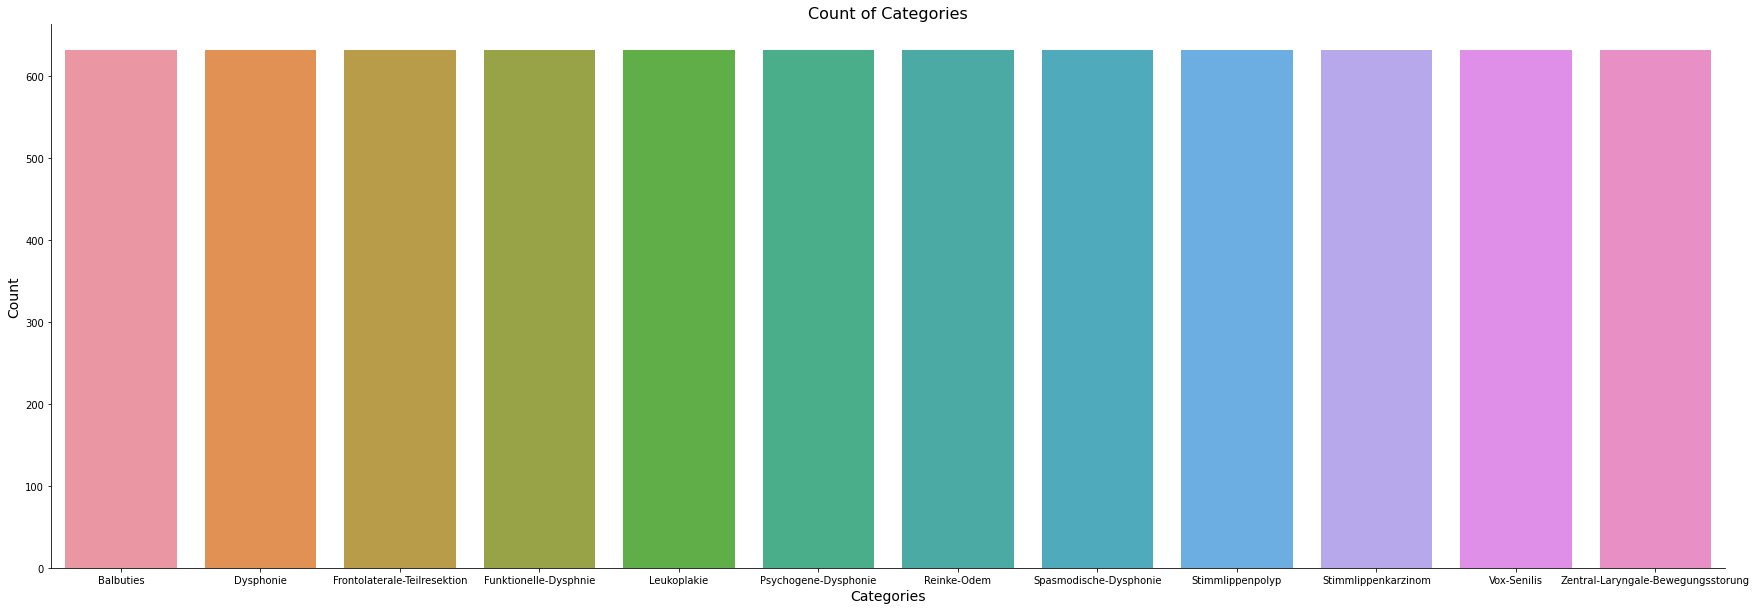

In [ ]:
plt.figure(figsize=(30, 10))
plt.title('Count of Categories', size=16)
sns.countplot(Features_data['Class'])
plt.ylabel('Count', size=14)
plt.xlabel('Categories', size=14)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualization

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} categories'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} categories'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

def graphs(data, sr, e):
  fig,ax = plt.subplots(3,4,sharex=True,sharey=False,figsize=(15,15));
  # time series
  ax[0,x].plot(np.linspace(0,5,len(data)),data)
  ax[0,x].set_title("Time Series: " + e)
  if x == 0:
    ax[0,x].set_ylabel("Amplitude")
  # spectrogram
    f, t, Zxx = stft(data,Fs)
  ax[1,x].pcolormesh(t,f,np.abs(Zxx))
  ax[1,x].set_title("Spectrogram: " + e)
  if x ==0: ax[1,x].set_ylabel("Frequency (Hz)")
        # mfccs
  mfccs = librosa.feature.mfcc(np.array(data),sr=Fs, n_mfcc=20, n_fft=1024, hop_length=256)
  mfccs_slice = mfccs[1:13,:]
  ax[2,x].pcolormesh(np.linspace(0,5,len(mfccs_slice[0])),range(1,len(mfccs_slice)+1,1),mfccs_slice)
  ax[2,x].set_title("MFCCs: " + e)
  ax[2,x].set_xlabel("Time (s)")
  if x ==0: ax[2,x].set_ylabel("Frequency Bin")
plt.show()
#plt.savefig('Sample Sounds.png', bbox_inches='tight')
# size of each 'image'
print ("Time Series size:",len(data))
print ("Spectrogram size:",len(Zxx),"by",len(Zxx[0]),"=",(len(Zxx) * len(Zxx[0])),"pixels")
print ("MFCC size:",len(mfccs_slice),"by",len(mfccs_slice[0]),"=",(len(mfccs_slice) * len(mfccs_slice[0])),"pixels")

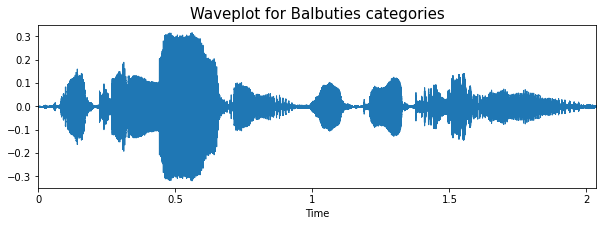

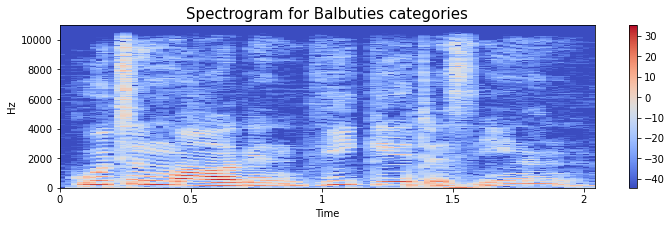

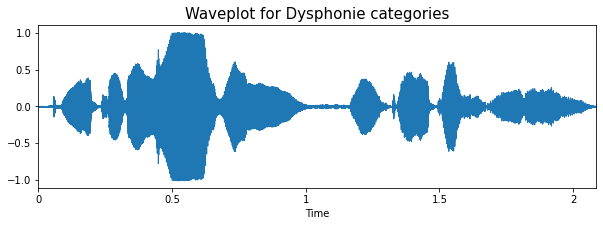

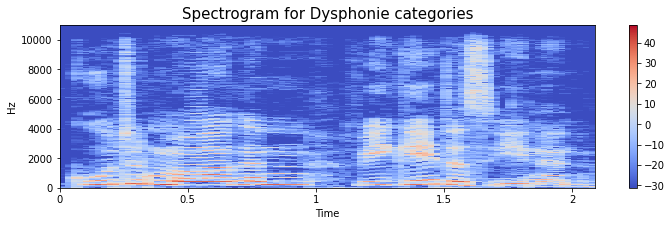

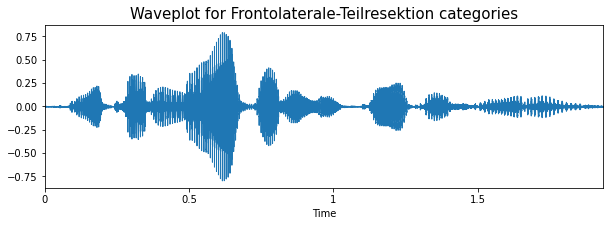

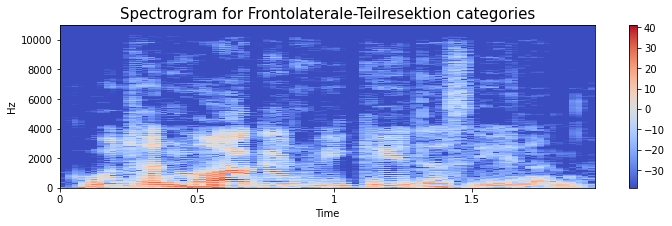

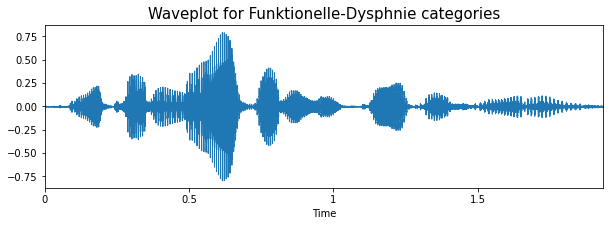

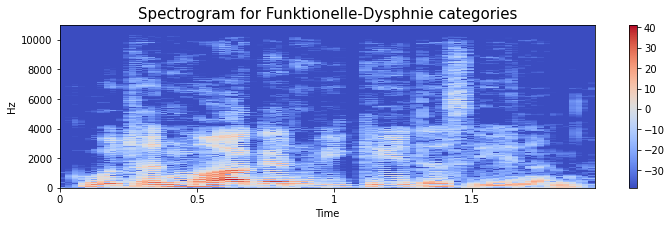

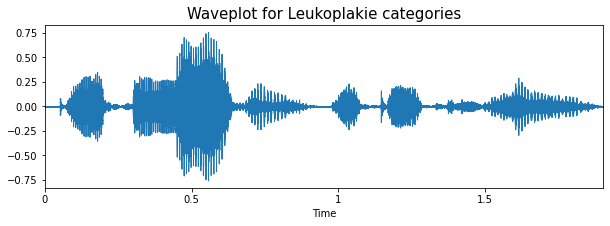

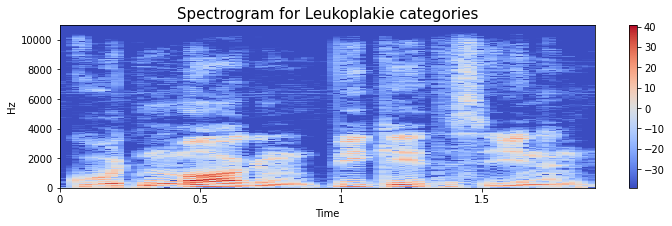

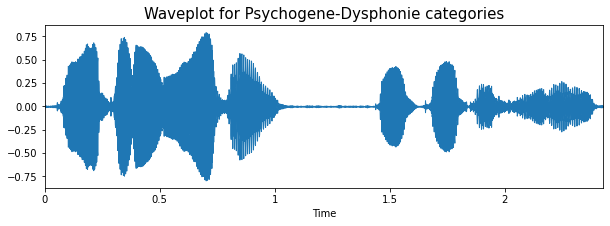

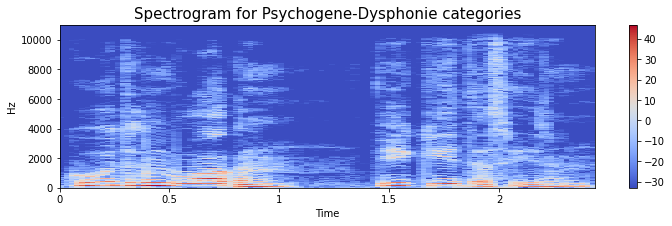

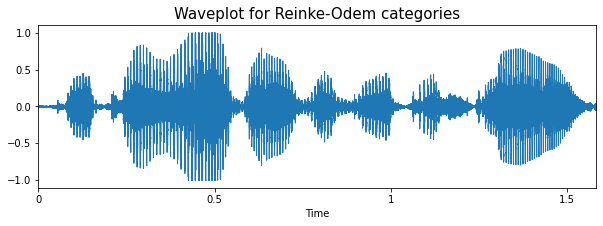

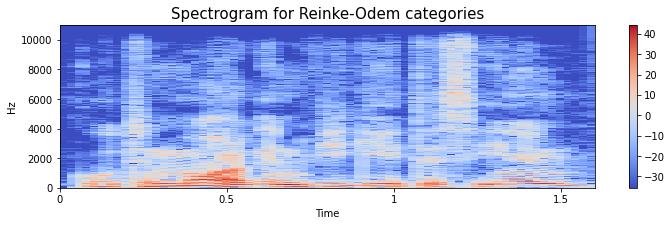

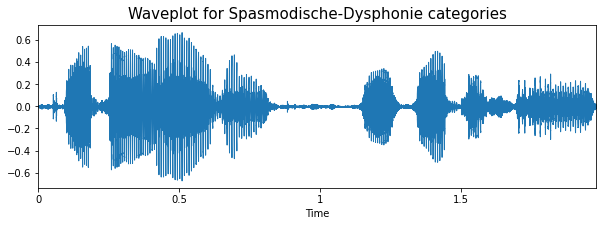

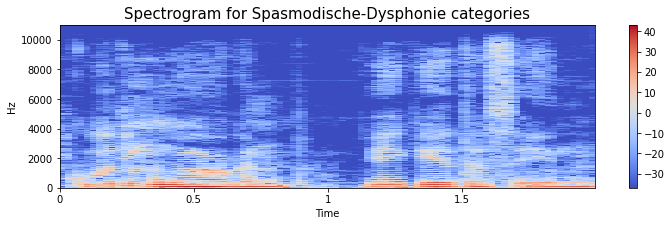

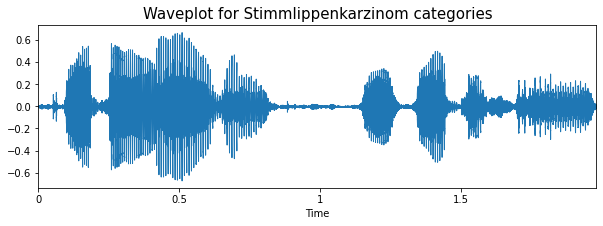

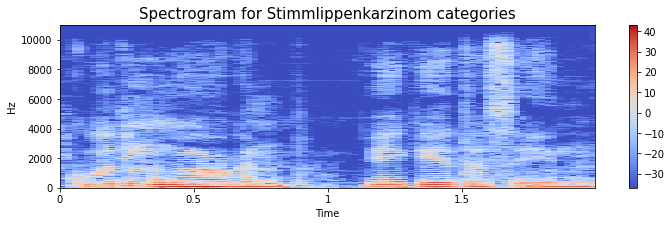

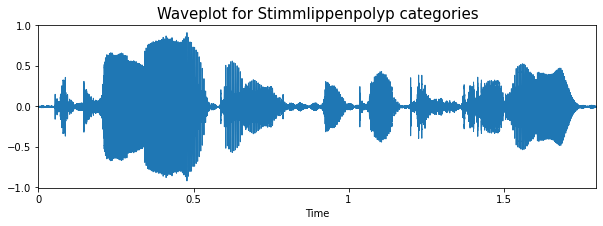

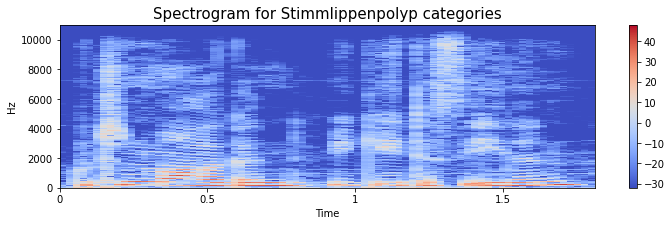

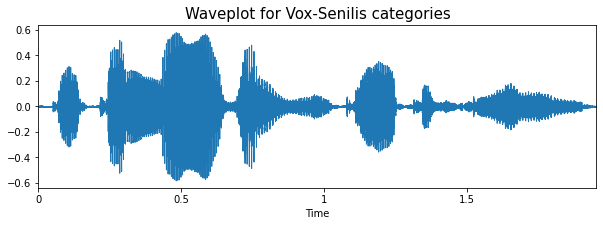

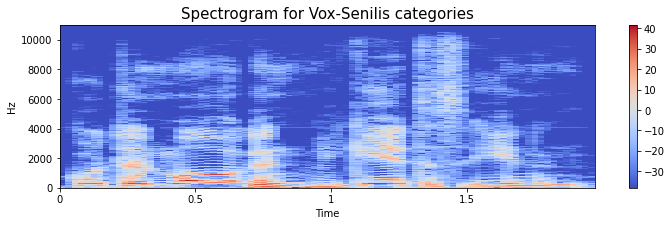

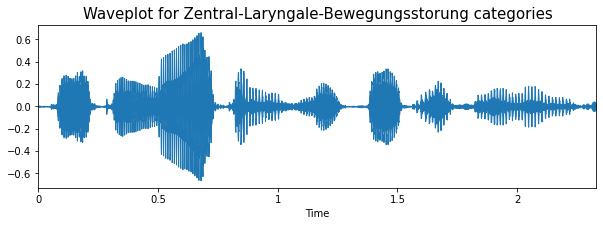

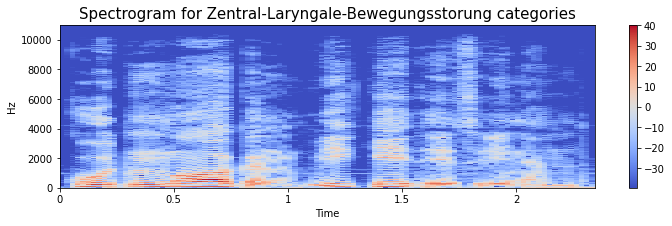

In [ ]:
Categories=np.unique(Features_data['Class'])
for Category in Categories:
  path = np.array(Features_data.Path[Features_data['Class']==Category])[0]
  data, sampling_rate = librosa.load(path)
  create_waveplot(data, sampling_rate, Category)
  create_spectrogram(data, sampling_rate, Category)
  Audio(path)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(Features_data['Class'])
classes= list(le.classes_)

# Padding 

In [ ]:
Features=Features_datas.drop(['wave','Class','Path'], axis=1)
a=Features.columns
Features=Features.drop([a[0]], axis=1)

In [ ]:
Features

MFCC  \
0     [-4.49174561e+02  4.44927902e+01  3.20702667e+...   
1     [-430.04370117  166.09185791   44.5194931  ......   
2     [-540.96990967   63.30389023   26.87544632 ......   
3     [-5.08966553e+02  7.37049561e+01  2.86546021e+...   
4     [-527.33190918   95.88195801   32.58873749 ......   
...                                                 ...   
7578  [-496.07321167   83.0789566    41.81807709 ......   
7579  [-4.71186005e+02  7.04878845e+01  2.84660721e+...   
7580  [-471.11108398   81.54466248   19.45124435 ......   
7581  [-432.84765625   44.32592773   29.7905159  ......   
7582  [-485.51339722   81.01219177   39.11524963 ......   

                                                    ZCR  \
0     [0.01318359 0.0546875  0.06298828 0.0703125  0...   
1     [0.01025391 0.015625   0.02685547 0.02929688 0...   
2     [0.00292969 0.01757812 0.02441406 0.03369141 0...   
3     [0.01513672 0.03222656 0.04199219 0.04394531 0...   
4     [0.01269531 0.01904297 0.02685547 0.03173828 0...   
...                                                 ...   
7578  [0.02001953 0.02636719 0.03320312 0.03027344 0...   
7579  [0.01025391 0.01757812 0.03125    0.03564453 0...   
7580  [0.02685547 0.04443359 0.05615234 0.06347656 0...   
7581  [0.02880859 0.06005859 0.06933594 0.06738281 0...   
7582  [0.00585938 0.01416016 0.02148438 0.02636719 0...   

                                                     SF  \
0     [array([[3.4625243e-02, 3.2259434e-02, 2.63282...   
1     [array([[0.01717029, 0.0329475 , 0.0711671 , ....   
2     [array([[2.9945359e-02, 3.2362714e-02, 3.80940...   
3     [array([[2.5102688e-04, 3.1277252e-04, 4.51818...   
4     [array([[5.1970407e-04, 5.7116058e-04, 7.12223...   
...                                                 ...   
7578  [array([[0.00551271, 0.00552932, 0.00539961, ....   
7579  [array([[4.2743646e-02, 4.3591253e-02, 4.39087...   
7580  [array([[2.08261656e-03, 1.95318670e-03, 1.615...   
7581  [array([[2.3604142e-03, 3.4751501e-03, 6.44061...   
7582  [array([[0.01794694, 0.01768345, 0.0175344 , ....   

                           SE                    PITCH  \
0     [0.69706565 0.69706565]  [0. 0. 0. ... 0. 0. 0.]   
1     [0.74376315 0.74376315]  [0. 0. 0. ... 0. 0. 0.]   
2     [0.68450085 0.68450085]  [0. 0. 0. ... 0. 0. 0.]   
3     [0.70056485 0.70056485]  [0. 0. 0. ... 0. 0. 0.]   
4     [0.65534259 0.65534259]  [0. 0. 0. ... 0. 0. 0.]   
...                       ...                      ...   
7578  [0.66481242 0.66481242]  [0. 0. 0. ... 0. 0. 0.]   
7579  [0.64527868 0.64527868]  [0. 0. 0. ... 0. 0. 0.]   
7580  [0.65060645 0.65060645]  [0. 0. 0. ... 0. 0. 0.]   
7581  [0.56053269 0.56053269]  [0. 0. 0. ... 0. 0. 0.]   
7582    [0.6938478 0.6938478]  [0. 0. 0. ... 0. 0. 0.]   

                                                     SC  \
0     [1777.05692034 1570.63098453 1320.83265596  73...   
1     [ 400.06522226  403.73243022  589.37956     71...   
2     [ 784.14043083  801.10182389  512.73273839  43...   
3     [1287.35976124 1191.03329641  811.58560609  58...   
4     [1045.08562194  665.32340545  555.40593672  64...   
...                                                 ...   
7578  [1383.72750356  650.7421181   423.59009888  46...   
7579  [ 952.0618853   806.54822423  862.97609141  87...   
7580  [1219.15137744 1071.55576571  785.20834439  60...   
7581  [2363.13314662 2315.53790548 1356.15241826  74...   
7582  [ 846.19388754  779.78951557  441.22867421  42...   

                                                     SR  \
0     [6750.     6500.     6406.25   3101.5625 2054....   
1     [2093.75   2132.8125 2718.75   3281.25   2875....   
2     [5937.5    4210.9375 1125.      921.875  1015....   
3     [5828.125  5937.5    4289.0625 1578.125  2750....   
4     [5242.1875 2671.875  2117.1875 2437.5    3140....   
...                                                 ...   
7578  [5367.1875 3476.5625  890.625  1109.375  2046....   
7579  [5726.5625 4273.4375 4078.125  4242.1875

In [ ]:
Features.dtypes

MFCC     object
ZCR      object
SF       object
SE       object
PITCH    object
SC       object
SR       object
STE      object
dtype: object

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import stft
import librosa
import time
import glob
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFdr, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neighbors import NearestCentroid,KNeighborsClassifier
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth, AffinityPropagation, SpectralClustering
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neural_network import BernoulliRBM
import os

In [ ]:
speechdata = "/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/"

In [ ]:
start = time.time()
speech_directory_list = "/content/drive/MyDrive/SpeechDisorderProject2/Dataset/All/"
labels=os.listdir(speechdata)
file_category= []
file_path = []

all_mfccs=[]
all_wave = []
mfcc_means=[]
mfcc_stds=[]
sample_rate = 16000
for label in labels:
  print(label)
  SubFolder = speechdata+"/"+ label + "/"
  # print(SubFolder)
  for filename in glob.glob(os.path.join(SubFolder, '*.wav')):
    samples, sample_rate = librosa.load(filename, sr = 16000)
    mfcc_temp = librosa.feature.mfcc(samples, sample_rate, n_mfcc=20, n_fft=1024, hop_length=256)
    mfccs_slice = mfcc_temp[1:13,:] # only use coefficients 1 to 12 as per speech
    #get mfcc mean and std
    mfcc_means.append(list(np.mean(mfccs_slice,axis=0)))
    mfcc_stds.append(list(np.std(mfccs_slice,axis=0)))
    all_mfccs.append(list(mfccs_slice))
    file_category.append(label)
    file_path.append(filename)
        
# dataframe for emotion of files
categories_df = pd.DataFrame(file_category, columns=['Category'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
speech_df = pd.concat([categories_df, path_df], axis=1)
speech_df.head()

Balbuties
Dysphonie
Frontolaterale-Teilresektion
Funktionelle-Dysphnie
Leukoplakie
Psychogene-Dysphonie
Reinke-Odem
Spasmodische-Dysphonie
Stimmlippenpolyp
Stimmlippenkarzinom
Vox-Senilis
Zentral-Laryngale-Bewegungsstorung


Category                                               Path
0  Balbuties  /content/drive/MyDrive/SpeechDisorderProject2/...
1  Balbuties  /content/drive/MyDrive/SpeechDisorderProject2/...
2  Balbuties  /content/drive/MyDrive/SpeechDisorderProject2/...
3  Balbuties  /content/drive/MyDrive/SpeechDisorderProject2/...
4  Balbuties  /content/drive/MyDrive/SpeechDisorderProject2/...

In [ ]:
len(mfcc_means[0])

129

In [ ]:
mfcc_stds

[[13.676458,
  14.102414,
  30.199087,
  42.0212,
  47.349434,
  51.046715,
  50.480415,
  45.86013,
  39.539837,
  33.18415,
  23.551256,
  20.808325,
  25.683735,
  26.217402,
  27.430372,
  34.184475,
  39.362247,
  38.28402,
  34.46582,
  36.301476,
  35.683758,
  35.81642,
  37.257633,
  36.57927,
  44.56198,
  48.62382,
  45.924835,
  43.781815,
  43.62058,
  42.324368,
  41.63297,
  40.747223,
  38.295303,
  36.740814,
  38.70733,
  43.794365,
  47.021637,
  49.19309,
  43.480324,
  41.69536,
  42.592392,
  43.72546,
  45.6629,
  41.601635,
  32.903522,
  36.953255,
  41.28921,
  40.244614,
  36.97383,
  36.61433,
  37.17079,
  34.39073,
  35.641087,
  35.606274,
  32.067482,
  29.85728,
  28.815855,
  25.531408,
  21.862167,
  18.107985,
  15.767321,
  15.162783,
  13.559095,
  12.244909,
  13.7124,
  12.399913,
  13.247948,
  16.163227,
  17.860851,
  32.109283,
  47.250343,
  42.268894,
  31.88461,
  29.933907,
  32.64691,
  32.396564,
  30.55346,
  24.7687,
  20.588083,
  19

In [ ]:
#speechdata dataframe
def name_cols(base,length):
    return [base+str(x) for x in range(length)]
mfcc_mean_cols = name_cols("mfcc_mean_",398)
mfcc_std_cols = name_cols("mfcc_std_",398)
df_speechdata = pd.concat([pd.DataFrame(mfcc_means,columns=mfcc_mean_cols),
                       pd.DataFrame(mfcc_stds,columns=mfcc_std_cols)],axis=1)
df_speechdata['class'] = pd.Categorical(file_category)
print("Shape of speechdata dataframe",df_speechdata.shape)
print("Processing time {:0.1f} seconds".format(time.time()-start))
df_speechdata=df_speechdata.dropna(axis='columns')

Shape of speechdata dataframe (7584, 797)
Processing time 947.4 seconds


In [ ]:
df_speechdata

mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  \
0       14.679744    14.252465    11.395077     8.276307     5.793342   
1       13.915336    13.326123    14.416744    17.612936    18.305559   
2       14.774608    16.503973    16.426004     3.902636     3.117022   
3       21.778093    20.794664    15.727311    14.950595    18.408739   
4        5.505944     6.899602     6.778459     4.145309     2.966214   
...           ...          ...          ...          ...          ...   
7579    13.530639    13.719295    13.756181    11.169998     9.018051   
7580    11.479543    13.013385    14.104992    14.147365    15.246181   
7581    12.826348    13.763389    16.488377    11.864167    11.582664   
7582    10.802144    11.220264    10.061070     9.116445    13.716414   
7583    14.327159    16.698845    15.227940    17.401644    16.797520   

      mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  mfcc_mean_8  mfcc_mean_9  ...  \
0        6.672085     5.624956     3.967233     4.212554     4.020071  ...   
1       12.980190     7.193321     7.410731    12.910805    16.973478  ...   
2        2.550909    -0.289912     0.476496    -0.585575    -1.077679  ...   
3       16.619135    13.506207    12.976562    12.360900    15.551682  ...   
4        6.778849     7.372318     3.020940     4.616872     8.128404  ...   
...           ...          ...          ...          ...          ...  ...   
7579    10.348485    11.610295     8.395118     9.488744     7.663498  ...   
7580    17.133871    16.474960    16.722054    16.687698    13.962528  ...   
7581    11.034767     8.232472     7.538675    12.829998    15.752711  ...   
7582    16.413860    15.245761    14.958434    13.645892    11.314155  ...   
7583    13.705830    13.743936    17.108280    16.336569     9.569197  ...   

      mfcc_std_54  mfcc_std_55  mfcc_std_56  mfcc_std_57  mfcc_std_58  \
0       32.067482    29.857281    28.815855    25.531408    21.862167   
1       43.841282    41.648033    42.439270    46.663681    49.710674   
2       23.441456    19.764536    36.058884    37.480816    24.755795   
3       20.485373    19.344450    16.577539    13.524841    11.974224   
4       26.038599    22.674215    21.872402    24.644846    21.866621   
...           ...          ...          ...          ...          ...   
7579    42.371555    41.127720    37.133965    37.423763    39.549019   
7580    55.032822    57.237801    57.789543    56.223568    54.570534   
7581    24.919407    23.330893    20.770199    18.680956    18.123152   
7582    53.142227    53.620239    51.436951    51.197689    51.544304   
7583    37.145439    29.537785    22.763142    18.163288    14.824488   

      mfcc_std_59  mfcc_std_60  mfcc_std_61  mfcc_std_62  \
0       18.107985    15.767321    15.162783    13.559095   
1       46.106819    29.642939    24.799553    23.422625   
2       22.545280    26.767660    28.386152    28.531715   
3       12.454426    12.470607    11.402470    17.222376   
4       15.024144    14.237704    18.765137    23.153889   
...           ...          ...          ...          ...   
7579    44.739704    45.763817    43.845871    41.698986   
7580    52.698872    52.190189    52.456203    52.986778   
7581    15.078776    13.602470    15.554550    32.742786   
7582    52.688850    54.213947    56.020828    54.059067   
7583    11.757330    12.872177    14.905618    13.134650   

                                   class  
0                              Balbuties  
1                              Balbuties  
2                              Balbuties  
3                              Balbuties  
4                              Balbuties  
...                                  ...  
7579  Zentral-Laryngale-Bewegungsstorung  
7580  Zentral-Laryngale-Bewegungsstorung  
7581  Zentral-Laryngale-Bewegungsstorung  
7582  Zentral-Laryngale-Bewegungsstorung  
7583  Zentral-Laryngale-Bewegungsstorung  

[7584 rows x 127 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(file_category)
classes= list(le.classes_)

In [ ]:
X = np.array(df_speechdata.drop(['class'],axis=1))
Y = np.array(df_speechdata['class'])
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=42)
n_clusters=12

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_test.shape,y_test.shape)

(6067, 126) (6067,) (1896, 126) (1896,) (1896, 126) (1896,)


<a id = "unsupervised"></a>
# Unsupervised feature selection

In [ ]:
import joblib

def save_model(model,modelname):
  model_path = '/content/drive/MyDrive/SpeechDisorderProject2/Model/'
  modelfilename=modelname+'_model.sav'
  joblib.dump(model, model_path+modelfilename)


## PCA

In [ ]:
speech_pca_scree = PCA(whiten=True)
speech_pca_scree.fit(X_train);

In [ ]:
plt.plot(speech_pca_scree.explained_variance_ratio_[:100],label="Per Component")
plt.plot(speech_pca_scree.explained_variance_ratio_[:100].cumsum(),label="Cumulative")
plt.title("Scree Plot: PCA")
plt.legend()
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [ ]:
n_components = 12
speech_pca = PCA(n_components=n_components,whiten=True)
X_pca_train = speech_pca.fit_transform(X_train)
X_pca_test = speech_pca.transform(X_test)
print ("Percent variance explianed by {} components\n{:0.2f}%".format(n_components,speech_pca.explained_variance_ratio_.sum()*100.0))

Percent variance explianed by 12 components
71.03%


In [ ]:
save_model(speech_pca_scree, 'speech_pca_scree')

### Nearest Shrunken Centroids

In [ ]:
# Nearest Shrunken Centroids
X_nsc = X_train
print("shrinkage\taccuracy")
curr_val = 0
last_val = 0
for shrinkage in np.arange(0.0,12.0,.1):
    nsc = NearestCentroid(shrink_threshold = shrinkage)
    last_val = curr_val
    curr_val = cross_val_score(nsc,X_nsc,y_train).mean()
    print(shrinkage,"\t\t",curr_val)

shrinkage	accuracy
0.0 		 0.05801877246903738
0.1 		 0.05933740871476088
0.2 		 0.059502832439891296
0.30000000000000004 		 0.06065685985568205
0.4 		 0.059667441269824026
0.5 		 0.060822011949079914
0.6000000000000001 		 0.061645870993941254
0.7000000000000001 		 0.06296382816033334
0.8 		 0.06708380246397146
0.9 		 0.07631208313017543
1.0 		 0.08142296999420066
1.1 		 0.08109320907087007
1.2000000000000002 		 0.0847205792275065
1.3 		 0.0847205792275065
1.4000000000000001 		 0.0847205792275065
1.5 		 0.0847205792275065
1.6 		 0.0847205792275065
1.7000000000000002 		 0.0847205792275065
1.8 		 0.0847205792275065
1.9000000000000001 		 0.0847205792275065
2.0 		 0.0847205792275065
2.1 		 0.0847205792275065
2.2 		 0.0847205792275065
2.3000000000000003 		 0.0847205792275065
2.4000000000000004 		 0.0847205792275065
2.5 		 0.0847205792275065
2.6 		 0.0847205792275065
2.7 		 0.0847205792275065
2.8000000000000003 		 0.0847205792275065
2.9000000000000004 		 0.0847205792275065
3.0 		 0.0847205792

In [ ]:
save_model(nsc, 'nsc')

### Restricted Boltzmann Machine

In [ ]:
rbm = BernoulliRBM(n_components=1000,learning_rate = 1e-6,random_state=42)
rbm.fit(X_train)
X_rbm_train = rbm.transform(X_train)
X_rbm_test = rbm.transform(X_test)

In [ ]:
save_model(rbm, 'rbm')

# PCA and RBM Classifers

In [ ]:
# ranfom forest on MFCC features
rfc_mfcc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,n_jobs=-1, random_state=42)
rfc_mfcc.fit(X_train,y_train)
# random forest on PCA features
rfc_pca = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,n_jobs=-1, random_state=42)
rfc_pca.fit(X_pca_train,y_train)
# SVC on PCA features
svc_pca = SVC(C=1.0, kernel='rbf',gamma='auto',random_state=42)
svc_pca.fit(X_pca_train,y_train)
# Lasso on PCA features
lasso_pca = LogisticRegression(C=1.0,random_state=42)
lasso_pca.fit(X_pca_train,y_train)
# Nearest Shrunken Centroid
# use shrinkage of 0.2 from above
nsc_mfcc = NearestCentroid(shrink_threshold = 0.2)
nsc_mfcc.fit(X_train,y_train)
# SVC on RBM features
# Lasso on RBM features
lasso_rbm = LogisticRegression(C=1,random_state=42);
lasso_rbm.fit(X_rbm_train,y_train);

In [ ]:
rfc_rbm = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,n_jobs=-1, random_state=42)
rfc_rbm.fit(X_rbm_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [ ]:
nsc_rbm = NearestCentroid(shrink_threshold = 0.2)
nsc_rbm.fit(X_rbm_train,y_train)
nsc_pca = NearestCentroid(shrink_threshold = 0.2)
nsc_pca.fit(X_pca_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_nearest_centroid.py:185: RuntimeWarning: invalid value encountered in true_divide
  deviation = (self.centroids_ - dataset_centroid_) / ms


NearestCentroid(shrink_threshold=0.2)

In [ ]:
lasso_mfcc = LogisticRegression(C=1,random_state=42);
lasso_mfcc.fit(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
svc_rbm = SVC(C=1, kernel='linear',gamma='auto',random_state=42)
svc_rbm.fit(X_rbm_train,y_train)

SVC(C=1, gamma='auto', kernel='linear', random_state=42)

In [ ]:
save_model(rfc_mfcc, 'rfc_mfcc')
save_model(rfc_pca, 'rfc_pca')
save_model(svc_pca, 'svc_pca')
save_model(lasso_pca , 'lasso_pca')
save_model(nsc_mfcc, 'nsc_mfcc')
save_model(svc_rbm, 'svc_rbm')
save_model(rfc_rbm, 'rfc_rbm')
save_model(lasso_rbm, 'lasso_rbm')
save_model(nsc_rbm, 'nsc_rbm')
save_model(nsc_pca, 'nsc_pca')

In [ ]:
print("Random Forest using MFCC features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(rfc_mfcc.score(X_train,y_train),rfc_mfcc.score(X_test,y_test)))
print("\nRandom Forest using PCA features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(rfc_pca.score(X_pca_train,y_train),rfc_pca.score(X_pca_test,y_test)))
print("\nRandom Forest using RBM features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(rfc_rbm.score(X_rbm_train,y_train),rfc_rbm.score(X_rbm_test,y_test)))
print("\nSupport Vector Machine Classifer using PCA features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(svc_pca.score(X_pca_train,y_train),svc_pca.score(X_pca_test,y_test)))
print("\nSupport Vector Machine Classifer using RBM features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(svc_rbm.score(X_rbm_train,y_train),svc_rbm.score(X_rbm_test,y_test)))
print("\nLasso Regression using MFCC features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(lasso_mfcc.score(X_train,y_train),lasso_mfcc.score(X_test,y_test)))
print("\nLasso Regression using PCA features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(lasso_pca.score(X_pca_train,y_train),lasso_pca.score(X_pca_test,y_test)))
print("\nLasso Regression using RBM features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(lasso_rbm.score(X_rbm_train,y_train),lasso_rbm.score(X_rbm_test,y_test)))
print("\nNearest Shrunken Centroid using MFCC features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(nsc_mfcc.score(X_train,y_train),nsc_mfcc.score(X_test,y_test)))
print("\nNearest Shrunken Centroid using PCA features\nTrain Accuracy: {:0.4f}\nTest Accuracy: {:0.4f}".format(nsc_pca.score(X_pca_train,y_train),nsc_pca.score(X_pca_test,y_test)))

Random Forest using MFCC features
Train Accuracy: 0.1282
Test Accuracy: 0.0986

Random Forest using PCA features
Train Accuracy: 0.1360
Test Accuracy: 0.0992

Random Forest using RBM features
Train Accuracy: 0.1282
Test Accuracy: 0.0960

Support Vector Machine Classifer using PCA features
Train Accuracy: 0.1137
Test Accuracy: 0.0918

Support Vector Machine Classifer using RBM features
Train Accuracy: 0.0865
Test Accuracy: 0.0749

Lasso Regression using MFCC features
Train Accuracy: 0.1038
Test Accuracy: 0.0881

Lasso Regression using PCA features
Train Accuracy: 0.0943
Test Accuracy: 0.0844

Lasso Regression using RBM features
Train Accuracy: 0.0865
Test Accuracy: 0.0749

Nearest Shrunken Centroid using MFCC features
Train Accuracy: 0.0928
Test Accuracy: 0.0849

Nearest Shrunken Centroid using PCA features
Train Accuracy: 0.0910
Test Accuracy: 0.0828


### K-means on Test Data

In [ ]:
# mfcc clustering kmeans
km_speech = KMeans(n_clusters=n_clusters,max_iter=300,tol=1e-4,random_state=42,).fit(X_test)
print("K-Means Clustering on MFCC Testing Data")
print(pd.crosstab(y_test,km_speech.labels_))
print("ARI\t\t\t{:0.4f}".format(adjusted_rand_score(y_test,km_speech.labels_)))
print("Silhouette Score\t{:0.4f}".format(silhouette_score(X_test,km_speech.predict(X_test))))

K-Means Clustering on MFCC Testing Data
col_0                               0   1   2   3   4   5   6   7   8   9   \
row_0                                                                        
Balbuties                           20  11  12  16  18  12  13  13  23  12   
Dysphonie                           18  12   9  17  14  11   9  10  18   9   
Frontolaterale-Teilresektion        22  10  13  17  21  12  10   9  23  12   
Funktionelle-Dysphnie               21  11  14  18  17   9   9  11  11  10   
Leukoplakie                         18   7  14  10  22   2  11  11  16   9   
Psychogene-Dysphonie                13  11  11  11  12   8   9  11  17   7   
Reinke-Odem                         17   7  14  18  12   9  10  15  17  12   
Spasmodische-Dysphonie              17   6  10  21  15   8   8  12  23   6   
Stimmlippenkarzinom                 15   9  10  16  16  12   8  18  16   7   
Stimmlippenpolyp                    15   5  10  10  16   5   7  15  17   4   
Vox-Senilis             

### K-means on PCA and RBM Training Data

In [ ]:
# pca clustering kmeans
km_pca = KMeans(n_clusters=n_clusters,max_iter=300,tol=1e-4,random_state=42,).fit(X_pca_train)
print("K-Means Clustering on PCA Training Data")
print("ARI\t\t\t{:0.4f}".format(adjusted_rand_score(y_train,km_pca.labels_)))
print("Silhouette Score\t{:0.4f}".format(silhouette_score(X_pca_test,km_pca.predict(X_pca_test))))
# rbm clustering kmeans
km_rbm = KMeans(n_clusters=n_clusters,max_iter=300,tol=1e-4,random_state=42,).fit(X_rbm_train)
print("\nK-Means Clustering on RBM Training Data")
print("ARI\t\t\t{:0.4f}".format(adjusted_rand_score(y_train,km_rbm.labels_)))
print("Silhouette Score\t{:0.4f}".format(silhouette_score(X_rbm_test,km_rbm.predict(X_rbm_test))))

K-Means Clustering on PCA Training Data
ARI			-0.0013
Silhouette Score	0.0986

K-Means Clustering on RBM Training Data
ARI			-0.0003
Silhouette Score	0.8872


In [ ]:
save_model(km_pca, 'km_pca')
save_model(km_rbm, 'km_rbm')

In [ ]:
import joblib

def save_model(model,modelname):
  model_path = '/content/drive/MyDrive/SpeechDisorderProject2/Model/'
  modelfilename=modelname+'_model.sav'
  joblib.dump(model, model_path+modelfilename)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=12)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered.tolist())
X_pca = pca.transform(X_centered)

labels= np.unique(file_category)
# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], label=labels[0])
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], label=labels[1])
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], label=labels[2])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[3])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[4])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[5])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[6])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[7])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[8])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[9])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[10])
plt.plot(X_pca[y == 3, 0], X_pca[y == 2, 1], label=labels[11])
plt.legend(loc=0);

Projecting 126-dimensional data to 2D


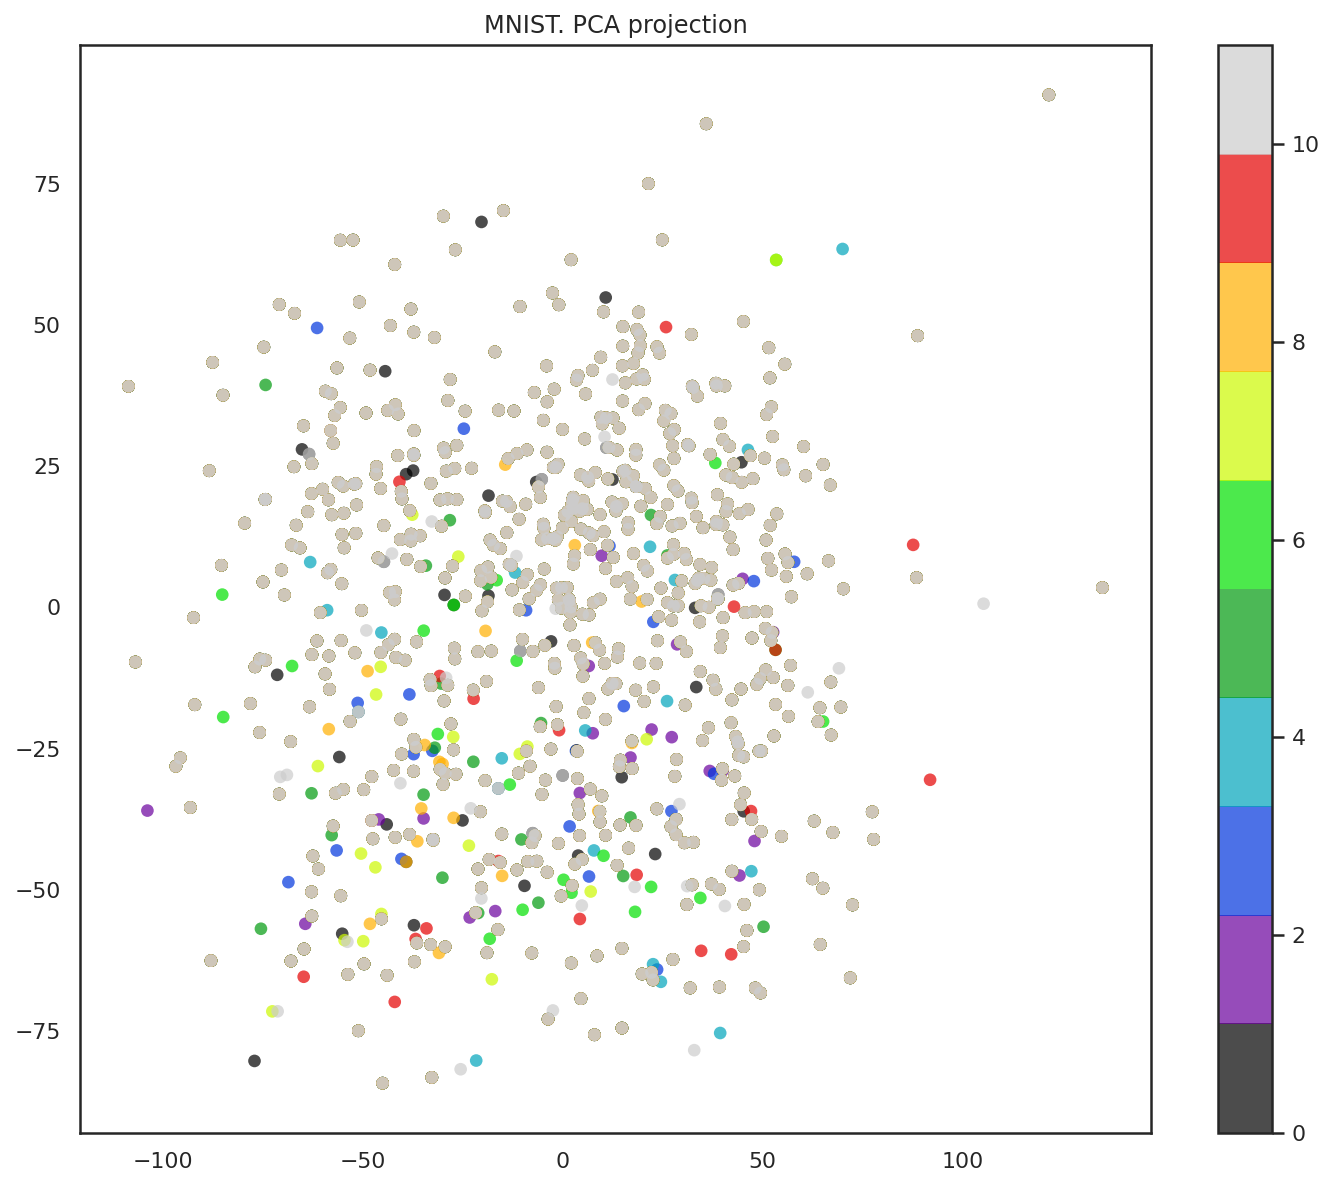

In [ ]:
pca = decomposition.PCA(n_components=12)

X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# Test-train split and apply PCA
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

In [ ]:
RandomForest_Classifier = RandomForestClassifier(n_estimators=800)
RandomForest_Classifier.fit(X_tr, y_tr)

RandomForestClassifier(n_estimators=800)

In [ ]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            ['mfcc'])))

1 component: 21.63% of initial variance
-0.009 x mfcc
2 component: 13.89% of initial variance
0.009 x mfcc
3 component: 7.25% of initial variance
-0.005 x mfcc
4 component: 4.45% of initial variance
0.027 x mfcc
5 component: 4.11% of initial variance
0.008 x mfcc
6 component: 3.9% of initial variance
-0.018 x mfcc
7 component: 3.61% of initial variance
-0.015 x mfcc
8 component: 2.81% of initial variance
0.020 x mfcc
9 component: 2.58% of initial variance
0.025 x mfcc
10 component: 2.5% of initial variance
0.002 x mfcc
11 component: 2.12% of initial variance
0.001 x mfcc
12 component: 2.09% of initial variance
0.041 x mfcc


In [ ]:
from sklearn.metrics import accuracy_score
preds = RandomForest_Classifier.predict_proba(X_te)
print('Accuracy: {:.5f}'.format(accuracy_score(y_te, 
                                                preds.argmax(axis=1))))

Accuracy: 0.00483


# Hidden Markov Model

In [ ]:
!pip install scikits.talkbox
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.1 MB/s 
  ERROR: Failed building wheel for scikits.talkbox
  Running setup.py clean for scikits.talkbox
Failed to build scikits.talkbox
    Running setup.py install for scikits.talkbox ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ya_41uvl/scikits-talkbox_a0ddb8d774264ac2a775144dc127411a/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ya_41uvl/scikits-talkbox_a0ddb8d774264ac2a775144dc127411a/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-25pg71tm/install-record.txt --single-ver

In [ ]:
from hmmlearn.hmm import GaussianHMM
 
def fitHMM(Q, nSamples):
    # fit Gaussian HMM to Q
    param=set(Q.ravel())
    model = GaussianHMM(n_components=12, covariance_type="tied", n_iter=1000)
    model.fit(Q)
    save_model(model, 'hmm')
    # classify each observation as state 0 or 1
    hidden_states = model.predict(Q)
 
    # find parameters of Gaussian HMM
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(Q)
 
    # generate nSamples from Gaussian HMM
    samples = model.sample(nSamples)
 
    # re-organize mus, sigmas and P so that first row is lower mean (if not already)
 
    return hidden_states, mus, sigmas, P, logProb, samples
 
hidden_states, mus, sigmas, P, logProb, samples = fitHMM(X, 100)

In [ ]:
print(hidden_states.shape)
print(hidden_states.shape)

(7584,)
(7584,)


In [ ]:
labels= np.unique(file_category)

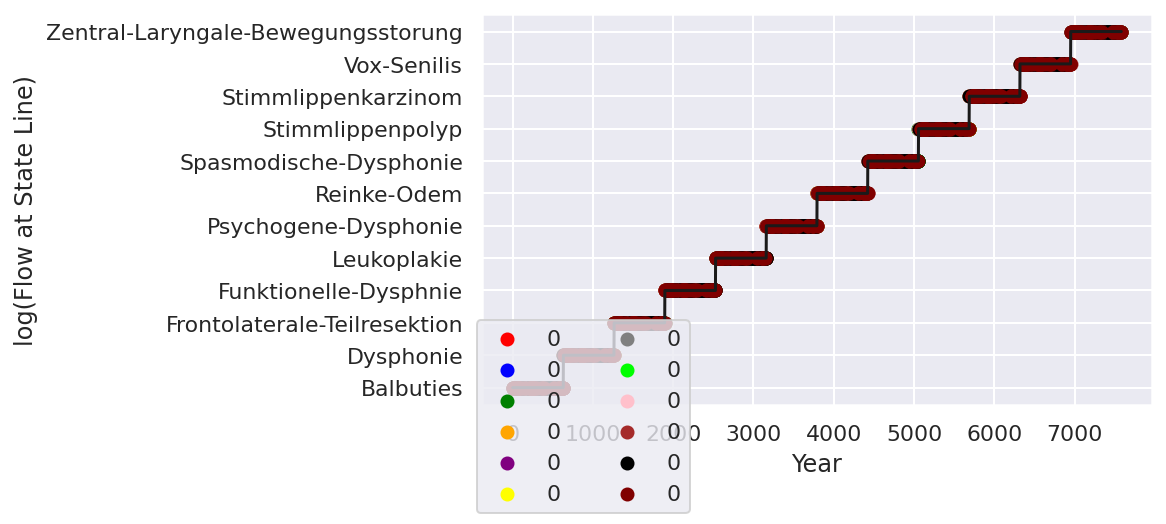

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
 
def plotTimeSeries(Q, hidden_states, ylabel, filename,labels):
 
    sns.set()
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    xs = np.arange(len(Q))
    masks = hidden_states == 0
    ax.scatter(xs[masks], Q[masks], c='red', label=labels[0])
    masks = hidden_states == 1
    ax.scatter(xs[masks], Q[masks], c='blue', label=labels[1])
    masks = hidden_states == 2
    ax.scatter(xs[masks], Q[masks], c='green', label=labels[2])
    masks = hidden_states == 3
    ax.scatter(xs[masks], Q[masks], c='orange', label=labels[3])
    masks = hidden_states == 4
    ax.scatter(xs[masks], Q[masks], c='purple', label=labels[4])
    masks = hidden_states == 5
    ax.scatter(xs[masks], Q[masks], c='yellow', label=labels[5])
    masks = hidden_states == 6
    ax.scatter(xs[masks], Q[masks], c='grey', label=labels[6])
    masks = hidden_states == 7
    ax.scatter(xs[masks], Q[masks], c='lime', label=labels[7])
    masks = hidden_states == 8
    ax.scatter(xs[masks], Q[masks], c='pink', label=labels[8])
    masks = hidden_states == 9
    ax.scatter(xs[masks], Q[masks], c='brown', label=labels[9])
    masks = hidden_states == 10
    ax.scatter(xs[masks], Q[masks], c='black', label=labels[10])
    masks = hidden_states == 11
    ax.scatter(xs[masks], Q[masks], c='maroon', label=labels[11])
    ax.plot(xs, Q, c='k')
     
    ax.set_xlabel('Year')
    ax.set_ylabel(ylabel)
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, frameon=True)
    fig.show()
 
    return None
 
plt.switch_backend('agg') # turn off display when running with Cygwin
plotTimeSeries(Y, hidden_states, 'log(Flow at State Line)', 'StateTseries_Log.png',labels)


In [ ]:
print(y.shape, mus.shape, sigmas.shape, P.shape)

(7584,) (12, 126) (2, 126) (12, 12)


(10000, 126) (10000, 126)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


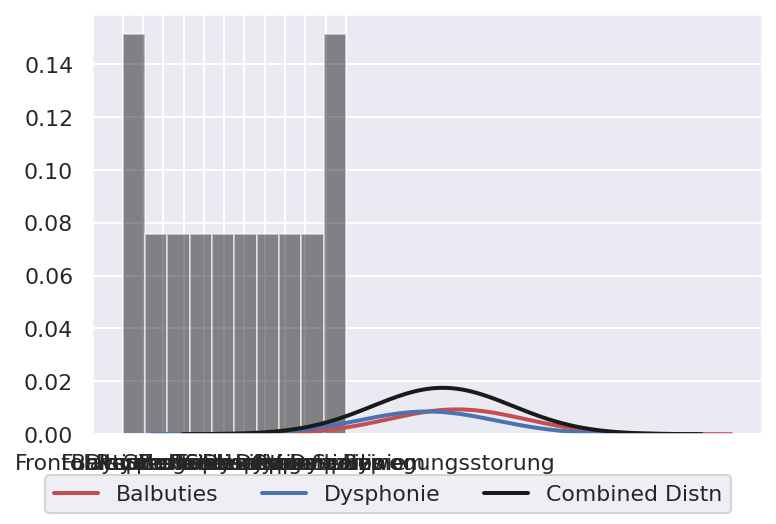

In [ ]:
from scipy import stats as ss
 
def plotDistribution(Q, mus, sigmas, P, filename,labels):
 
    # calculate stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(np.transpose(P))
    one_eigval = np.argmin(np.abs(eigenvals-1))
    pi = eigenvecs[:,one_eigval] / np.sum(eigenvecs[:,one_eigval])
 
    x_0 = np.linspace(mus[0]-4*sigmas[0], mus[0]+4*sigmas[0], 10000)
    fx_0 = pi[0]*ss.norm.pdf(x_0,mus[0],sigmas[0])
 
    x_1 = np.linspace(mus[1]-4*sigmas[1], mus[1]+4*sigmas[1], 10000)
    fx_1 = pi[1]*ss.norm.pdf(x_1,mus[1],sigmas[1])
 
    x = np.linspace(mus[0]-4*sigmas[0], mus[1]+4*sigmas[1], 10000)
    fx = pi[0]*ss.norm.pdf(x,mus[0],sigmas[0]) + \
        pi[1]*ss.norm.pdf(x,mus[1],sigmas[1])
 
    sns.set()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(Q, color='k', alpha=0.5, density=True)
    print(x_0.shape, fx_0.shape)
    l1, = ax.plot(x_0[:,1], fx_0[:,1], c='r', linewidth=2, label=labels[0])
    l2, = ax.plot(x_1[:,1], fx_1[:,1], c='b', linewidth=2, label=labels[1])
    l13, = ax.plot(x[:,1], fx[:,1], c='k', linewidth=2, label='Combined Distn')
 
    fig.subplots_adjust(bottom=0.15)
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=13, frameon=True)
    fig.show()
 
    return None
 
plotDistribution(Y, mus, sigmas, P, 'MixedGaussianFit_Log.png',labels)


In [ ]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = X_centered

cent_history = []
cent_history.append(centroids)

for i in range(12):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    centroids[3, :] = np.mean(X[labels == 3, :], axis=0)
    centroids[4, :] = np.mean(X[labels == 4, :], axis=0)
    centroids[5, :] = np.mean(X[labels == 5, :], axis=0)
    centroids[6, :] = np.mean(X[labels == 6, :], axis=0)
    centroids[7, :] = np.mean(X[labels == 7, :], axis=0)
    centroids[8, :] = np.mean(X[labels == 8, :], axis=0)
    centroids[9, :] = np.mean(X[labels == 9, :], axis=0)
    centroids[10, :] = np.mean(X[labels == 10, :], axis=0)
    centroids[11, :] = np.mean(X[labels == 11, :], axis=0)
    
    cent_history.append(centroids)

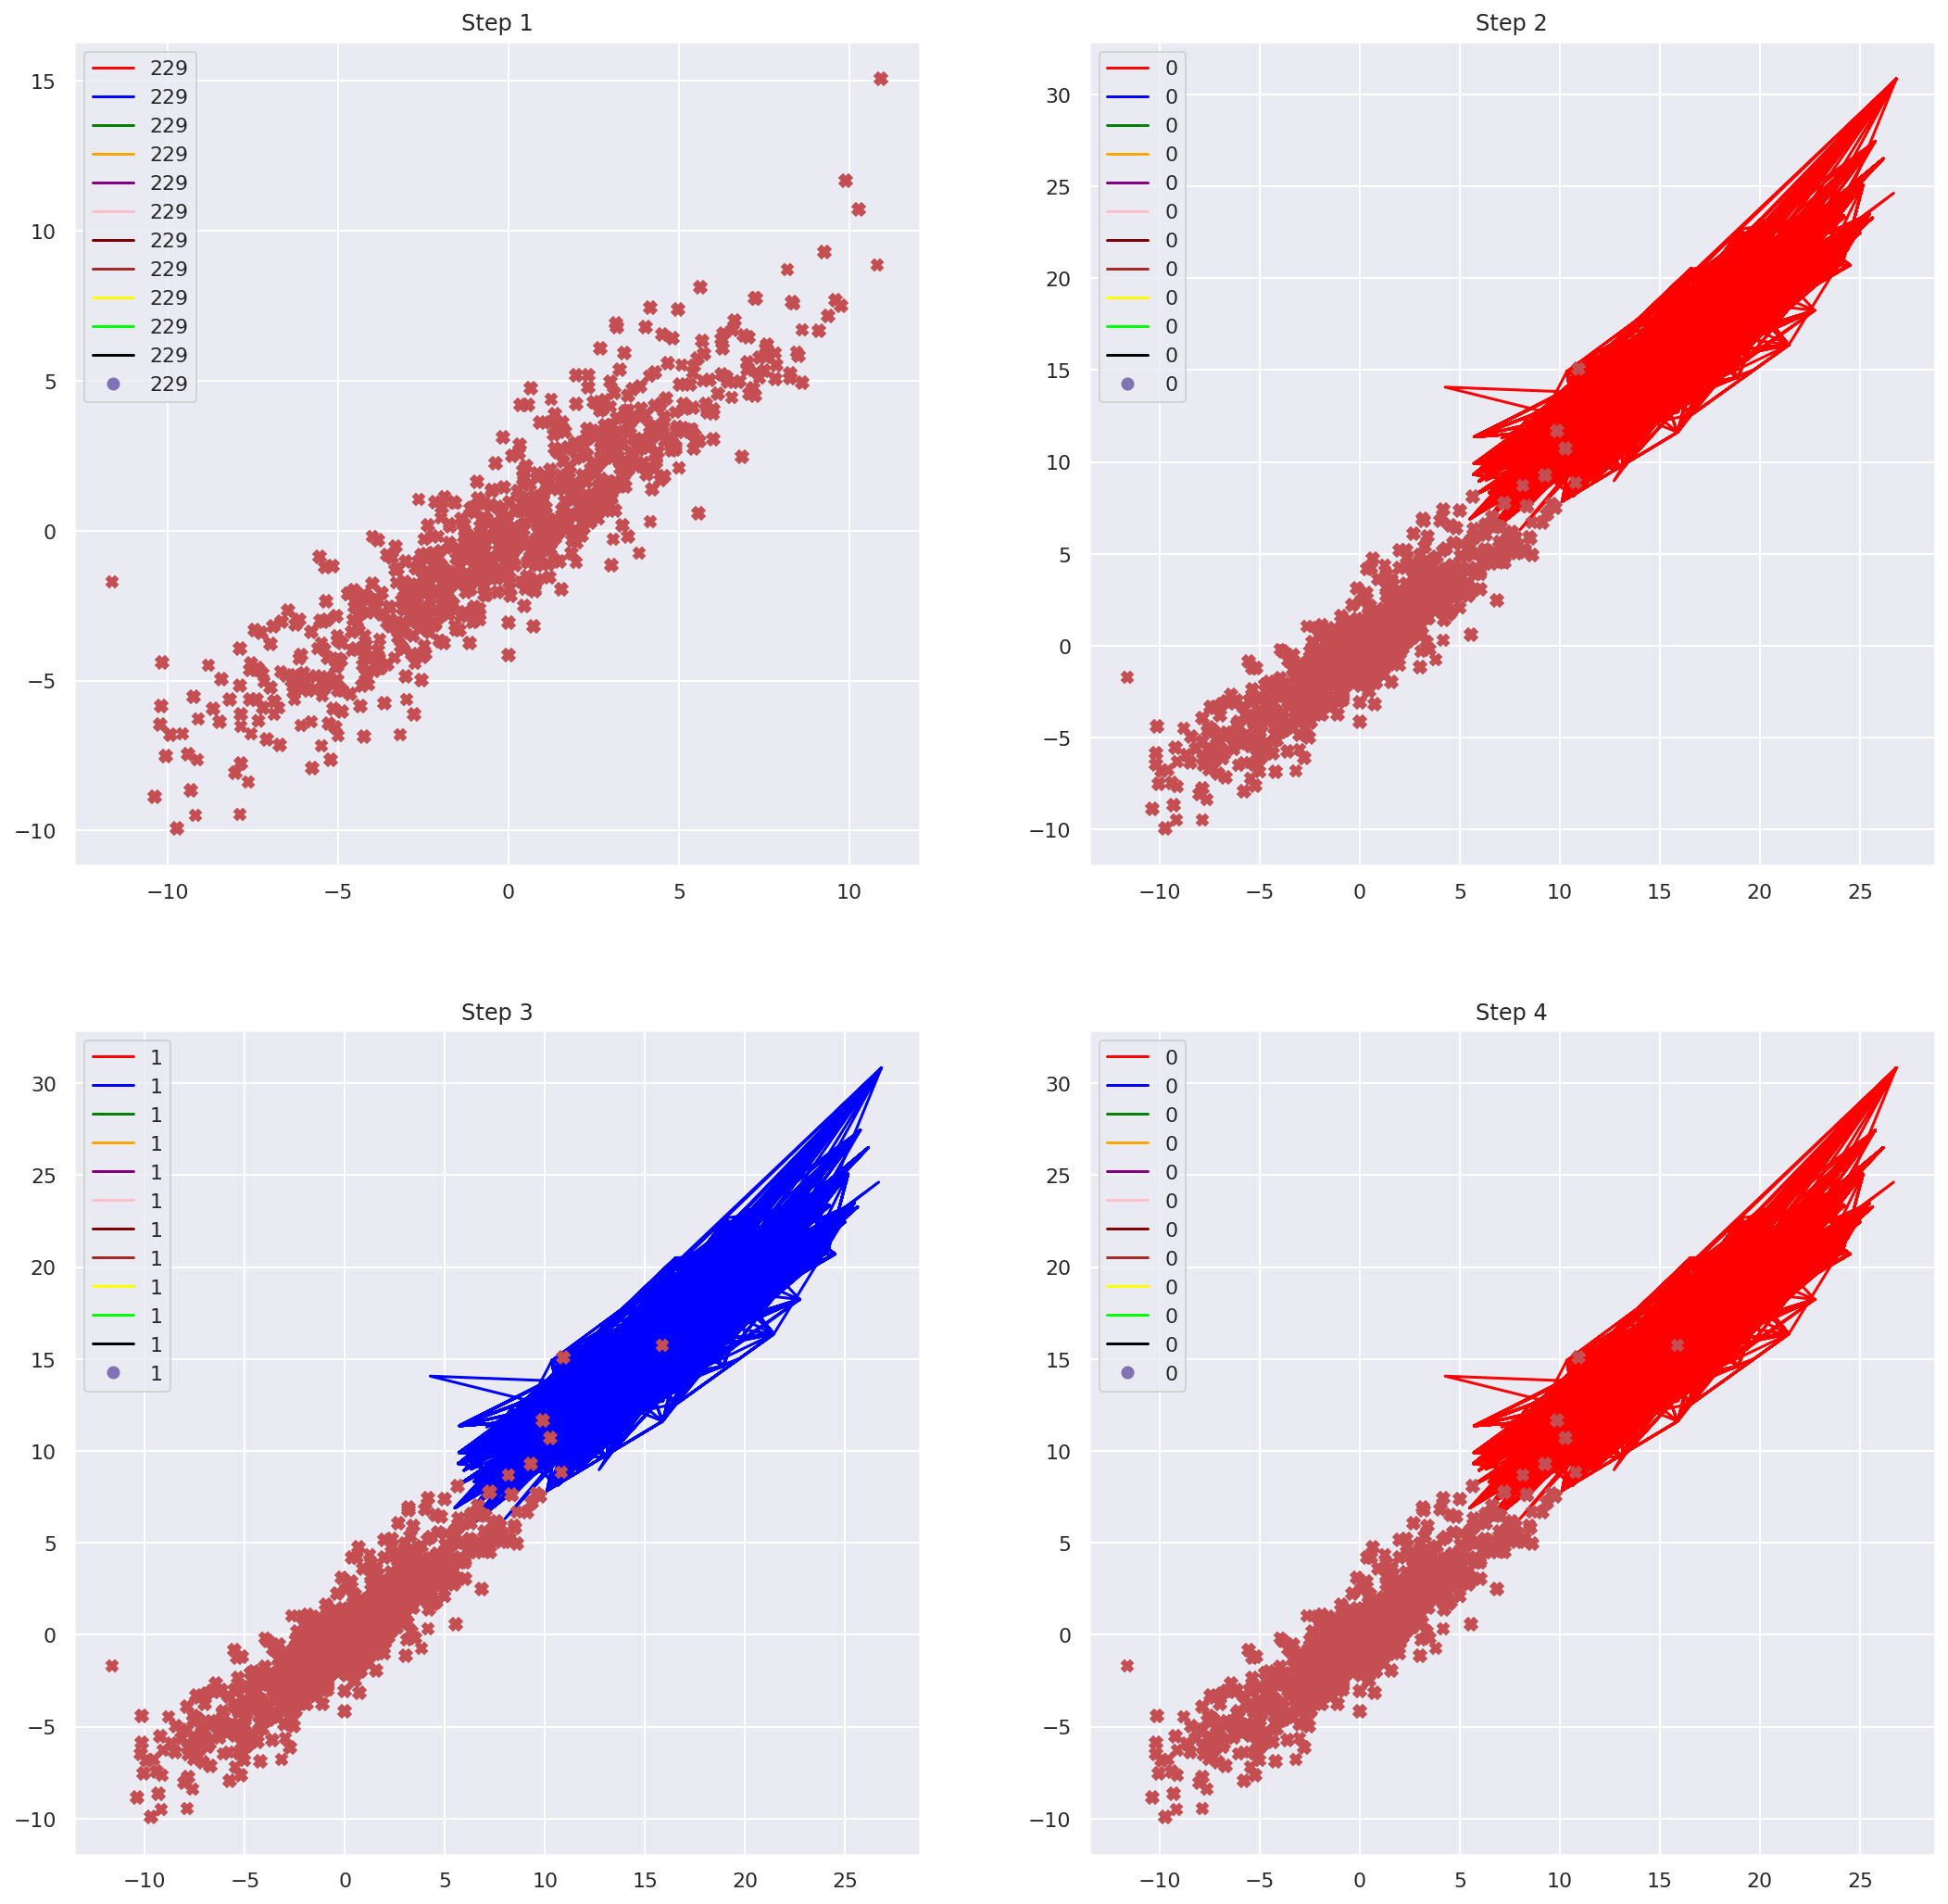

In [ ]:
# Let's plot K-means
plt.figure(figsize=(18, 18))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'red', label=labels[0])
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'blue', label=labels[1])
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'green', label=labels[2])
    plt.plot(X[labels == 3, 0], X[labels == 3, 1], 'orange', label=labels[3])
    plt.plot(X[labels == 4, 0], X[labels == 4, 1], 'purple', label=labels[4])
    plt.plot(X[labels == 5, 0], X[labels == 5, 1], 'pink', label=labels[5])
    plt.plot(X[labels == 6, 0], X[labels == 6, 1], 'maroon', label=labels[6])
    plt.plot(X[labels == 7, 0], X[labels == 7, 1], 'brown', label=labels[7])
    plt.plot(X[labels == 8, 0], X[labels == 8, 1], 'yellow', label=labels[8])
    plt.plot(X[labels == 9, 0], X[labels == 9, 1], 'lime', label=labels[9])
    plt.plot(X[labels == 10, 0], X[labels == 10, 1], 'black', label=labels[10])
    plt.plot(X[labels == 11, 0], X[labels == 11, 1], 'mo', label=labels[11])
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

#Clustering


In [ ]:
# speech clustering kmeans
km_speech = KMeans(n_clusters=n_clusters,max_iter=300,tol=1e-4,random_state=42,).fit(X_train)
print(pd.crosstab(y_train,km_speech.labels_))
print("\nARI",adjusted_rand_score(y_train,km_speech.labels_))
print("Silhouette Score",silhouette_score(X_train,km_speech.predict(X_train)))

col_0                               0   1   2   3   4   5   6   7   8   9   \
row_0                                                                        
Balbuties                           32  53  36  40  43  50  30  57  46  51   
Dysphonie                           26  63  32  37  46  42  35  52  43  46   
Frontolaterale-Teilresektion        30  61  38  40  43  45  35  52  41  53   
Funktionelle-Dysphnie               34  60  33  40  46  45  34  52  41  46   
Leukoplakie                         27  60  36  36  43  45  34  54  48  51   
Psychogene-Dysphonie                32  57  38  34  42  48  30  47  41  48   
Reinke-Odem                         29  68  35  32  39  47  27  49  44  53   
Spasmodische-Dysphonie              29  57  35  34  39  49  29  54  43  49   
Stimmlippenkarzinom                 28  50  30  41  41  49  32  52  40  50   
Stimmlippenpolyp                    31  60  45  42  39  47  33  53  46  48   
Vox-Senilis                         29  60  38  39  43  48  34  

In [ ]:
save_model(km_speech, 'km')

In [ ]:
# mean shift
bandwidth = estimate_bandwidth(X_train, random_state=42,n_jobs=-1)
ms_speech = MeanShift(bandwidth=bandwidth).fit(X_train)
print("\nARI",adjusted_rand_score(y_train,ms_speech.labels_))
print("Silhouette Score",silhouette_score(X_train,ms_speech.predict(X_train)))


ARI 2.1489412524701203e-07
Silhouette Score 0.25304833


In [ ]:
save_model(ms_speech, 'ms')

In [ ]:
print("Silhouette Score",silhouette_score(X_train,ms_speech.predict(X_train)))

Silhouette Score 0.25304833


In [ ]:
# spectral clustering
sc_speech = SpectralClustering(n_clusters=n_clusters,gamma=1.0,random_state=42,n_jobs=-1)
sc_speech_pred = sc_speech.fit_predict(X_train)
print("\nARI",adjusted_rand_score(y_train,sc_speech.labels_))
print("Silhouette Score",silhouette_score(X_train,sc_speech_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."



ARI -0.000204799537859303
Silhouette Score -0.19493194


In [ ]:
save_model(sc_speech, 'sc')

In [ ]:
# affinity propogation
af_speech = AffinityPropagation(damping = .7).fit(X_train)
print(pd.crosstab(y_train,af_speech.labels_))
print("\nARI",adjusted_rand_score(y_train,af_speech.labels_))
print("Silhouette Score",silhouette_score(X_train,af_speech.predict(X_train)))

col_0                               0    1    2    3    4    5    6    7    \
row_0                                                                        
Balbuties                             1    1    1    1    1    1    0    1   
Dysphonie                             1    1    1    0    1    1    1    1   
Frontolaterale-Teilresektion          1    1    1    1    1    1    1    1   
Funktionelle-Dysphnie                 1    0    1    1    0    1    1    1   
Leukoplakie                           1    1    1    1    1    1    1    0   
Psychogene-Dysphonie                  1    1    0    1    1    1    1    1   
Reinke-Odem                           1    1    1    1    0    1    1    1   
Spasmodische-Dysphonie                0    0    1    1    1    1    1    0   
Stimmlippenkarzinom                   1    1    0    0    1    1    0    1   
Stimmlippenpolyp                      1    0    1    0    0    1    2    1   
Vox-Senilis                           1    1    1    1    1    1

In [ ]:
save_model(af_speech, 'af')

## Choosing the number of clusters for K-means


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
kmeans = KMeans(n_clusters=12, random_state=1).fit(X)
kmeans.predict(X)


array([ 3,  4,  3, ...,  7,  3, 10], dtype=int32)

In [ ]:
labels=np.unique(file_category)
accuracy = metrics.accuracy_score(y, kmeans.labels_)
print('============================== {} Model Test Results =============================='.format(i))
print()
print ("Model Accuracy:" "\n", accuracy)
print("Mean squared error: ", metrics.mean_squared_error(y, kmeans.labels_ ))
print('Variance score: %.2f' % metrics.r2_score(y, kmeans.labels_ ))

============================== 3 Model Test Results ==============================

Model Accuracy:
 0.08333333333333333
Mean squared error:  22.31948839662447
Variance score: -0.87


In [ ]:
save_model(kmeans, 'kmeans')

## Hierarchy

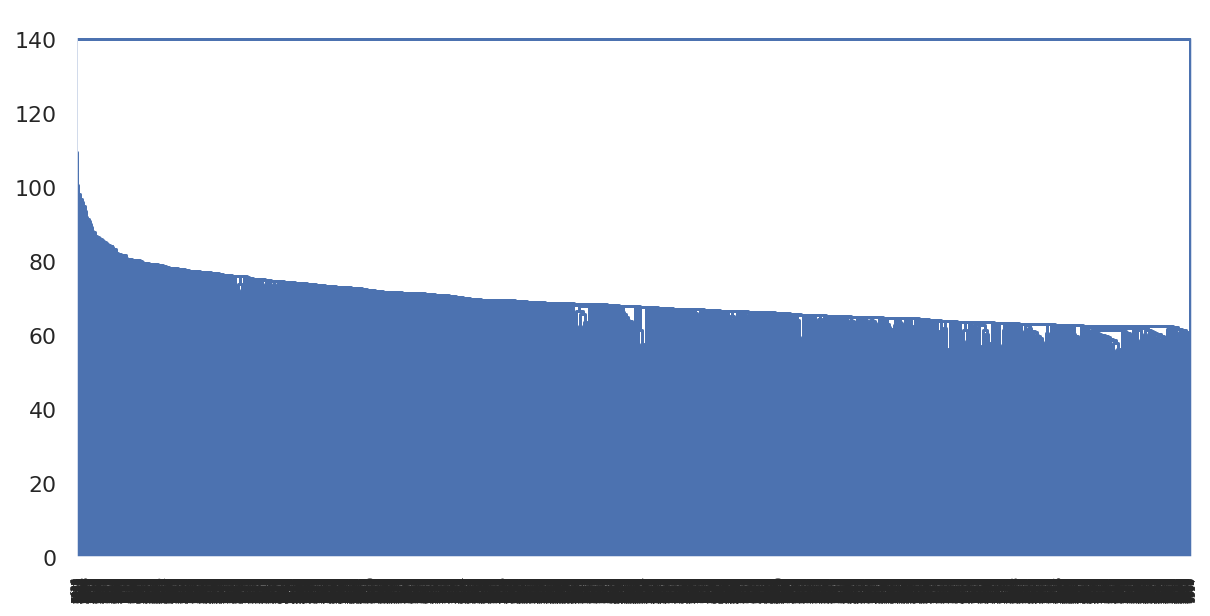

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = X

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# pdist will calculate the upper triangle of the pairwise distance matrix
distance_mat = pdist(X) 
# linkage — is an implementation if agglomerative algorithm
Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

## Agglomerative clustering


In [ ]:
from sklearn.cluster import AgglomerativeClustering
Agglo=AgglomerativeClustering(n_clusters=12)
Agglo.fit(X)

AgglomerativeClustering(n_clusters=12)

In [ ]:
labels=np.unique(file_category)
le = LabelEncoder()
y=le.fit_transform(Y)
classes= list(le.classes_)
accuracy = metrics.accuracy_score(y, Agglo.labels_)
print('============================== {} Model Test Results =============================='.format(i))
print()
print ("Model Accuracy:" "\n", accuracy)
print("Mean squared error: ", metrics.mean_squared_error(y, Agglo.labels_))
print('Variance score: %.2f' % metrics.r2_score(y,Agglo.labels_))

============================== 3 Model Test Results ==============================

Model Accuracy:
 0.0837289029535865
Mean squared error:  22.66653481012658
Variance score: -0.90


## Affinity Propagation

In [ ]:
from sklearn.cluster import AffinityPropagation
Afps =AffinityPropagation()
Afps.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,


AffinityPropagation()

In [ ]:
labels=np.unique(file_category)
le = LabelEncoder()
y=le.fit_transform(Y)
classes= list(le.classes_)
accuracy = metrics.accuracy_score(y, Afps.labels_)
print('============================== {} Model Test Results =============================='.format(i))
print()
print ("Model Accuracy:" "\n", accuracy)
print("Mean squared error: ", metrics.mean_squared_error(y, Afps.labels_))
print('Variance score: %.2f' % metrics.r2_score(y,Afps.labels_))

============================== 3 Model Test Results ==============================

Model Accuracy:
 0.0
Mean squared error:  54.166666666666664
Variance score: -3.55


## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering
SpC =SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors')
SpC.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


SpectralClustering(affinity='nearest_neighbors', n_clusters=12, random_state=1)

In [ ]:
labels=np.unique(file_category)
le = LabelEncoder()
y=le.fit_transform(Y)
classes= list(le.classes_)
accuracy = metrics.accuracy_score(y, SpC.labels_)
print('============================== {} Model Test Results =============================='.format(i))
print()
print ("Model Accuracy:" "\n", accuracy)
print("Mean squared error: ", metrics.mean_squared_error(y, SpC.labels_))
print('Variance score: %.2f' % metrics.r2_score(y,SpC.labels_))

============================== 3 Model Test Results ==============================

Model Accuracy:
 0.08399261603375527
Mean squared error:  17.325290084388186
Variance score: -0.45


# Agglomerative

In [ ]:
from sklearn.cluster import AgglomerativeClustering
Agglos =AgglomerativeClustering(n_clusters=12)
Agglos.fit(X)

AgglomerativeClustering(n_clusters=12)

In [ ]:
labels=np.unique(file_category)
le = LabelEncoder()
y=le.fit_transform(Y)
classes= list(le.classes_)
accuracy = metrics.accuracy_score(y, Agglos.labels_)
print('============================== {} Model Test Results =============================='.format(i))
print()
print ("Model Accuracy:" "\n", accuracy)
print("Mean squared error: ", metrics.mean_squared_error(y, Agglos.labels_))
print('Variance score: %.2f' % metrics.r2_score(y,Agglos.labels_))

============================== 3 Model Test Results ==============================

Model Accuracy:
 0.0837289029535865
Mean squared error:  22.66653481012658
Variance score: -0.90


# EVALUATE MODELS

In [ ]:

def mlresults(modelname , y,pred):
  le = LabelEncoder()
  y_test=le.fit_transform(y)
  le = LabelEncoder()
  pred=le.fit_transform(pred)
  accuracy = metrics.accuracy_score(y_test,pred)
  confusion_matrix = metrics.confusion_matrix(y_test,pred)
  classification = metrics.classification_report(y_test,pred)
  accuracy = metrics.accuracy_score(y_test, pred)
  mse=metrics.mean_squared_error(y_test, pred)
  rs=metrics.r2_score(y_test, pred)
  print('============================== {} Model Test Results =============================='.format(modelname))
  print()
  print("Model Accuracy:" "\n", accuracy)
  print()
  print("Mean squared error: ", mse)
  print()
  print('Variance score: %.2f' % rs)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 

  return accuracy,mse,rs

### Hidden Markov Model Results

In [ ]:
mlresults('Hidden Markov Model' , Y, hidden_states)

============================== Hidden Markov Model Model Test Results ==============================

Model Accuracy:
 0.08333333333333333

Mean squared error:  23.671413502109704

Variance score: -0.99

Confusion matrix:
 [[ 50  47  31 105  20  58  35  44  44 112  51  35]
 [ 52  46  34 103  21  59  35  45  44 106  51  36]
 [ 50  45  36 103  20  60  35  45  44 106  51  37]
 [ 50  46  33 102  21  58  35  46  46 107  54  34]
 [ 50  44  34 104  20  58  35  44  47 108  55  33]
 [ 51  46  33 102  21  59  35  47  44 109  53  32]
 [ 50  46  34 103  20  59  36  46  44 106  51  37]
 [ 50  46  35 103  20  58  35  49  44 106  53  33]
 [ 50  47  34 101  20  58  35  46  44 108  52  37]
 [ 50  47  41 103  20  60  35  44  44 105  50  33]
 [ 50  45  33 102  20  60  36  46  45 110  50  35]
 [ 50  48  34 104  21  58  35  46  44 107  50  35]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      0.08      0.08       632
           1       0.08      0

(0.08333333333333333, 23.671413502109704, -0.9864123218553598)

### Clustering Results

In [ ]:
mlresults('K Means' , Y, kmeans.labels_)

============================== K Means Model Test Results ==============================

Model Accuracy:
 0.08333333333333333

Mean squared error:  22.31948839662447

Variance score: -0.87

Confusion matrix:
 [[45 67 54 70 71 51 65 90 41  1 28 49]
 [43 68 54 72 66 51 66 90 42  1 29 50]
 [43 67 53 77 65 51 65 90 39  1 28 53]
 [45 69 54 72 65 52 66 89 40  1 29 50]
 [43 68 54 75 69 53 65 89 39  2 28 47]
 [46 67 54 72 66 54 65 90 40  1 28 49]
 [46 68 53 76 66 52 65 89 40  1 28 48]
 [47 68 52 70 66 52 65 88 40  1 30 53]
 [46 67 56 70 66 51 65 89 40  1 28 53]
 [43 68 52 75 67 51 65 90 39  1 28 53]
 [45 67 54 74 67 52 66 89 39  1 28 50]
 [45 67 53 72 68 51 65 92 40  1 29 49]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      0.07      0.08       632
           1       0.08      0.11      0.09       632
           2       0.08      0.08      0.08       632
           3       0.08      0.11      0.10       632
           4       0.09  

(0.08333333333333333, 22.31948839662447, -0.8729640612552005)

In [ ]:
mlresults('Affinity' , Y,Afps.labels_)

============================== Affinity Model Test Results ==============================

Model Accuracy:
 0.08333333333333333

Mean squared error:  42.166666666666664

Variance score: -2.54

Confusion matrix:
 [[632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]
 [632   0   0   0   0   0   0   0   0   0   0   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      1.00      0.15       632
           1       0.00      0.00      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.08333333333333333, 42.166666666666664, -2.5384615384615383)

In [ ]:
mlresults('Spectral' , Y,SpC.labels_)

============================== Spectral Model Test Results ==============================

Model Accuracy:
 0.08399261603375527

Mean squared error:  17.325290084388186

Variance score: -0.45

Confusion matrix:
 [[ 45   2 146   2  24   8 395   1   1   4   2   2]
 [ 46   1 145   1  23   8 398   1   1   4   2   2]
 [ 43   1 147   2  23   9 397   1   1   4   2   2]
 [ 42   1 146   1  27   8 397   1   1   4   2   2]
 [ 44   1 146   2  23   9 397   1   1   4   2   2]
 [ 42   1 144   2  25   8 400   1   1   4   2   2]
 [ 43   1 144   1  23   8 402   1   1   4   2   2]
 [ 43   1 144   2  26   8 398   1   1   4   2   2]
 [ 43   1 145   2  23   8 400   1   1   4   2   2]
 [ 43   1 144   2  23   8 401   1   1   4   2   2]
 [ 43   1 146   2  23   8 399   1   1   4   2   2]
 [ 44   2 146   2  25   8 395   1   1   4   2   2]]

Classification report:
               precision    recall  f1-score   support

           0       0.09      0.07      0.08       632
           1       0.07      0.00      0.

(0.08399261603375527, 17.325290084388186, -0.4538704965920155)

In [ ]:
mlresults('Agglomerative',Y,Agglos.labels_)

============================== Agglomerative Model Test Results ==============================

Model Accuracy:
 0.0837289029535865

Mean squared error:  22.66653481012658

Variance score: -0.90

Confusion matrix:
 [[63 72 60 42 90 82 41 36 63 29 26 28]
 [64 72 57 41 89 83 43 36 63 30 25 29]
 [64 72 56 41 89 82 44 37 63 31 26 27]
 [64 73 56 42 89 83 43 35 63 32 25 27]
 [64 71 57 41 89 83 45 35 63 31 26 27]
 [63 74 57 42 89 82 41 38 63 31 25 27]
 [64 73 56 41 89 84 44 34 63 29 28 27]
 [63 74 57 41 89 82 41 41 63 29 25 27]
 [63 75 57 41 89 85 40 37 64 29 25 27]
 [63 70 57 41 89 85 44 39 63 29 25 27]
 [63 75 57 42 89 83 42 36 63 29 25 28]
 [65 70 58 43 90 82 42 37 63 29 25 28]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      0.10      0.09       632
           1       0.08      0.11      0.10       632
           2       0.08      0.09      0.09       632
           3       0.08      0.07      0.07       632
           4       0

(0.0837289029535865, 22.66653481012658, -0.9020868372134194)

### PCA Results

In [ ]:
mlresults('PCA-Random Forest',y_train,rfc_pca.predict(X_pca_train))

============================== PCA-Random Forest Model Test Results ==============================

Model Accuracy:
 0.13598153947585298

Mean squared error:  22.833360804351408

Variance score: -0.91

Confusion matrix:
 [[57 38 52 40 39 36 41 31 35 52 47 46]
 [32 69 46 42 33 37 37 30 37 47 42 42]
 [33 39 79 43 34 36 43 32 40 50 48 38]
 [33 36 43 75 37 37 38 35 37 52 48 36]
 [37 38 48 50 63 31 38 31 34 52 52 39]
 [37 31 37 43 36 63 38 35 38 51 47 39]
 [36 40 42 40 37 35 71 33 33 47 45 40]
 [35 35 42 36 41 35 40 58 34 53 50 38]
 [37 36 41 42 40 35 41 34 61 47 41 41]
 [39 43 43 43 37 36 40 33 38 85 50 38]
 [34 36 48 44 37 38 35 36 37 50 79 41]
 [38 40 40 39 38 30 39 33 35 50 50 65]]

Classification report:
               precision    recall  f1-score   support

           0       0.13      0.11      0.12       514
           1       0.14      0.14      0.14       494
           2       0.14      0.15      0.15       515
           3       0.14      0.15      0.14       507
           4  

(0.13598153947585298, 22.833360804351408, -0.9095807396532749)

In [ ]:
mlresults('PCA-Support Vector Machine',y_train,svc_pca.predict(X_pca_train))

============================== PCA-Support Vector Machine Model Test Results ==============================

Model Accuracy:
 0.11373001483434976

Mean squared error:  25.953189385198616

Variance score: -1.17

Confusion matrix:
 [[ 90  12  30  45  49  17  25  13   7 117  65  44]
 [ 60  26  26  47  46  17  28  10   9 123  56  46]
 [ 67  21  43  46  49  15  28  14   6 125  53  48]
 [ 67  20  31  63  41  15  28  13   7 117  61  44]
 [ 69  19  26  44  63  16  29  13   7 122  55  50]
 [ 66  18  31  41  42  29  28  13   7 114  57  49]
 [ 68  16  28  45  44  17  45  11   5 119  57  44]
 [ 65  14  28  42  45  15  30  23   8 111  65  51]
 [ 69  15  31  51  44  17  23  13  16 116  56  45]
 [ 67  20  30  46  44  14  30  12   6 156  52  48]
 [ 66  17  29  49  49  15  24  16   7 123  77  43]
 [ 62  19  32  39  49  19  28  13   7 120  50  59]]

Classification report:
               precision    recall  f1-score   support

           0       0.11      0.18      0.14       514
           1       0.12

(0.11373001483434976, 25.953189385198616, -1.1704956623426357)

In [ ]:
mlresults('PCA-Nearest Shrunken Centroid',y_train,nsc_pca.predict(X_pca_train))

============================== PCA-Nearest Shrunken Centroid Model Test Results ==============================

Model Accuracy:
 0.09098401186747981

Mean squared error:  24.12576232075161

Variance score: -1.02

Confusion matrix:
 [[45  0  0 32 10 67 61 43 79 39 50 88]
 [38  1  1 35 10 57 66 39 68 38 51 90]
 [41  1  1 36 10 62 68 40 78 44 46 88]
 [42  1  1 41  9 60 71 39 76 35 46 86]
 [44  1  1 34 11 60 67 38 79 40 47 91]
 [39  1  1 33  9 70 55 34 81 40 48 84]
 [33  1  1 34 11 61 73 44 73 41 51 76]
 [42  1  1 36  9 62 66 36 78 33 49 84]
 [38  1  0 35 10 62 65 40 79 43 44 79]
 [45  1  0 38 10 60 75 40 78 41 48 89]
 [39  1  1 38 11 60 65 38 81 37 57 87]
 [38  1  1 29 13 68 66 36 70 38 40 97]]

Classification report:
               precision    recall  f1-score   support

           0       0.09      0.09      0.09       514
           1       0.09      0.00      0.00       494
           2       0.11      0.00      0.00       515
           3       0.10      0.08      0.09       507
   

(0.09098401186747981, 24.12576232075161, -1.0176657940069984)

In [ ]:
mlresults('PCA-Logistic Regression',y_train,lasso_pca.predict(X_pca_train))

============================== PCA-Logistic Regression Model Test Results ==============================

Model Accuracy:
 0.0942805340365914

Mean squared error:  25.62007582000989

Variance score: -1.14

Confusion matrix:
 [[ 65   6  24  56  30  36  31  21  32  92  68  53]
 [ 55   7  22  56  27  33  34  17  26  93  68  56]
 [ 61   5  22  58  28  34  38  18  32  95  64  60]
 [ 66   6  21  62  24  31  38  16  32  88  68  55]
 [ 69   7  18  50  36  35  33  21  28  92  68  56]
 [ 61   5  24  51  28  42  30  17  29  88  64  56]
 [ 51   4  23  55  34  34  40  16  30  91  69  52]
 [ 62   8  17  54  29  33  42  19  30  82  65  56]
 [ 57   6  19  56  26  32  32  19  37  93  70  49]
 [ 61   7  23  55  28  32  41  19  33 102  71  53]
 [ 61   5  19  60  29  34  31  19  30  97  79  51]
 [ 56   7  24  51  26  36  34  19  30  85  68  61]]

Classification report:
               precision    recall  f1-score   support

           0       0.09      0.13      0.10       514
           1       0.10     

(0.0942805340365914, 25.62007582000989, -1.1426369842596267)

### RBM Results

In [ ]:
mlresults('RBM-Random Forest',y_train,rfc_rbm.predict(X_rbm_train))

============================== RBM-Random Forest Model Test Results ==============================

Model Accuracy:
 0.12823471237844075

Mean squared error:  22.982363606395253

Variance score: -0.92

Confusion matrix:
 [[52 28 40 34 49 37 48 36 29 55 49 57]
 [29 47 42 31 46 35 45 36 32 52 45 54]
 [36 25 62 31 46 37 49 38 36 54 49 52]
 [33 27 35 58 47 35 48 40 32 50 50 52]
 [38 23 38 38 74 29 44 38 29 52 55 55]
 [38 19 28 34 43 57 46 39 33 55 48 55]
 [34 27 30 31 50 31 76 36 27 54 47 56]
 [35 22 33 31 52 35 48 59 29 51 50 52]
 [34 23 36 33 49 32 48 39 51 48 47 56]
 [40 27 34 34 46 32 47 37 33 84 53 58]
 [34 23 35 37 48 39 47 37 32 54 78 51]
 [36 25 32 29 53 28 44 40 29 51 50 80]]

Classification report:
               precision    recall  f1-score   support

           0       0.12      0.10      0.11       514
           1       0.15      0.10      0.12       494
           2       0.14      0.12      0.13       515
           3       0.14      0.11      0.12       507
           4  

(0.12823471237844075, 22.982363606395253, -0.9220420187166298)

In [ ]:
mlresults('RBM-Support Vector Machine',y_train,svc_rbm.predict(X_rbm_train))

============================== RBM-Support Vector Machine Model Test Results ==============================

Model Accuracy:
 0.08472061974616779

Mean squared error:  42.18279215427724

Variance score: -2.53

Confusion matrix:
 [[514   0   0   0   0   0   0   0   0   0   0   0]
 [494   0   0   0   0   0   0   0   0   0   0   0]
 [515   0   0   0   0   0   0   0   0   0   0   0]
 [507   0   0   0   0   0   0   0   0   0   0   0]
 [513   0   0   0   0   0   0   0   0   0   0   0]
 [495   0   0   0   0   0   0   0   0   0   0   0]
 [499   0   0   0   0   0   0   0   0   0   0   0]
 [497   0   0   0   0   0   0   0   0   0   0   0]
 [496   0   0   0   0   0   0   0   0   0   0   0]
 [525   0   0   0   0   0   0   0   0   0   0   0]
 [515   0   0   0   0   0   0   0   0   0   0   0]
 [497   0   0   0   0   0   0   0   0   0   0   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      1.00      0.16       514
           1       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.08472061974616779, 42.18279215427724, -2.527796373596225)

In [ ]:
mlresults('RBM-Logistic Regression',y_train,lasso_rbm.predict(X_rbm_train))

============================== RBM-Logistic Regression Model Test Results ==============================

Model Accuracy:
 0.08472061974616779

Mean squared error:  42.18279215427724

Variance score: -2.53

Confusion matrix:
 [[514   0   0   0   0   0   0   0   0   0   0   0]
 [494   0   0   0   0   0   0   0   0   0   0   0]
 [515   0   0   0   0   0   0   0   0   0   0   0]
 [507   0   0   0   0   0   0   0   0   0   0   0]
 [513   0   0   0   0   0   0   0   0   0   0   0]
 [495   0   0   0   0   0   0   0   0   0   0   0]
 [499   0   0   0   0   0   0   0   0   0   0   0]
 [497   0   0   0   0   0   0   0   0   0   0   0]
 [496   0   0   0   0   0   0   0   0   0   0   0]
 [525   0   0   0   0   0   0   0   0   0   0   0]
 [515   0   0   0   0   0   0   0   0   0   0   0]
 [497   0   0   0   0   0   0   0   0   0   0   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.08      1.00      0.16       514
           1       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.08472061974616779, 42.18279215427724, -2.527796373596225)

### MFCC Results

In [ ]:
mlresults('MFCC-Random Forest',y_train,rfc_mfcc.predict(X_train))

============================== MFCC-Random Forest Model Test Results ==============================

Model Accuracy:
 0.12823471237844075

Mean squared error:  22.987143563540464

Variance score: -0.92

Confusion matrix:
 [[52 38 52 39 42 36 40 33 34 52 48 48]
 [30 63 47 41 37 37 37 32 37 46 42 45]
 [33 39 75 44 34 35 42 34 39 50 48 42]
 [32 37 43 69 40 36 39 37 36 51 48 39]
 [35 36 48 48 64 31 37 35 34 51 52 42]
 [35 29 37 43 39 58 38 38 38 51 47 42]
 [35 41 42 40 40 34 65 35 33 47 45 42]
 [35 35 42 35 43 35 39 57 33 53 50 40]
 [36 36 41 42 42 35 41 36 57 47 42 41]
 [37 41 44 44 39 36 41 35 37 79 50 42]
 [31 36 48 43 41 37 36 38 36 49 75 45]
 [37 38 41 38 40 30 40 36 34 49 50 64]]

Classification report:
               precision    recall  f1-score   support

           0       0.12      0.10      0.11       514
           1       0.13      0.13      0.13       494
           2       0.13      0.15      0.14       515
           3       0.13      0.14      0.13       507
           4 

(0.12823471237844075, 22.987143563540464, -0.9224417721379099)

In [ ]:
mlresults('MFCC-Nearest Shrunken Centroid',y_train,nsc_mfcc.predict(X_train))

============================== MFCC-Nearest Shrunken Centroid Model Test Results ==============================

Model Accuracy:
 0.08505027196307895

Mean squared error:  26.227954507994067

Variance score: -1.19

Confusion matrix:
 [[140  39  18   2   9 123   2  61  10   9 101   0]
 [121  50  17   4  10 116   2  60  10   7  97   0]
 [133  46  17   3  10 123   2  56  11   8 106   0]
 [130  43  21   4  12 118   1  62  11   8  97   0]
 [129  46  19   4   9 123   1  54  10   6 112   0]
 [126  42  16   3  15 122   2  56  13   8  92   0]
 [113  45  19   5  10 132   2  60  14   8  91   0]
 [123  44  18   3  10 129   0  53  11   7  99   0]
 [127  39  18   4  12 120   2  64   6   7  97   0]
 [129  45  21   4  10 129   2  59  16   7 103   0]
 [133  41  20   4   6 124   2  59  13   7 106   0]
 [119  43  17   4  12 115   2  54  12   5 114   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.09      0.27      0.14       514
           1       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.08505027196307895, 26.227954507994067, -1.19347459176588)

In [ ]:
mlresults('MFCC-Logistic Regression',y_train,lasso_mfcc.predict(X_train))

============================== MFCC-Logistic Regression Model Test Results ==============================

Model Accuracy:
 0.103840448327015

Mean squared error:  23.65963408603923

Variance score: -0.98

Confusion matrix:
 [[50 39 47 35 42 29 46 39 39 51 57 40]
 [39 51 46 38 38 26 43 34 41 54 52 32]
 [43 39 56 39 38 33 49 37 41 55 52 33]
 [42 39 44 52 42 30 50 34 41 46 59 28]
 [44 36 44 41 48 31 43 37 43 53 56 37]
 [44 39 39 37 38 41 43 37 44 51 52 30]
 [41 37 46 43 41 26 54 35 43 49 55 29]
 [46 38 37 39 41 32 46 43 41 45 54 35]
 [41 36 44 41 39 31 48 30 53 50 53 30]
 [48 34 48 37 39 28 47 38 47 69 56 34]
 [41 41 40 44 38 30 49 35 42 52 66 37]
 [41 42 38 39 42 34 40 37 31 54 52 47]]

Classification report:
               precision    recall  f1-score   support

           0       0.10      0.10      0.10       514
           1       0.11      0.10      0.11       494
           2       0.11      0.11      0.11       515
           3       0.11      0.10      0.10       507
          

(0.103840448327015, 23.65963408603923, -0.9786829431318127)

## Result Tables

### HMM Accuracy metrics

In [ ]:
le = LabelEncoder()
y=le.fit_transform(Y)
classes= list(le.classes_)
data = []

predicted=le.fit_transform(hidden_states)
classes= list(le.classes_)
data.append(({
        'ARI': metrics.adjusted_rand_score(y, predicted),
        'AMI': metrics.adjusted_mutual_info_score(y, predicted,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, predicted),
        'Completeness': metrics.completeness_score(y, predicted),
        'V-measure': metrics.v_measure_score(y, predicted),
        'Accuracy Score': metrics.accuracy_score(y, predicted),
        'Mean Square Error': metrics.mean_squared_error(y, predicted),
        'Root Square': metrics.r2_score(y, predicted)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Accuracy Score','Mean Square Error','Root Square'],
                       index=['Hidden Markov Model'])

HMMresults=results
HMMresults

ARI      AMI  Homogenity  Completeness  V-measure  \
Hidden Markov Model -0.001234 -0.00316    0.000142      0.000148   0.000145   

                     Accuracy Score  Mean Square Error  Root Square  
Hidden Markov Model        0.083333          23.671414    -0.986412

### Clustering Accuracy metrics

In [ ]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

import joblib
from numpy import loadtxt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
algorithms = []
algorithms.append(KMeans(n_clusters=12, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=12))
algorithms.append(MeanShift(bandwidth=bandwidth))
le = LabelEncoder()
y=le.fit_transform(Y)
classes= list(le.classes_)
data = []
for algo in algorithms:
    print(algo)
    algo.fit(X)
    predicted = algo.labels_

    predicted=le.fit_transform(predicted)
    classes= list(le.classes_)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, predicted),
        'AMI': metrics.adjusted_mutual_info_score(y, predicted,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, predicted),
        'Completeness': metrics.completeness_score(y, predicted),
        'V-measure': metrics.v_measure_score(y, predicted),
        'Accuracy Score': metrics.accuracy_score(y, predicted),
        'Mean Square Error': metrics.mean_squared_error(y, predicted),
        'Root Square': metrics.r2_score(y, predicted)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Accuracy Score','Mean Square Error','Root Square'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative','Mean shift'])

clusteringresults=results
clusteringresults

KMeans(n_clusters=12, random_state=1)
AffinityPropagation()


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,


SpectralClustering(affinity='nearest_neighbors', n_clusters=12, random_state=1)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


AgglomerativeClustering(n_clusters=12)
MeanShift(bandwidth=106.48110012735393)


ARI       AMI  Homogenity  Completeness  V-measure  \
K-means       -0.001356 -0.003126    0.000127      0.000129   0.000128   
Affinity       0.000000  0.000000    0.000000      1.000000   0.000000   
Spectral      -0.000275 -0.004754    0.000115      0.000258   0.000159   
Agglomerative -0.001300 -0.003186    0.000100      0.000103   0.000102   
Mean shift    -0.000002 -0.001329    0.000414      0.036303   0.000819   

               Accuracy Score  Mean Square Error  Root Square  
K-means              0.083333          23.477057    -0.970103  
Affinity             0.083333          42.166667    -2.538462  
Spectral             0.083993          17.325290    -0.453870  
Agglomerative        0.083729          22.666535    -0.902087  
Mean shift           0.083201          42.102321    -2.533062

### PCA Feature Extraction Accuracy metrics

In [ ]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

import joblib
from numpy import loadtxt
from tensorflow.keras.models import load_model

algorithms = []
algorithms.append(rfc_pca)
algorithms.append(svc_pca)
algorithms.append(nsc_pca)
algorithms.append(lasso_pca)

le = LabelEncoder()
y=le.fit_transform(y_train)
classes= list(le.classes_)
data = []
for algo in algorithms:
    print(algo)
    predict=algo.predict(X_pca_train)
    predict=le.fit_transform(predict)
    classes= list(le.classes_)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, predict),
        'AMI': metrics.adjusted_mutual_info_score(y, predict,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, predict),
        'Completeness': metrics.completeness_score(y, predict),
        'V-measure': metrics.v_measure_score(y, predict),
        'Accuracy Score': metrics.accuracy_score(y, predict),
        'Mean Square Error': metrics.mean_squared_error(y, predict),
        'Root Square': metrics.r2_score(y, predict)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Accuracy Score','Mean Square Error','Root Square'],
                       index=['PCA-Random Forest', 'PCA-Support Vector Machine', 'PCA-Nearest Shrunken Centroid',
                              'PCA-Logistic Regression'])

PCAresults=results
PCAresults

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
SVC(gamma='auto', random_state=42)
NearestCentroid(shrink_threshold=0.2)
LogisticRegression(random_state=42)


ARI       AMI  Homogenity  Completeness  \
PCA-Random Forest              0.001853  0.002955    0.006972      0.006992   
PCA-Support Vector Machine    -0.000077 -0.000828    0.003262      0.003597   
PCA-Nearest Shrunken Centroid -0.001022 -0.003157    0.001172      0.001313   
PCA-Logistic Regression       -0.001074 -0.002971    0.001183      0.001264   

                               V-measure  Accuracy Score  Mean Square Error  \
PCA-Random Forest               0.006982        0.135982          22.833361   
PCA-Support Vector Machine      0.003421        0.113730          25.953189   
PCA-Nearest Shrunken Centroid   0.001238        0.090984          24.125762   
PCA-Logistic Regression         0.001222        0.094281          25.620076   

                               Root Square  
PCA-Random Forest                -0.909581  
PCA-Support Vector Machine       -1.170496  
PCA-Nearest Shrunken Centroid    -1.017666  
PCA-Logistic Regression          -1.142637

### RBM Feature Extraction Accuracy metrics

In [ ]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

import joblib
from numpy import loadtxt
from tensorflow.keras.models import load_model

algorithms = []
algorithms.append(rfc_rbm)
algorithms.append(svc_rbm)
algorithms.append(lasso_rbm)

le = LabelEncoder()
y=le.fit_transform(y_train)
classes= list(le.classes_)
data = []
for algo in algorithms:
    print(algo)
    predict=algo.predict(X_rbm_train)
    print(predict.shape)
    predict=le.fit_transform(predict)
    classes= list(le.classes_)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, predict),
        'AMI': metrics.adjusted_mutual_info_score(y, predict,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, predict),
        'Completeness': metrics.completeness_score(y, predict),
        'V-measure': metrics.v_measure_score(y, predict),
        'Accuracy Score': metrics.accuracy_score(y, predict),
        'Mean Square Error': metrics.mean_squared_error(y, predict),
        'Root Square': metrics.r2_score(y, predict)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Accuracy Score','Mean Square Error','Root Square'],
                       index=['RBM-Random Forest', 'RBM-Support Vector Machine',
                              'RBM-Logistic Regression'])

RBMresults=results
RBMresults

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
(6067,)
SVC(C=1, gamma='auto', kernel='linear', random_state=42)
(6067,)
LogisticRegression(C=1, random_state=42)
(6067,)


ARI           AMI  Homogenity  Completeness  \
RBM-Random Forest           0.000929  1.475693e-03    0.005496      0.005552   
RBM-Support Vector Machine  0.000000 -2.382658e-16    0.000000      1.000000   
RBM-Logistic Regression     0.000000 -2.382658e-16    0.000000      1.000000   

                            V-measure  Accuracy Score  Mean Square Error  \
RBM-Random Forest            0.005524        0.128235          22.982364   
RBM-Support Vector Machine   0.000000        0.084721          42.182792   
RBM-Logistic Regression      0.000000        0.084721          42.182792   

                            Root Square  
RBM-Random Forest             -0.922042  
RBM-Support Vector Machine    -2.527796  
RBM-Logistic Regression       -2.527796

### MFCC with Classifier Accuracy metrics

In [ ]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

import joblib
from numpy import loadtxt
from tensorflow.keras.models import load_model

algorithms = []
algorithms.append(rfc_mfcc)
algorithms.append(nsc_mfcc)
algorithms.append(lasso_mfcc)

le = LabelEncoder()
y=le.fit_transform(y_train)
classes= list(le.classes_)
data = []
for algo in algorithms:
    print(algo)
    predict=algo.predict(X_train)
    p=le.fit_transform(predict)
    classes= list(le.classes_)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, p),
        'AMI': metrics.adjusted_mutual_info_score(y, p,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, p),
        'Completeness': metrics.completeness_score(y, p),
        'V-measure': metrics.v_measure_score(y, p),
        'Accuracy Score': metrics.accuracy_score(y, p),
        'Mean Square Error': metrics.mean_squared_error(y, p),
        'Root Square': metrics.r2_score(y, p)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Accuracy Score','Mean Square Error','Root Square'],
                       index=['Random Forest', 'Nearest Shrunken Centroid',
                              'Logistic Regression'])

MFCCresults=results

MFCCresults

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
NearestCentroid(shrink_threshold=0.2)
LogisticRegression(C=1, random_state=42)


ARI       AMI  Homogenity  Completeness  \
Random Forest              0.000927  0.001312    0.005338      0.005353   
Nearest Shrunken Centroid -0.000661 -0.002938    0.001205      0.001597   
Logistic Regression       -0.000919 -0.002129    0.001918      0.001928   

                           V-measure  Accuracy Score  Mean Square Error  \
Random Forest               0.005345        0.128235          22.987144   
Nearest Shrunken Centroid   0.001374        0.085050          26.227955   
Logistic Regression         0.001923        0.103840          23.659634   

                           Root Square  
Random Forest                -0.922442  
Nearest Shrunken Centroid    -1.193475  
Logistic Regression          -0.978683

In [ ]:
data = [HMMresults,clusteringresults,PCAresults,RBMresults,MFCCresults]
results= pd.concat(data, ignore_index=False, sort=False)
results

ARI           AMI  Homogenity  \
Hidden Markov Model           -0.001234 -3.159857e-03    0.000142   
K-means                       -0.001356 -3.126248e-03    0.000127   
Affinity                       0.000000  0.000000e+00    0.000000   
Spectral                      -0.000275 -4.753925e-03    0.000115   
Agglomerative                 -0.001300 -3.186101e-03    0.000100   
Mean shift                    -0.000002 -1.329473e-03    0.000414   
PCA-Random Forest              0.001853  2.955304e-03    0.006972   
PCA-Support Vector Machine    -0.000077 -8.277526e-04    0.003262   
PCA-Nearest Shrunken Centroid -0.001022 -3.156940e-03    0.001172   
PCA-Logistic Regression       -0.001074 -2.971040e-03    0.001183   
RBM-Random Forest              0.000929  1.475693e-03    0.005496   
RBM-Support Vector Machine     0.000000 -2.382658e-16    0.000000   
RBM-Logistic Regression        0.000000 -2.382658e-16    0.000000   
Random Forest                  0.000927  1.312135e-03    0.005338   
Nearest Shrunken Centroid     -0.000661 -2.937925e-03    0.001205   
Logistic Regression           -0.000919 -2.128628e-03    0.001918   

                               Completeness  V-measure  Accuracy Score  \
Hidden Markov Model                0.000148   0.000145        0.083333   
K-means                            0.000129   0.000128        0.083333   
Affinity                           1.000000   0.000000        0.083333   
Spectral                           0.000258   0.000159        0.083993   
Agglomerative                      0.000103   0.000102        0.083729   
Mean shift                         0.036303   0.000819        0.083201   
PCA-Random Forest                  0.006992   0.006982        0.135982   
PCA-Support Vector Machine         0.003597   0.003421        0.113730   
PCA-Nearest Shrunken Centroid      0.001313   0.001238        0.090984   
PCA-Logistic Regression            0.001264   0.001222        0.094281   
RBM-Random Forest                  0.005552   0.005524        0.128235   
RBM-Support Vector Machine         1.000000   0.000000        0.084721   
RBM-Logistic Regression            1.000000   0.000000        0.084721   
Random Forest                      0.005353   0.005345        0.128235   
Nearest Shrunken Centroid          0.001597   0.001374        0.085050   
Logistic Regression                0.001928   0.001923        0.103840   

                               Mean Square Error  Root Square  
Hidden Markov Model                    23.671414    -0.986412  
K-means                                23.477057    -0.970103  
Affinity                               42.166667    -2.538462  
Spectral                               17.325290    -0.453870  
Agglomerative                          22.666535    -0.902087  
Mean shift                             42.102321    -2.533062  
PCA-Random Forest                      22.833361    -0.909581  
PCA-Support Vector Machine             25.953189    -1.170496  
PCA-Nearest Shrunken Centroid          24.125762    -1.017666  
PCA-Logistic Regression                25.620076    -1.142637  
RBM-Random Forest                      22.982364    -0.922042  
RBM-Support Vector Machine             42.182792    -2.527796  
RBM-Logistic Regression                42.182792    -2.527796  
Random Forest                          22.987144    -0.922442  
Nearest Shrunken Centroid              26.227955    -1.193475  
Logistic Regression                    23.659634    -0.978683

## Performance Graphs

### Function for genesentiments the graph

In [ ]:
def generate_plot(title, ticks, dataset, color_number):
    colors = ["slateblue", "mediumseagreen", "tomato"]
    plt.figure(figsize=(20, 6))
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    
    plt.xticks(np.arange(len(ticks)), ticks, fontsize=10, rotation=30)
    plt.title(title, fontsize = 22)
    plt.bar(ticks, dataset, linewidth=1.2, color=colors[color_number])

In [ ]:
ticks = results.index
resultnames=results.columns
['ARI', 'AMI', 'Homogenity','Completeness', 'V-measure', 'Accuracy Score','Mean Square Error','Root Square']

['ARI',
 'AMI',
 'Homogenity',
 'Completeness',
 'V-measure',
 'Accuracy Score',
 'Mean Square Error',
 'Root Square']

### ARI graph

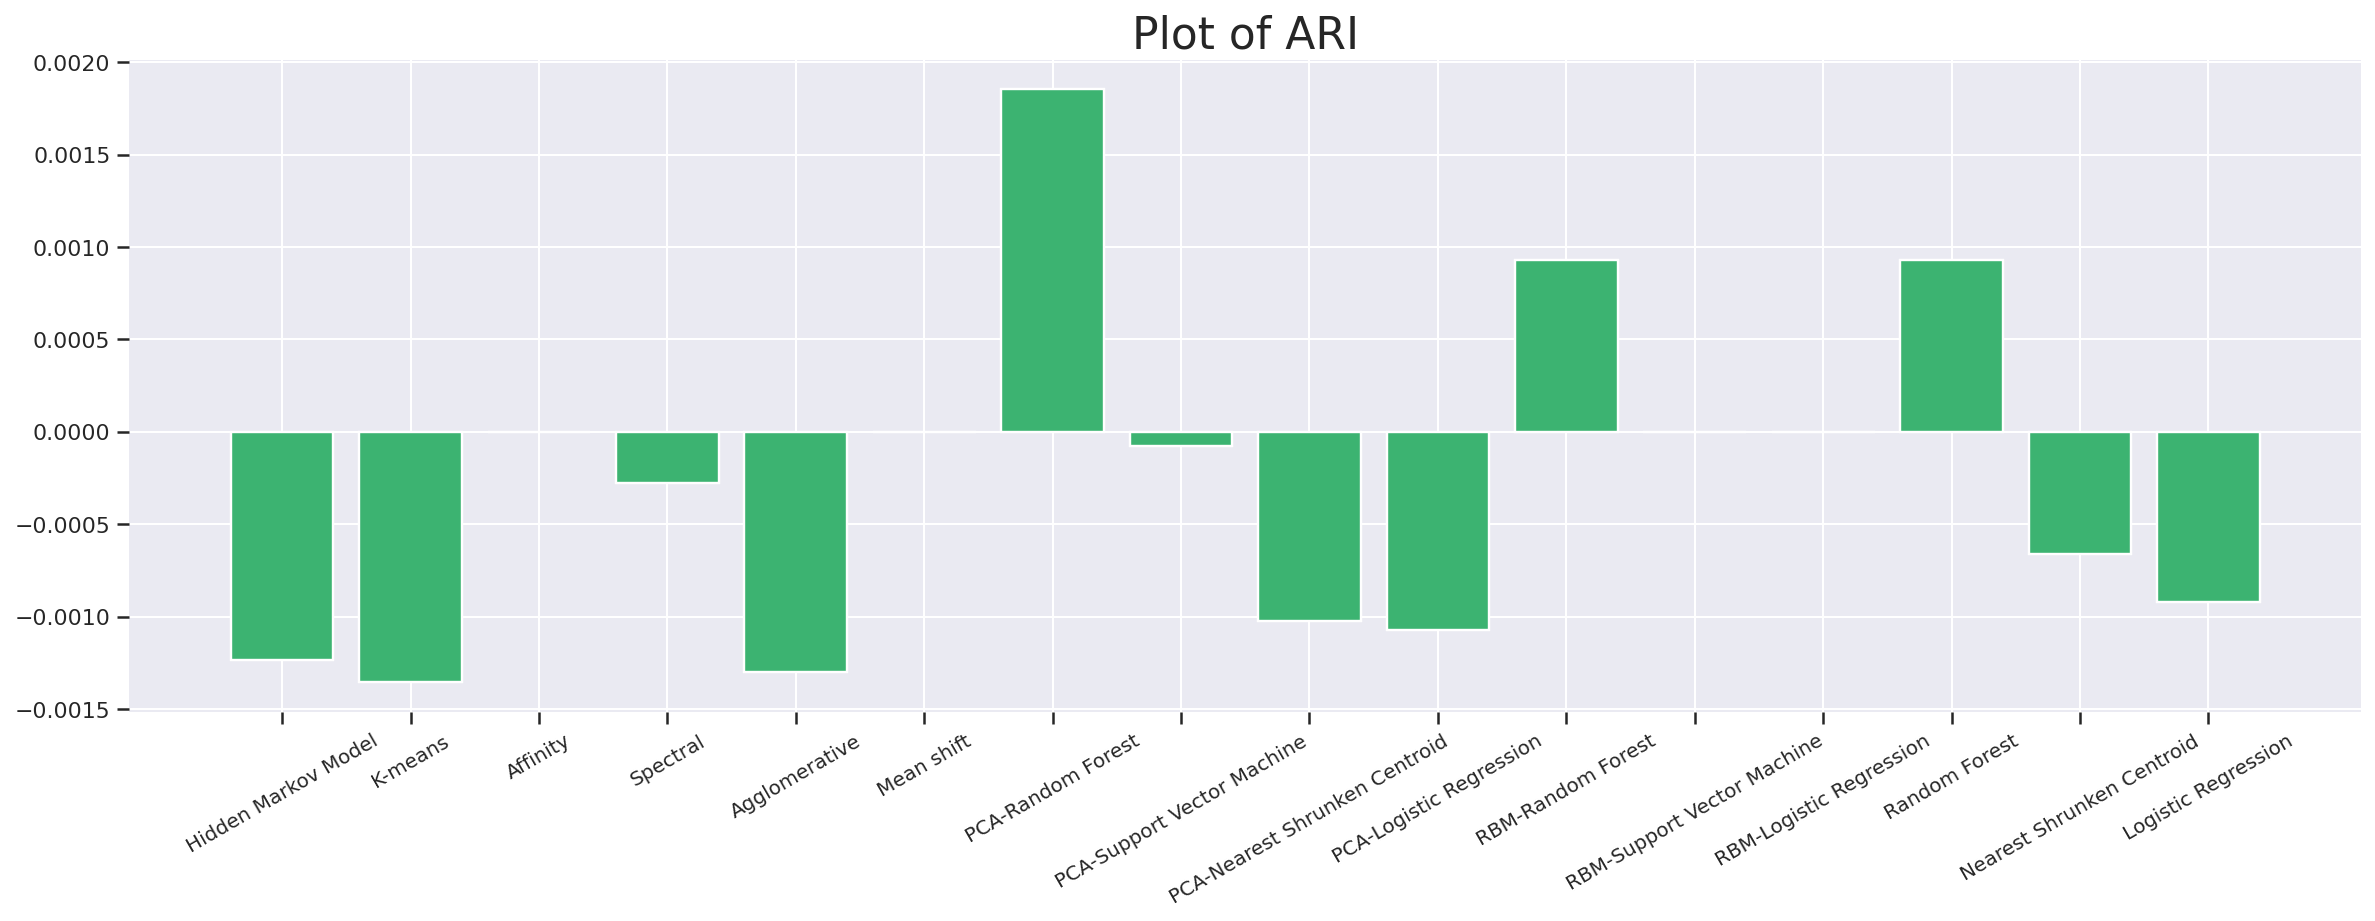

In [ ]:
generate_plot("Plot of ARI", ticks, results[resultnames[0]], 1)

### AMI graph

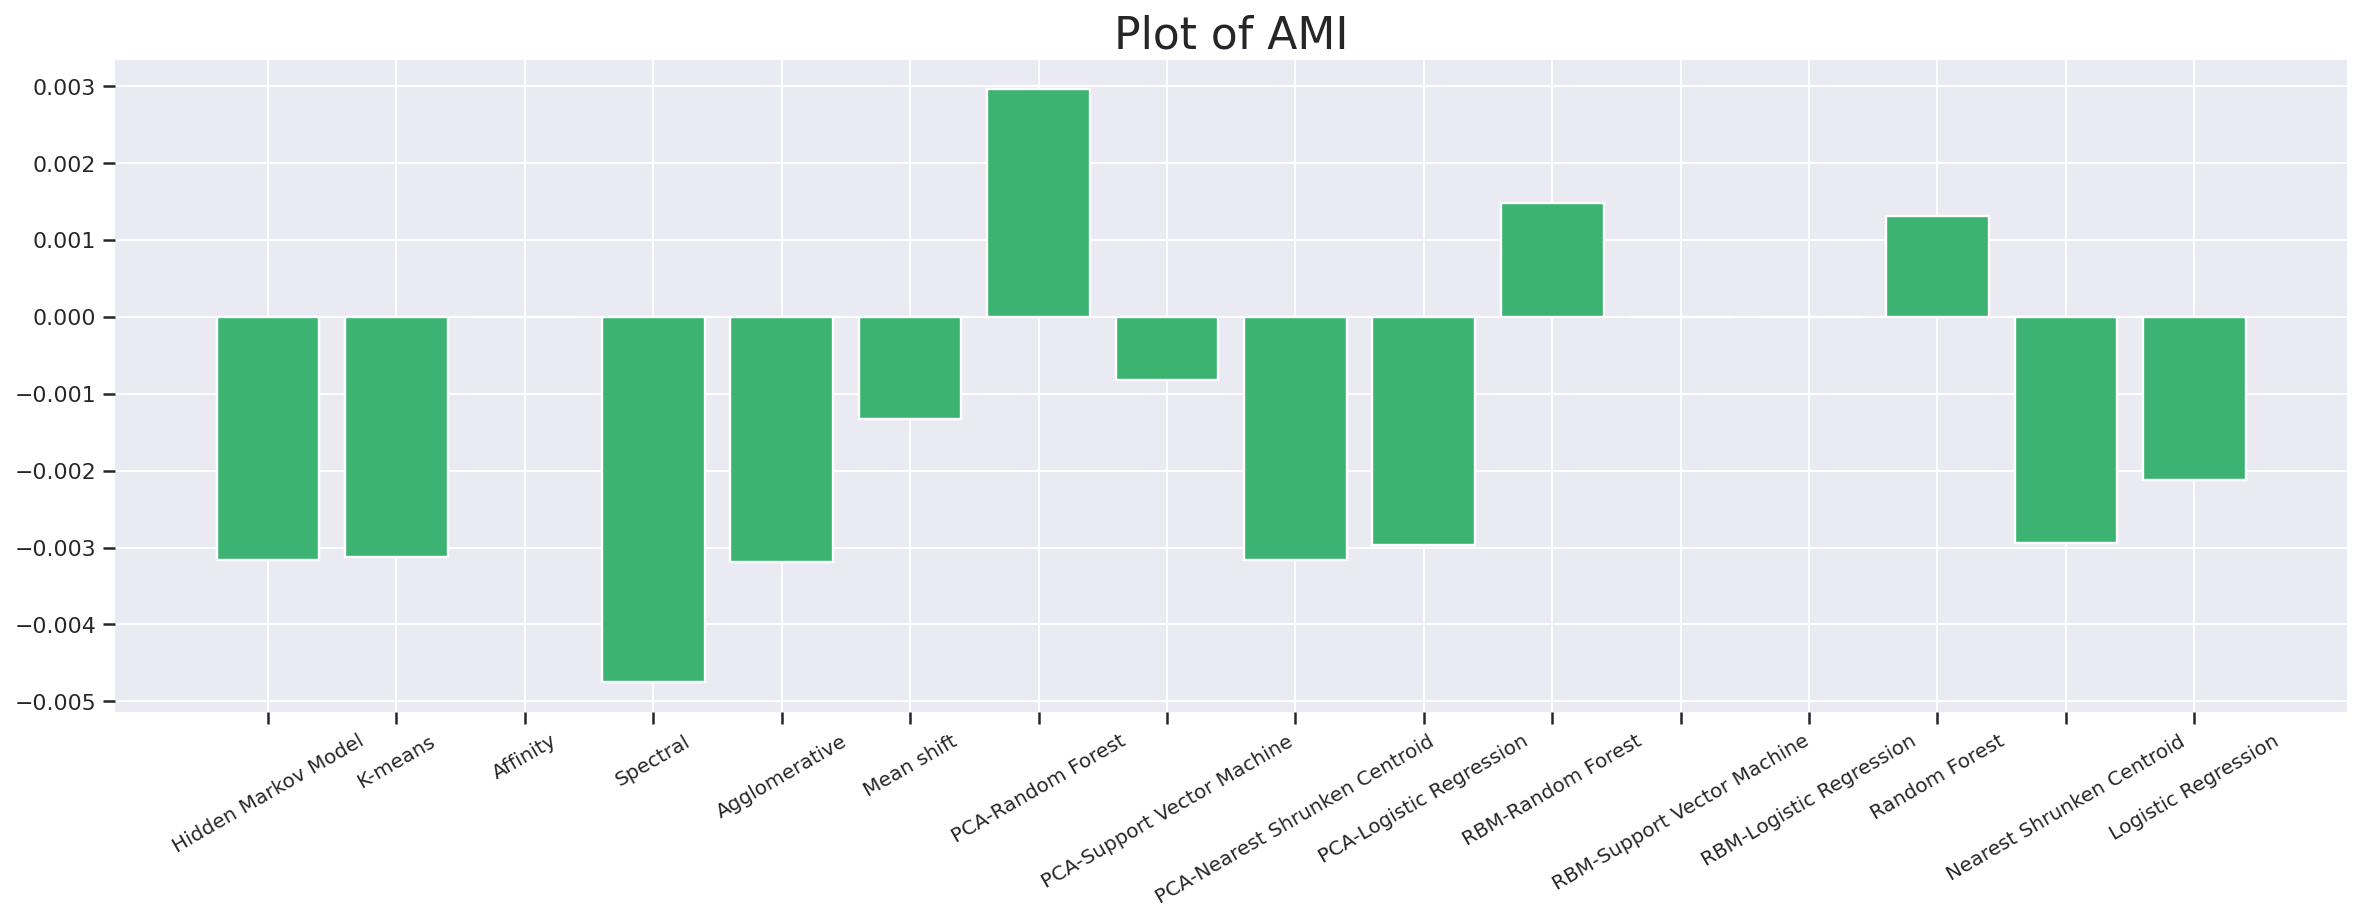

In [ ]:
generate_plot("Plot of AMI", ticks, results[resultnames[1]], 1)

### Homogenity graph

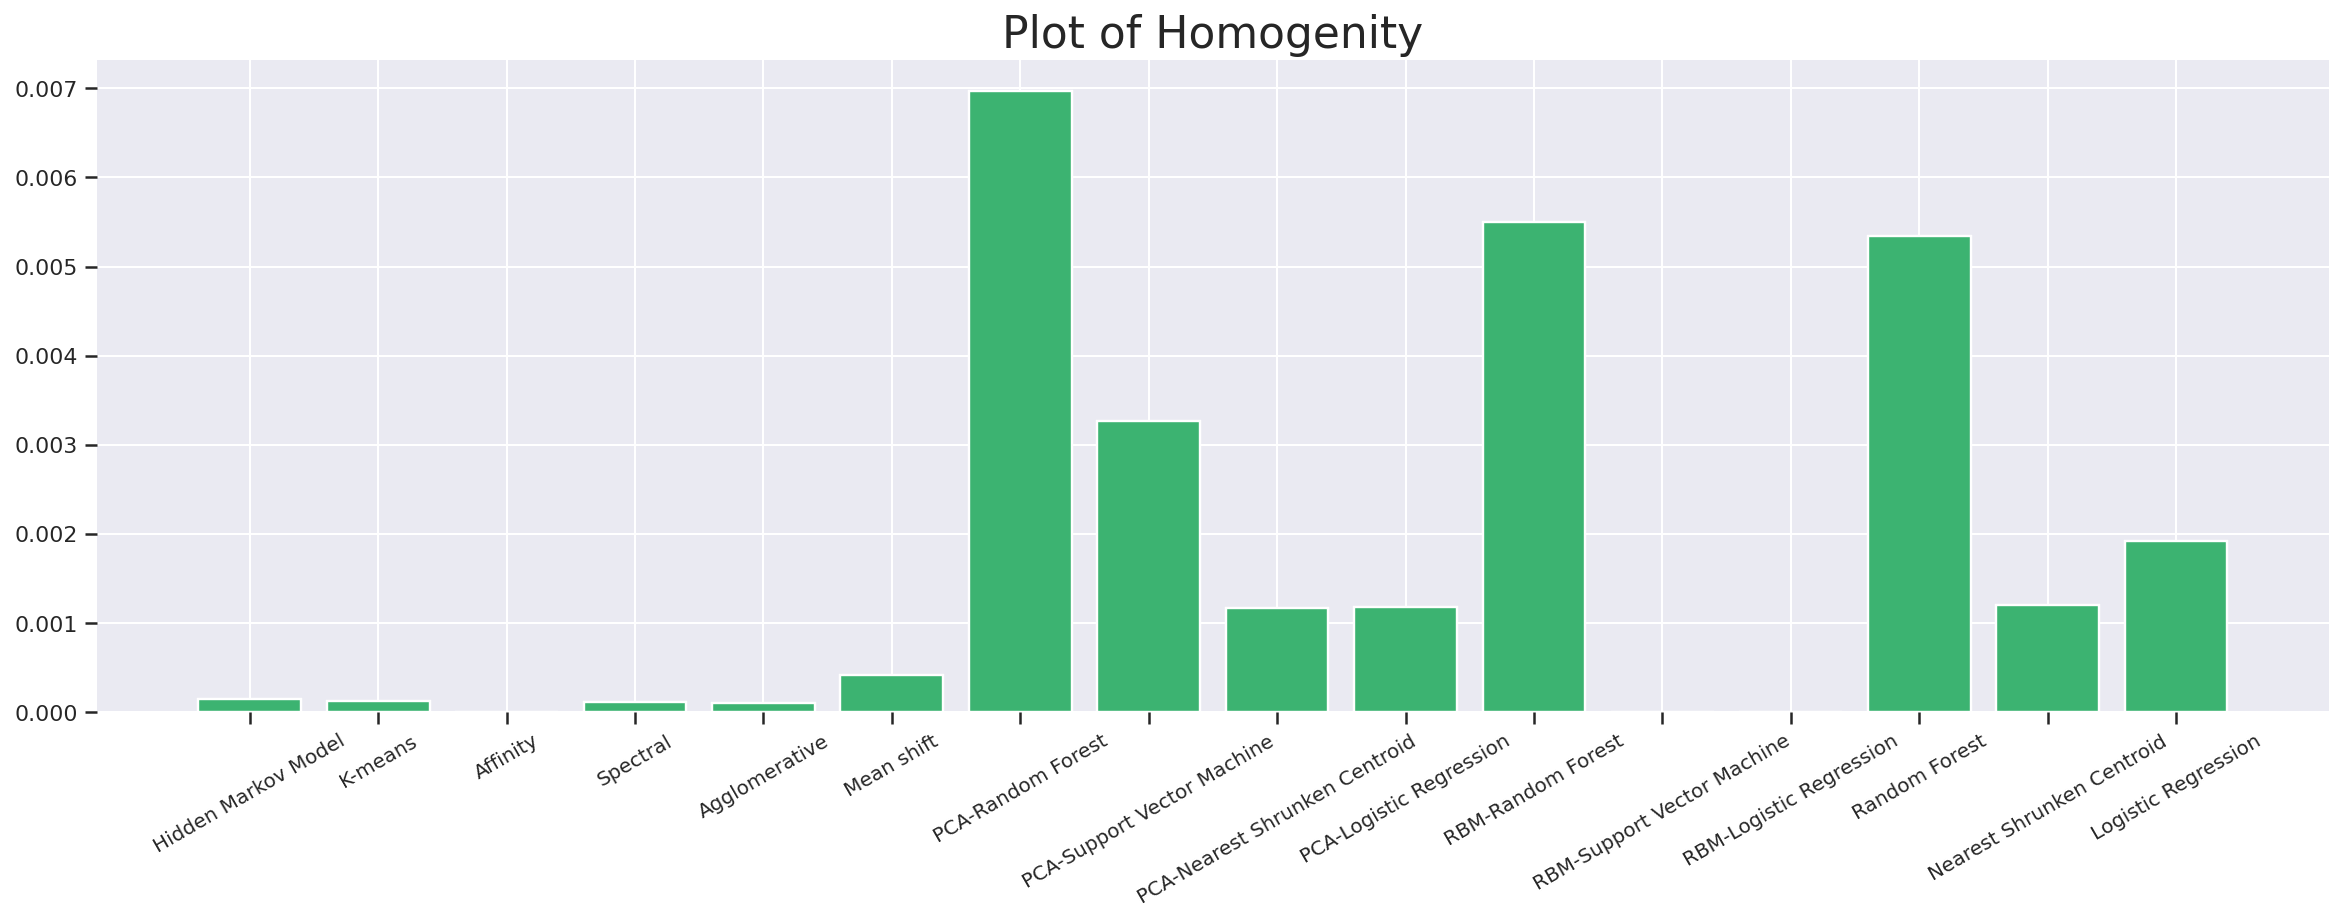

In [ ]:
generate_plot("Plot of Homogenity", ticks, results[resultnames[2]], 1)

### Completeness graph

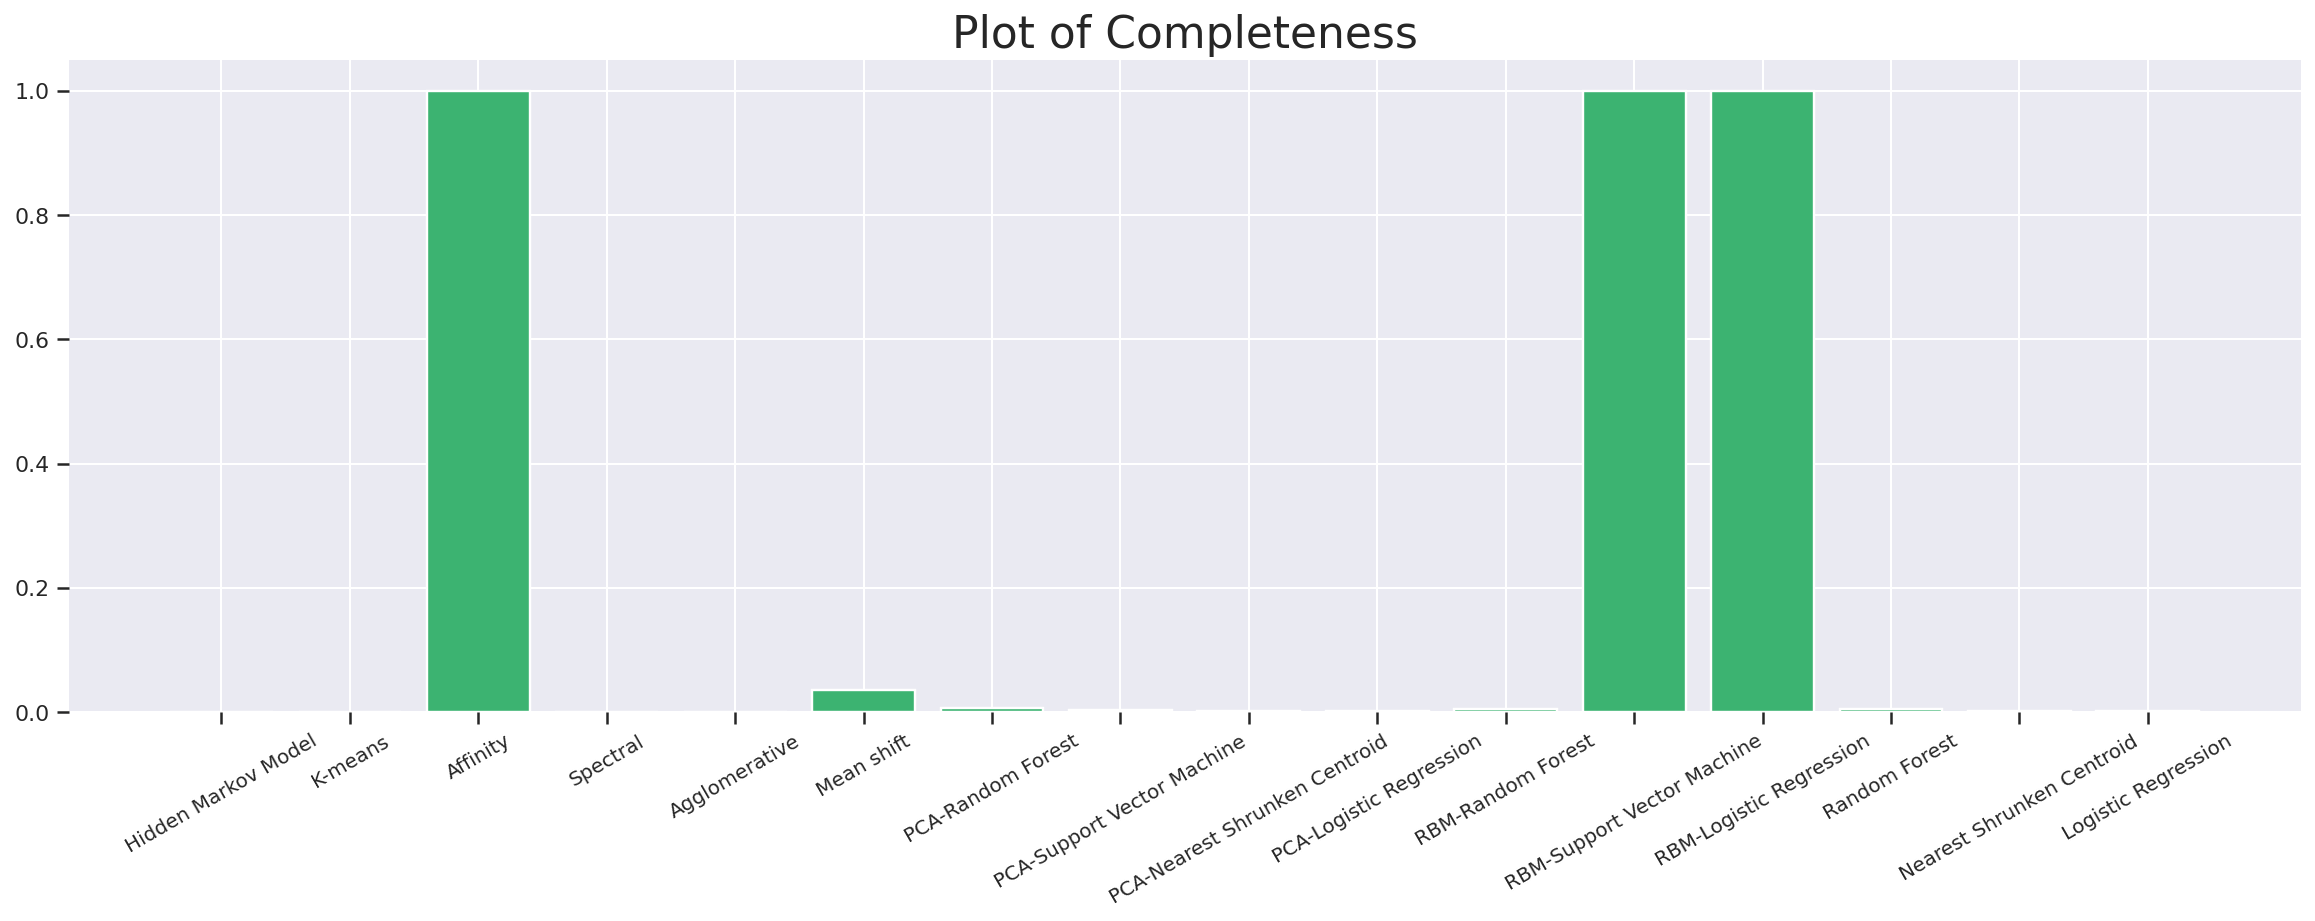

In [ ]:
generate_plot("Plot of Completeness", ticks, results[resultnames[3]], 1)

### V-measure graph

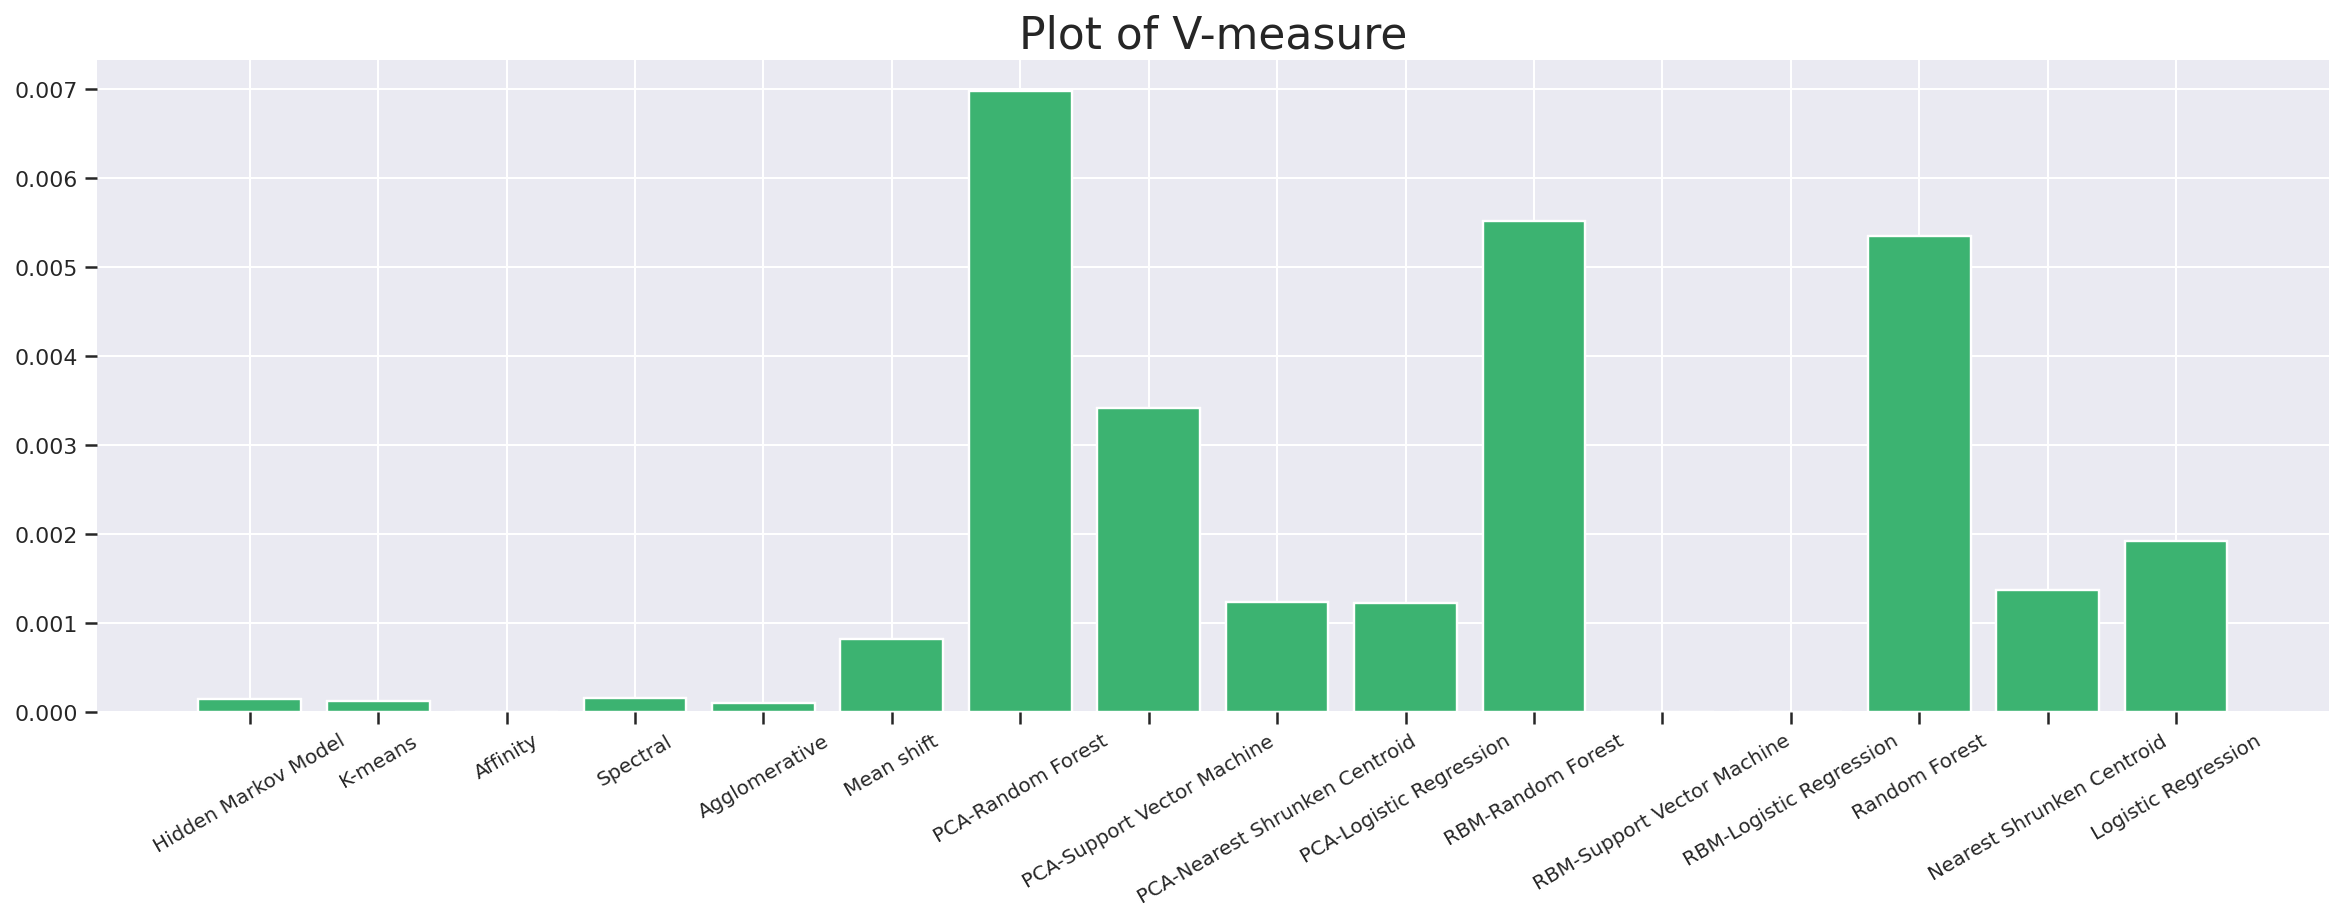

In [ ]:
generate_plot("Plot of V-measure", ticks, results[resultnames[4]], 1)

### Accuracy Score graph

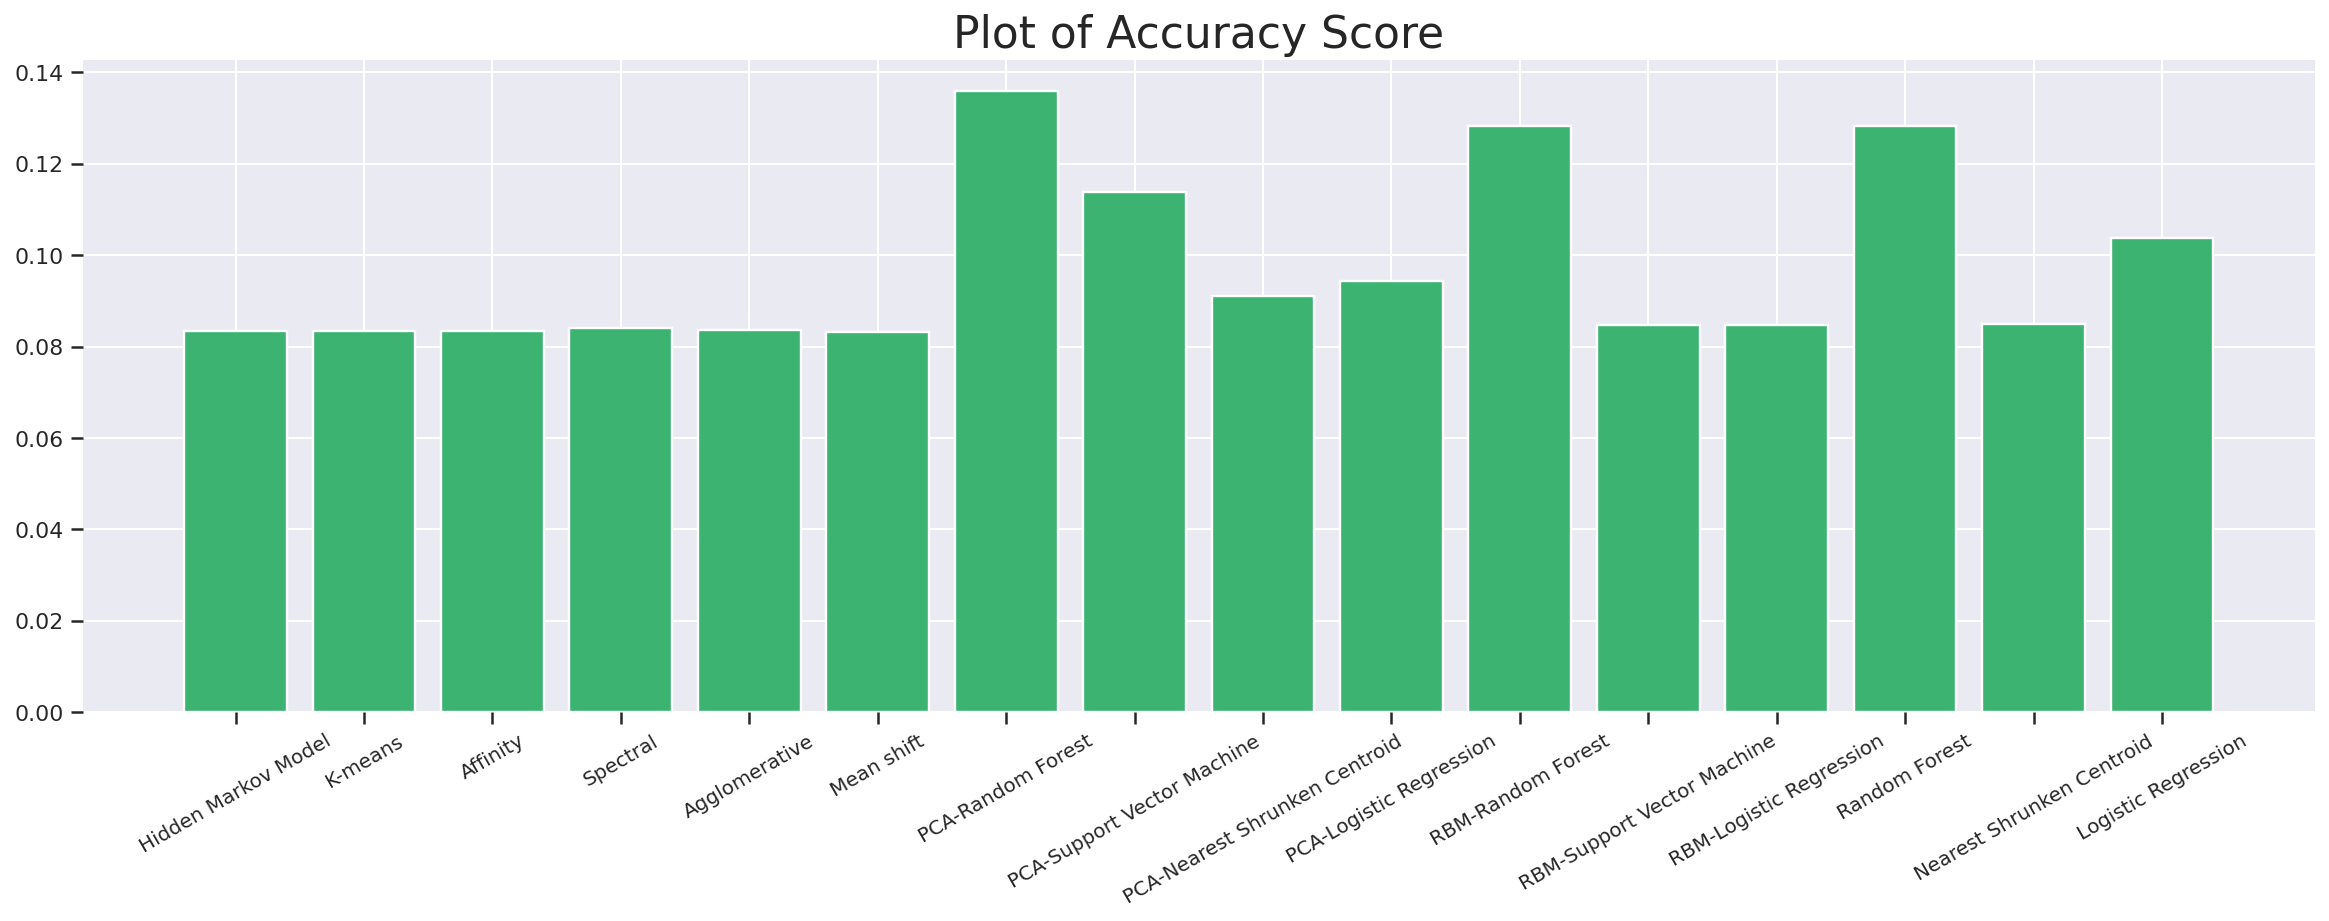

In [ ]:
generate_plot("Plot of Accuracy Score", ticks, results[resultnames[5]], 1)


### Mean squared error graph

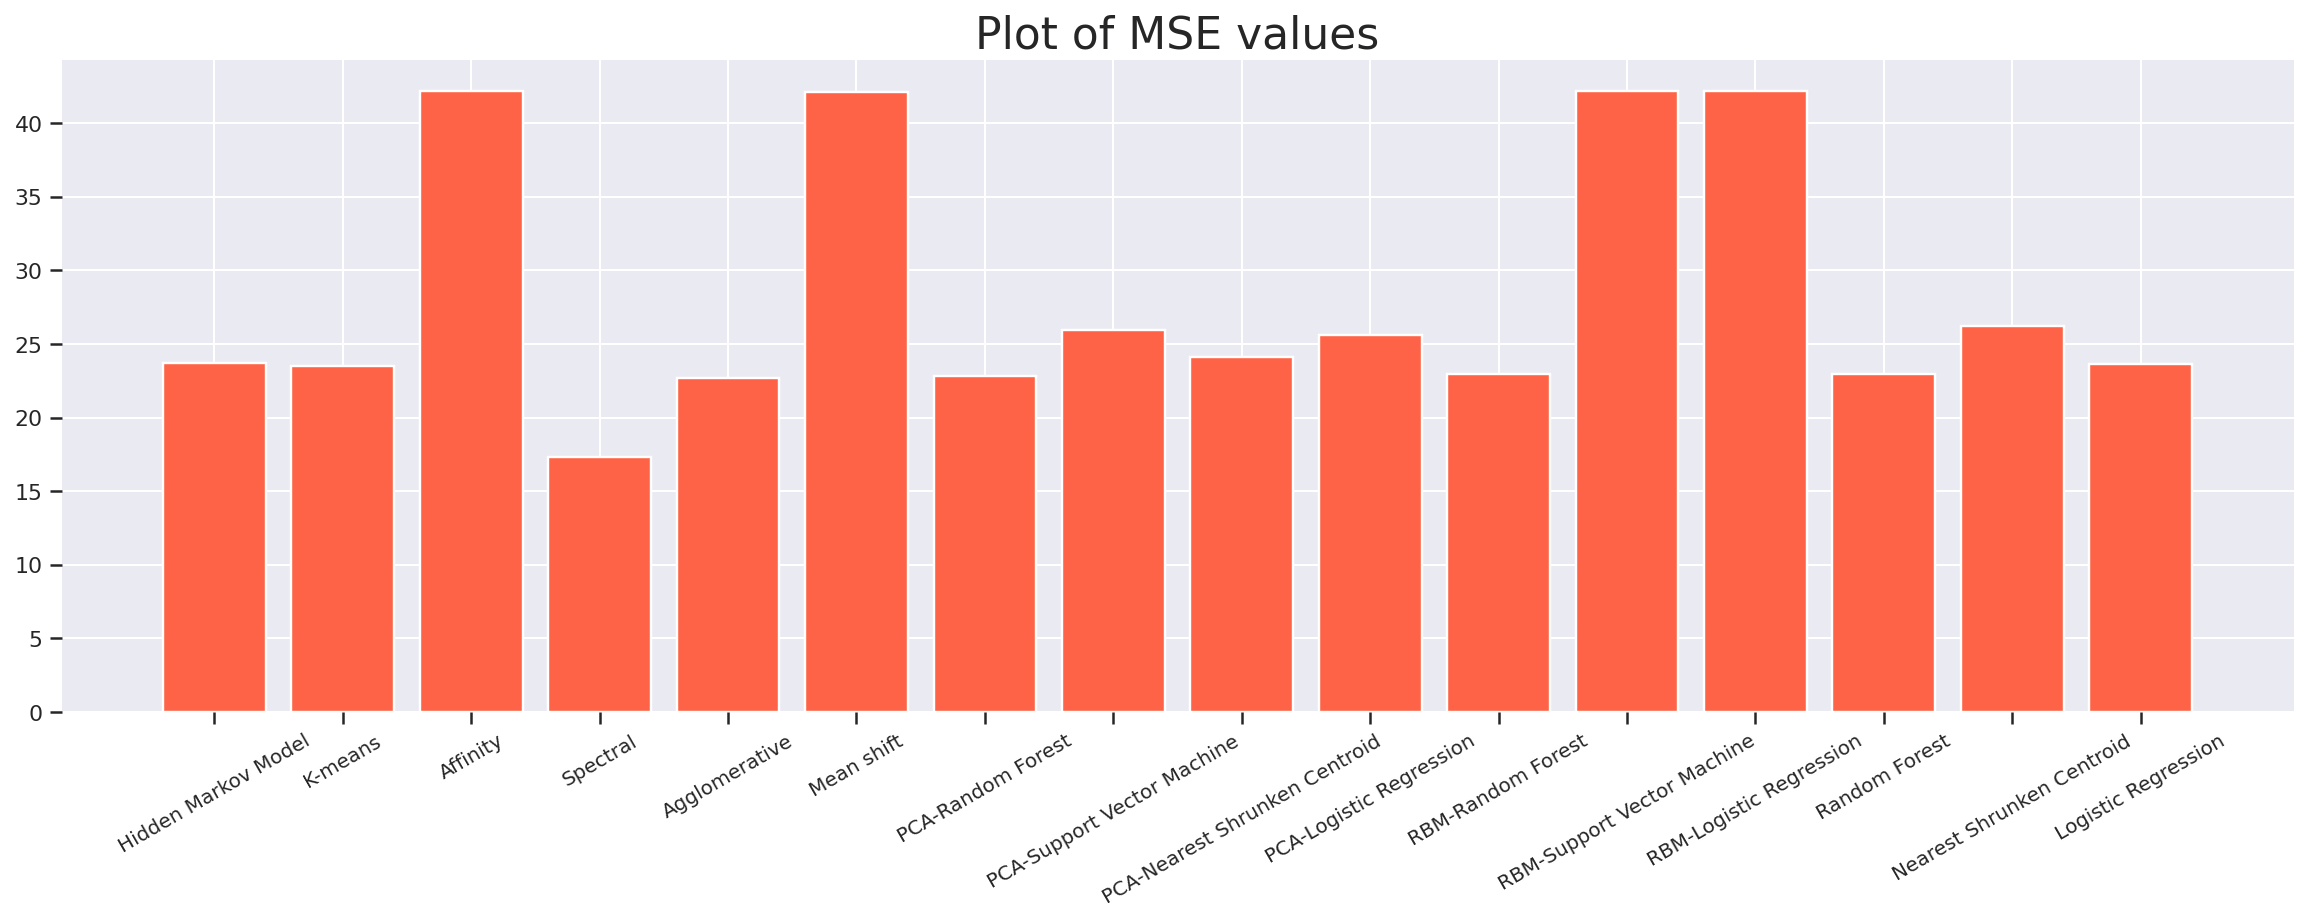

In [ ]:
generate_plot("Plot of MSE values", ticks, results[resultnames[6]], 2)

### Variance score graph

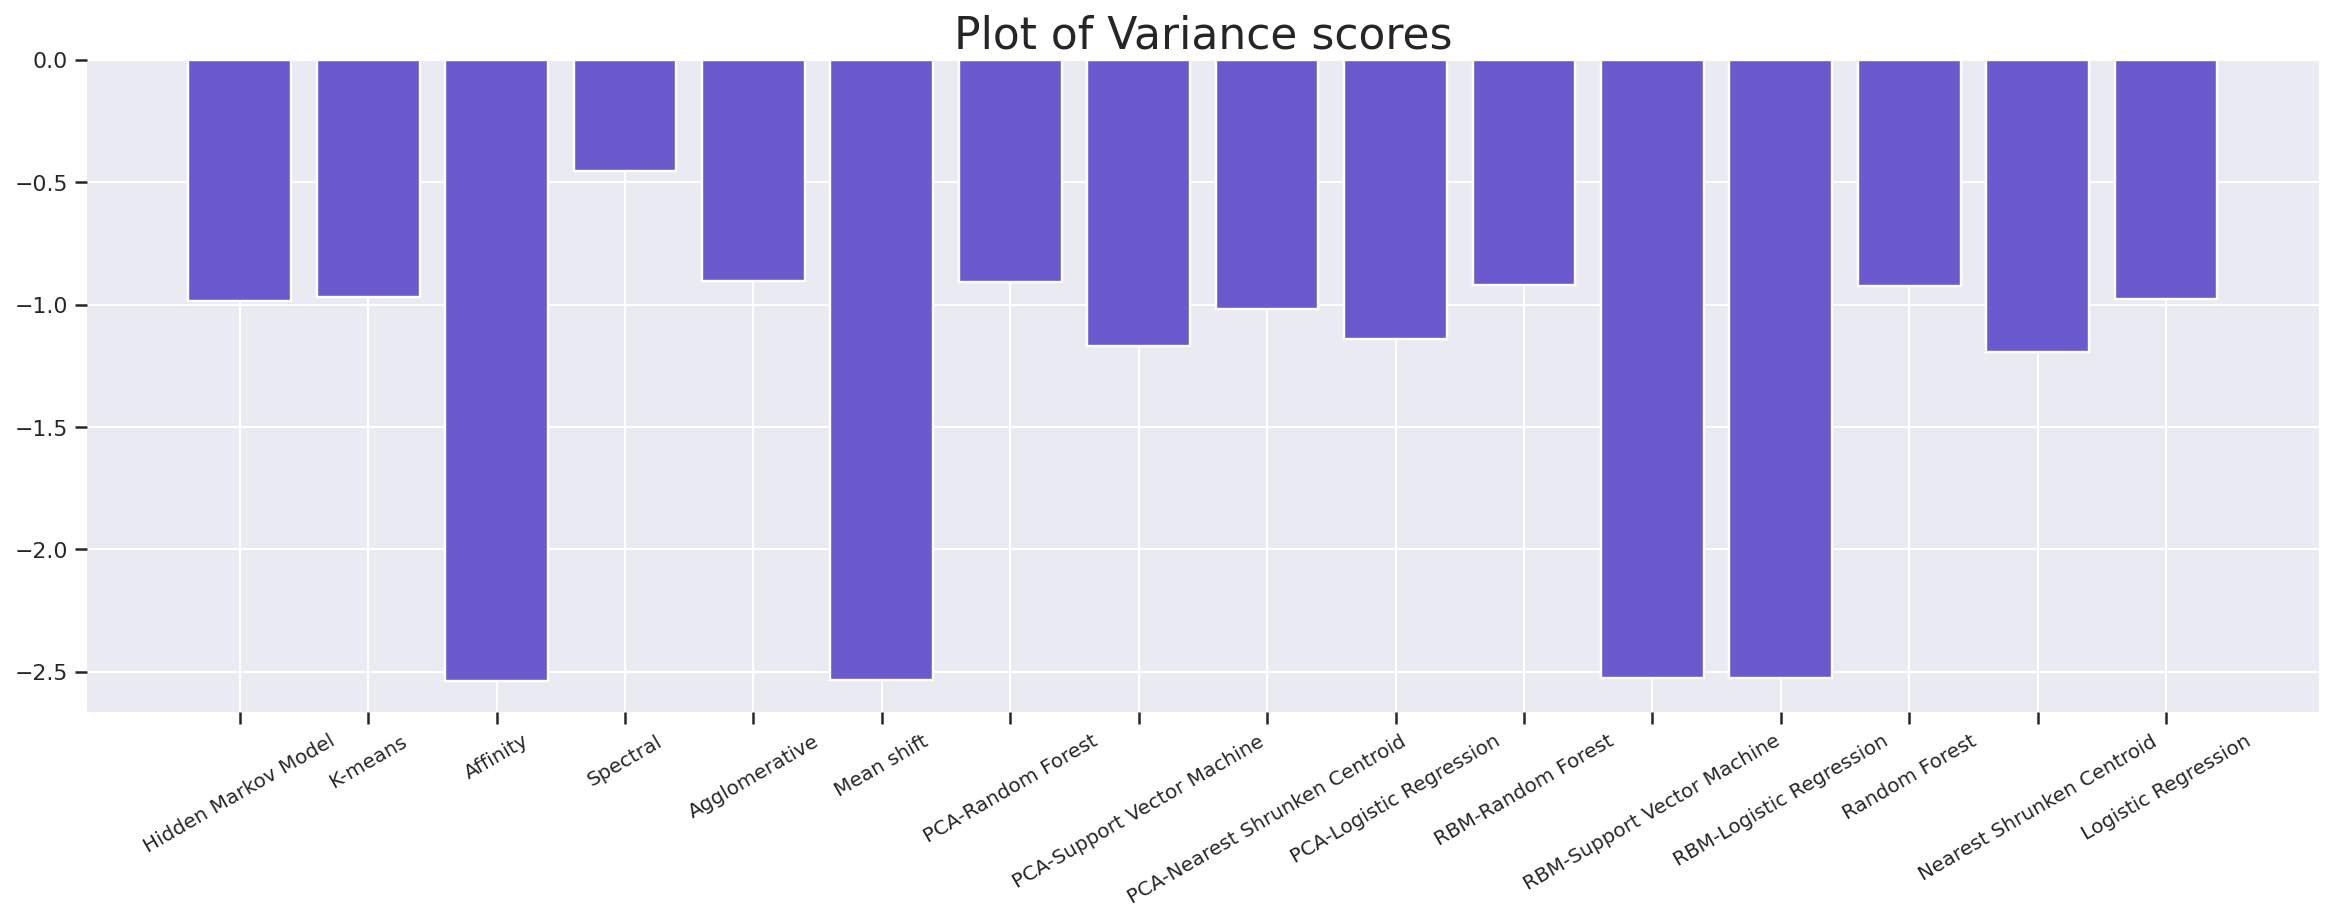

In [ ]:
generate_plot("Plot of Variance scores", ticks, results[resultnames[7]],0)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

def mlresults(modelname ,v, y_test,pred,X_test):
  scores = cross_val_score(v, X_test, Y_test, cv=10)
  le = preprocessing.LabelEncoder()
  target=le.fit_transform(y_test)
  predicted = le.fit_transform(pred)
  accuracy = metrics.accuracy_score(target, predicted)
  print('============================== {} Model Test Results =============================='.format(modelname))
  print()
  y_pred_prob_lr = BNB_Classifier.predict_proba(X_test)[:,1]
  fpr_lr, tpr_lr, thresholds_lr = roc_curve(target, y_pred_prob_lr)
  roc_auc_lr = auc(fpr_lr, tpr_lr)
  precision_lr, recall_lr, th_lr = precision_recall_curve(target, y_pred_prob_lr)
  # Plot ROC curve
  plt.figure(figsize=(15,10))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_lr, tpr_lr, label=modelname % roc_auc_lr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curves from the '+modelname, fontsize = 22)
  plt.legend(loc='best')
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/NetworkTrafficData/Results/Correlation Matrix Selected Features/Rocs of Models/'+modelname+'rocgraph.png')
  plt.show()
  accuracy = metrics.accuracy_score(target, predicted)
  mse=mean_squared_error(target, predicted)
  mae = metrics.mean_absolute_error(target, predicted)
  rs=r2_score(target, predicted)
  print("Cross Validation Mean Score:" "\n", scores.mean())
  print()
  print("Model Accuracy:" "\n", accuracy)
  print()
  print("Mean squared error: ", mse)
  print()
  print('Variance score: %.2f' % rs)
  print()

  return scores.mean(),accuracy,mse,mae,rs

============================== RBM-Random Forest Model Test Results ==============================



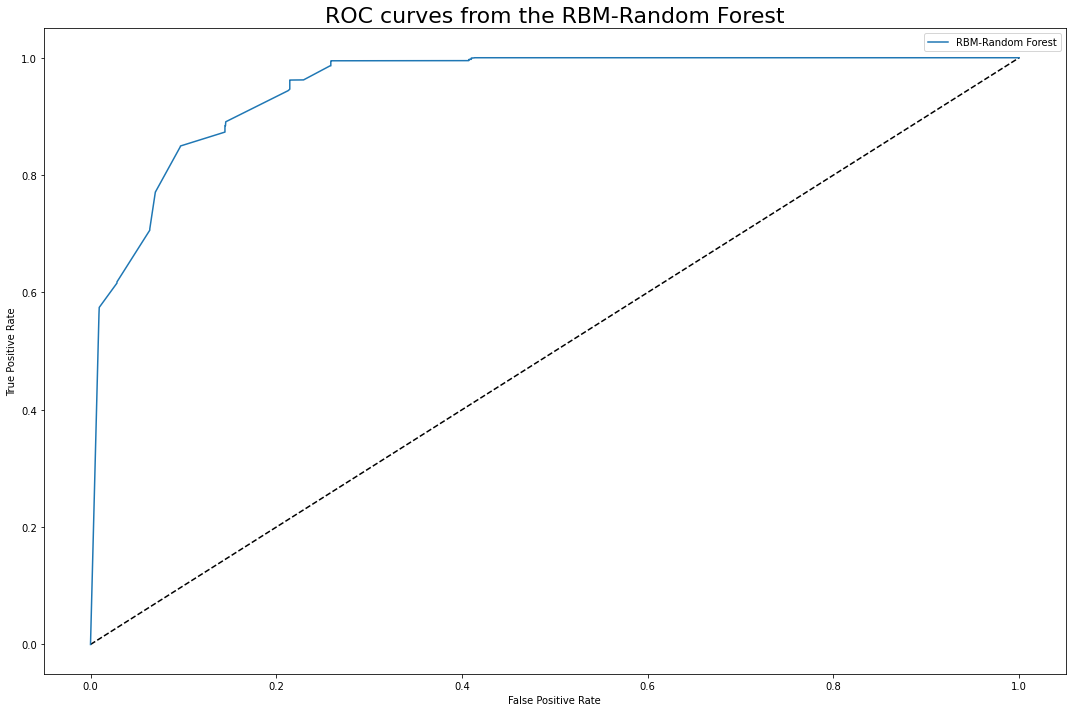

Cross Validation Mean Score:
 0.8799959704264338

Model Accuracy:
 0.8799947075946017

Mean squared error:  0.12000529240539826

Variance score: 0.52

============================== PCA-Support Vector Machine Model Test Results ==============================



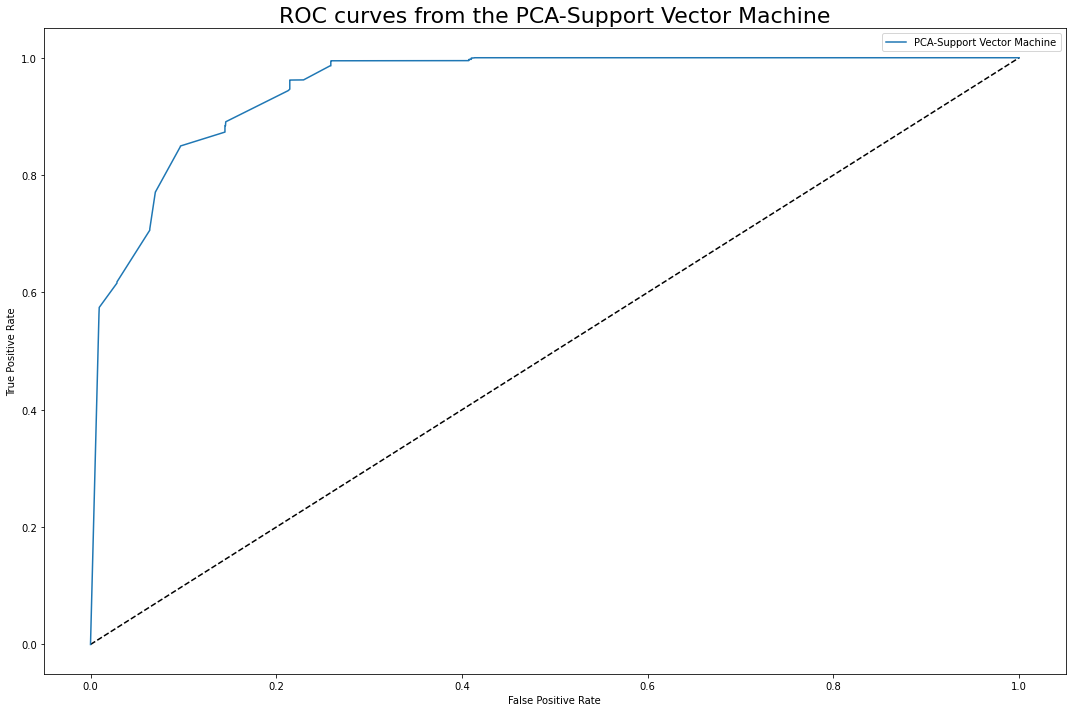

Cross Validation Mean Score:
 0.9372840674165177

Model Accuracy:
 0.945885154802858

Mean squared error:  0.0541148451971421

Variance score: 0.78

============================== K Mean Clustering Model Test Results ==============================



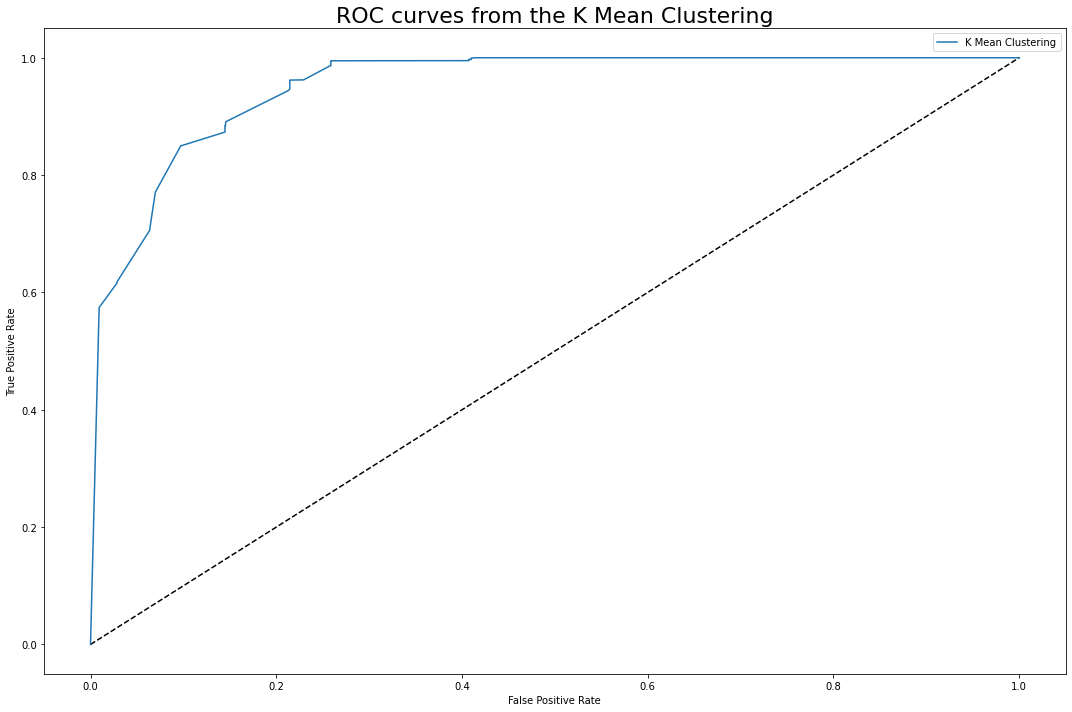

Cross Validation Mean Score:
 0.9395344966537019

Model Accuracy:
 0.9498544588515481

Mean squared error:  0.050145541148451975

Variance score: 0.80

============================== PCA with Logistic Regression Model Test Results ==============================



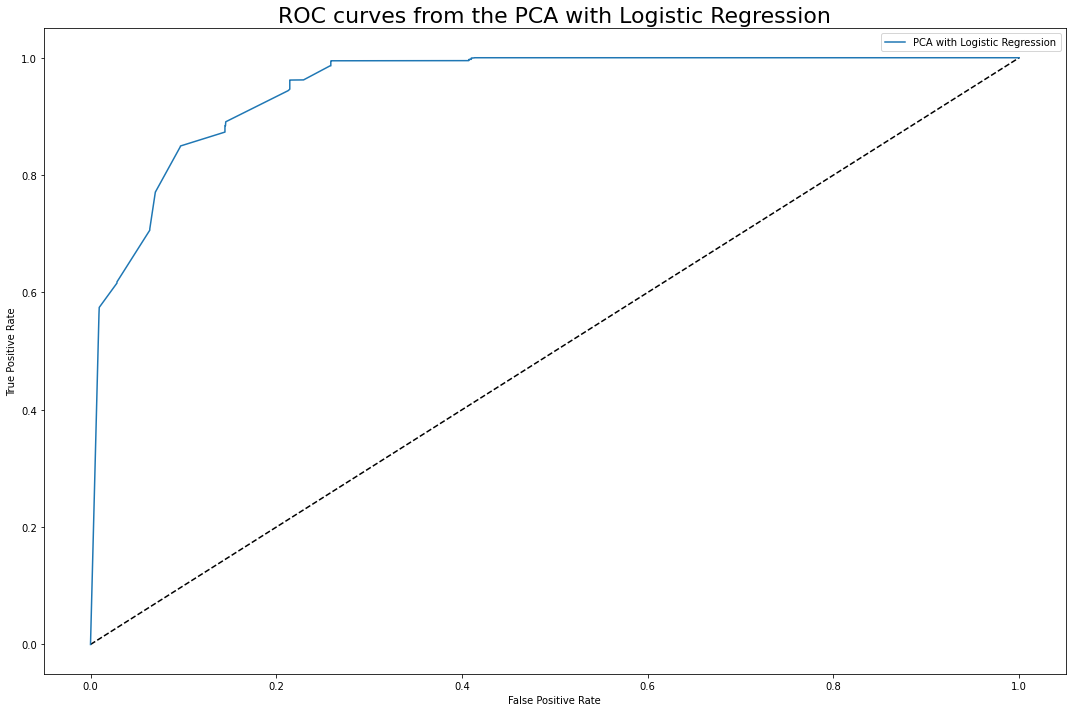

Cross Validation Mean Score:
 0.8944172886225866

Model Accuracy:
 0.8940195818999735

Mean squared error:  0.10598041810002647

Variance score: 0.57

============================== Hidden Markov Model Model Test Results ==============================



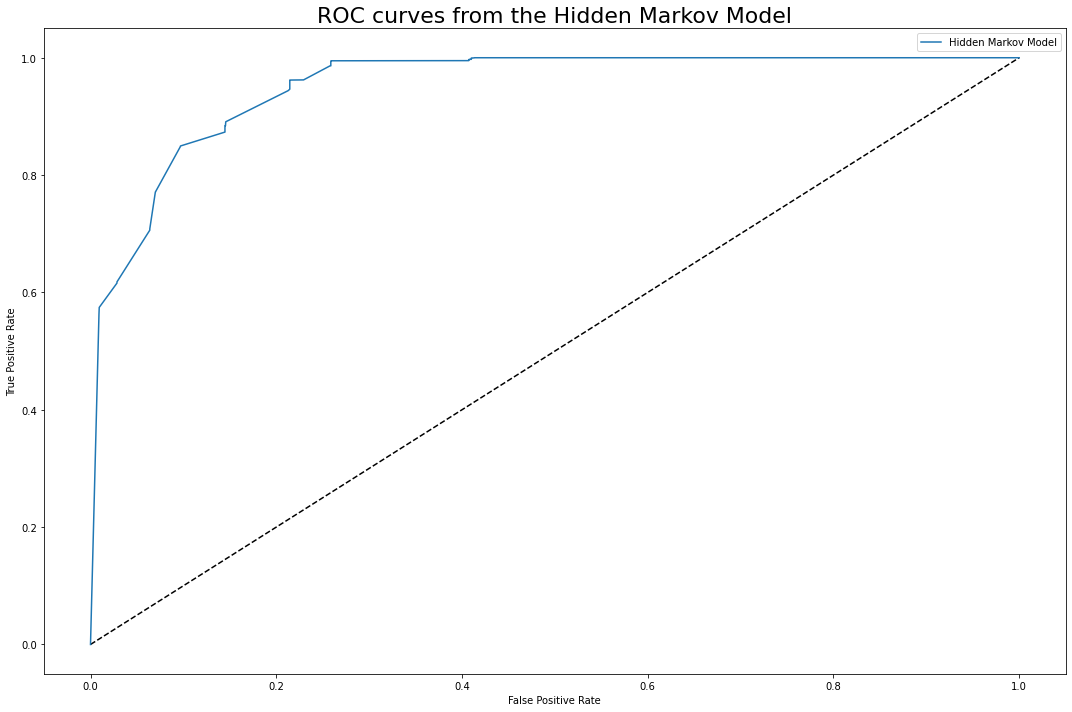

Cross Validation Mean Score:
 0.946017379725989

Model Accuracy:
 0.9522360412807621

Mean squared error:  0.047763958719237894

Variance score: 0.81

============================== PCA with Random Forest Model Test Results ==============================



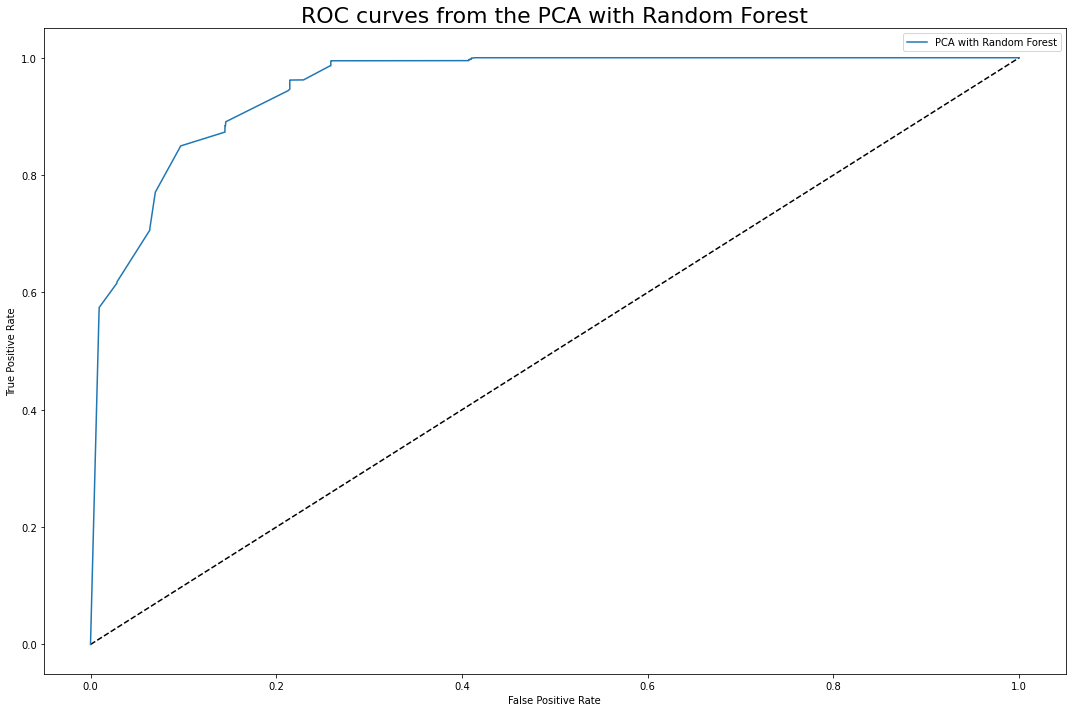

Cross Validation Mean Score:
 0.9483983321069414

Model Accuracy:
 0.9530299020905001

Mean squared error:  0.04697009790949987

Variance score: 0.81



In [ ]:
from sklearn import metrics

models = []
models.append(('RBM-Random Forest', BNB_Classifier))
models.append(('PCA-Support Vector Machine', DTC_Classifier))
models.append(('K Mean Clustering', KNN_Classifier))
models.append(('PCA with Logistic Regression', LGR_Classifier))
models.append(('Hidden Markov Model', Basicbagging))
models.append(('PCA with Random Forest', Genbagging ))
accuracy_score=list()
mse_values=list()
variance_score=list()
modelnames= list()
resultscore=pd.DataFrame(columns=['Model','Cross Validation Score','Accuracy','Mean Square Error','Mean Absolute Error','Root2 Score'])
j=0
for i, v in models:
    scores,accuracy,mse,mae,rs=mlresults(i,v, Y_test,v.predict(X_test),X_test)  
    accuracy_score.append(accuracy)
    mse_values.append(mse)
    variance_score.append(rs)
    resultscore.loc[j] =[i,scores,accuracy,mse,mae,rs]
    j=j+1
    modelnames.append(i)

In [ ]:
resultscore.to_csv('/content/drive/MyDrive/NetworkTrafficData/Results/Correlation Matrix Selected Features/Resulttable.csv')
resultscore

Model  Cross Validation Score  Accuracy  Mean Square Error  Mean Absolute Error  Root2 Score
0             RBM-Random Forest                0.879996  0.879995           0.120005             0.120005     0.517516
1    PCA-Support Vector Machine                0.937284  0.945885           0.054115             0.054115     0.782430
2             K Mean Clustering                0.939534  0.949854           0.050146             0.050146     0.798389
3  PCA with Logistic Regression                0.894417  0.894020           0.105980             0.105980     0.573903
4           Hidden Markov Model                0.946017  0.952236           0.047764             0.047764     0.807964
5        PCA with Random Forest                0.948398  0.953030           0.046970             0.046970     0.811156

### Function for genesentiments the graph

In [ ]:
def generate_plot(title, ticks, dataset, color_number):
    colors = ["slateblue", "mediumseagreen", "tomato"]
    plt.figure(figsize=(20, 10))
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    plt.ylabel('Score', size=14)
    plt.xlabel('Models', size=14)
    plt.xticks(np.arange(len(ticks)), ticks, fontsize=10, rotation=30)
    plt.title(title, fontsize = 22)
    plt.bar(ticks, dataset, linewidth=1.2, color=colors[color_number])
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/NetworkTrafficData/Results/Correlation Matrix Selected Features/'+title+'graph.png')

### Cross Validation Score

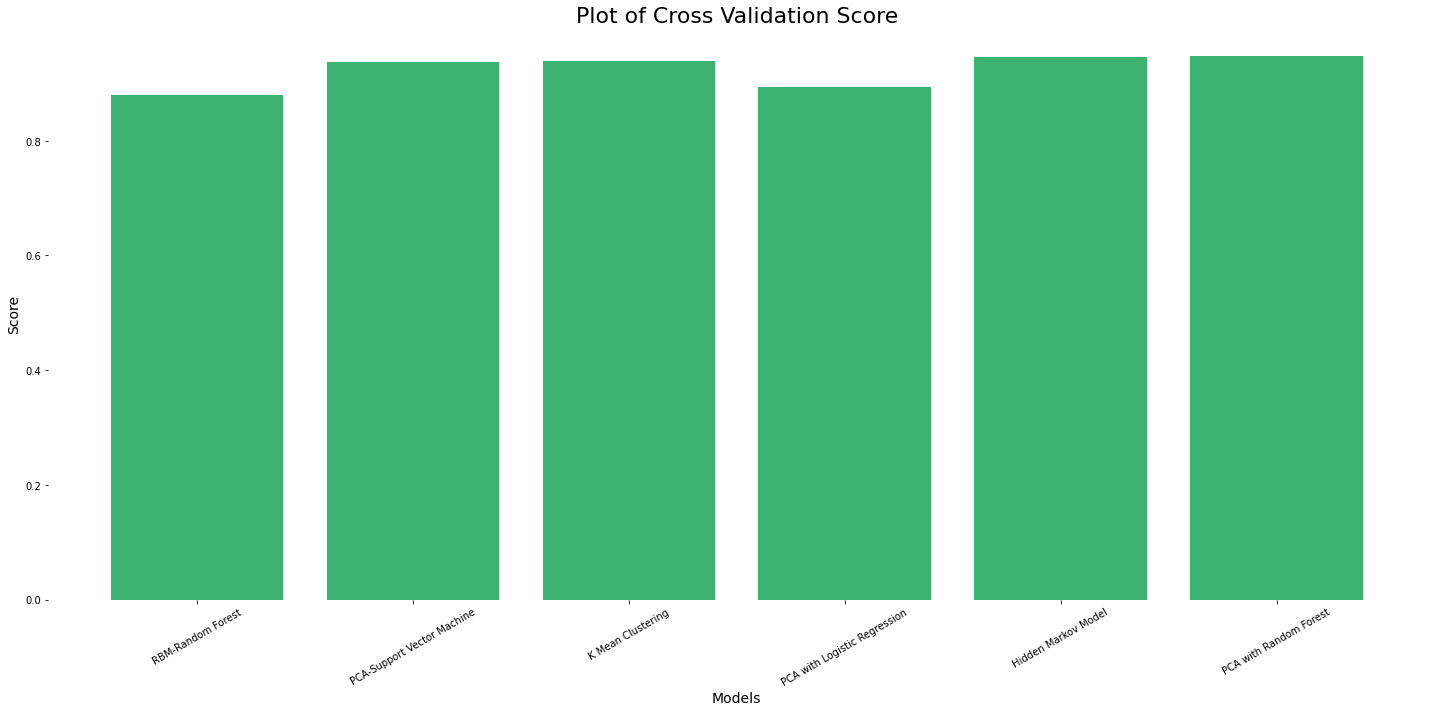

In [ ]:
ticks = modelnames
generate_plot("Plot of Cross Validation Score", ticks, resultscore['Cross Validation Score'], 1)

### Accuracy graph

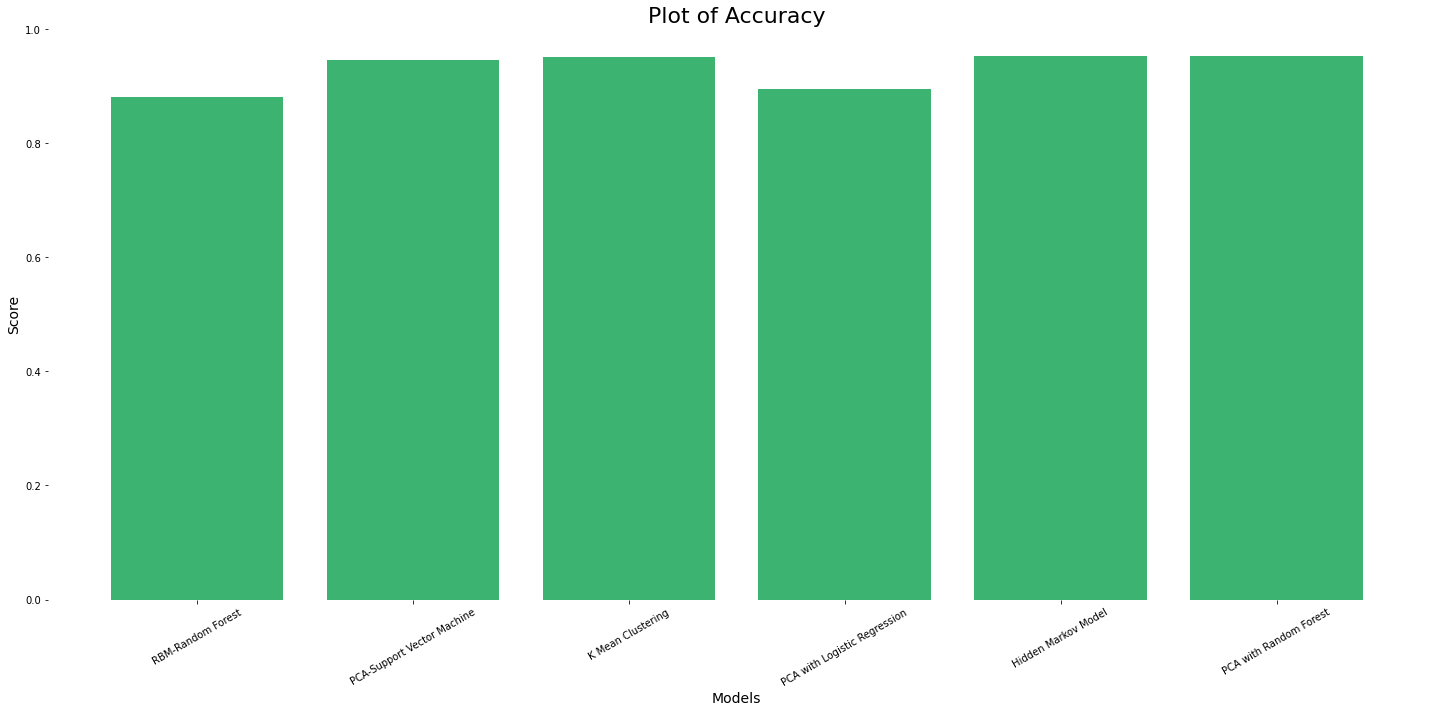

In [ ]:
ticks = modelnames
generate_plot("Plot of Accuracy", ticks, resultscore['Accuracy'], 1)

### Mean squared error graph

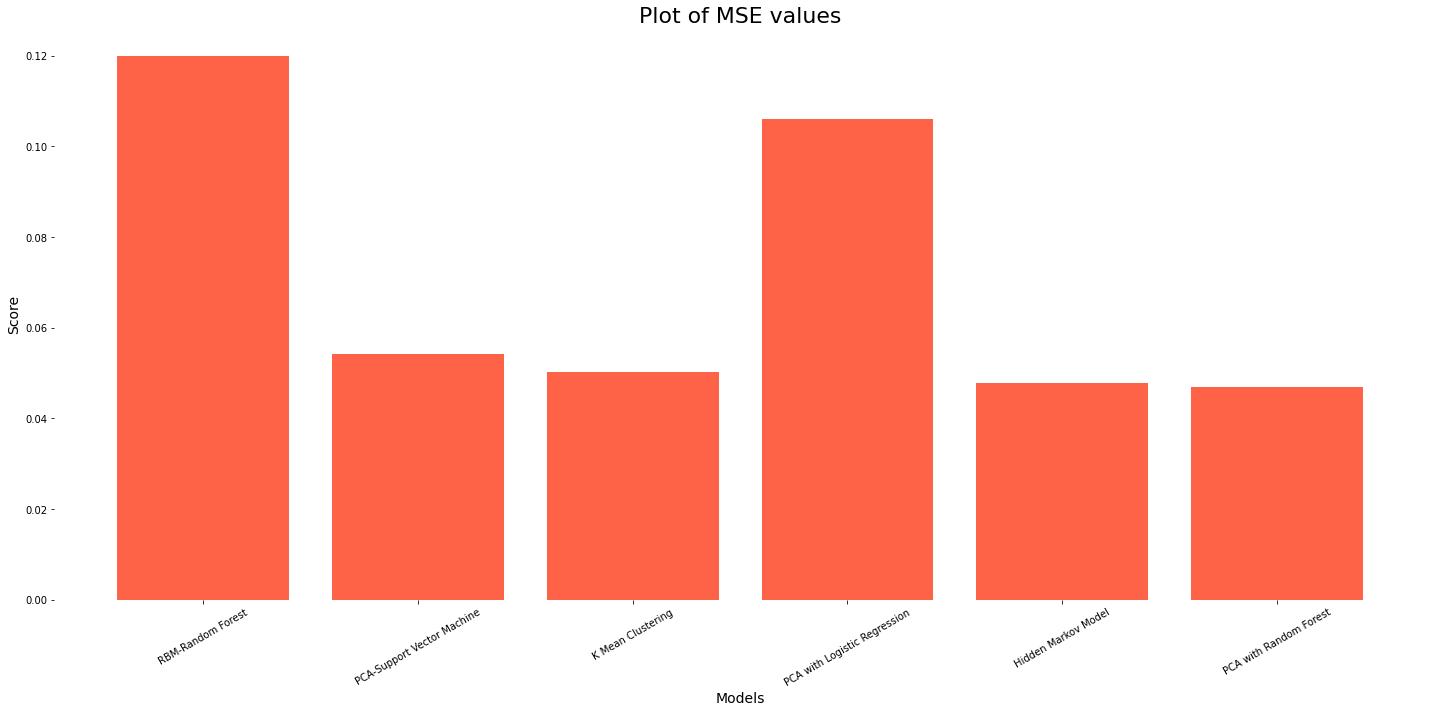

In [ ]:
ticks = modelnames
generate_plot("Plot of MSE values", ticks, resultscore['Mean Square Error'], 2)

### Mean Absolute Error graph

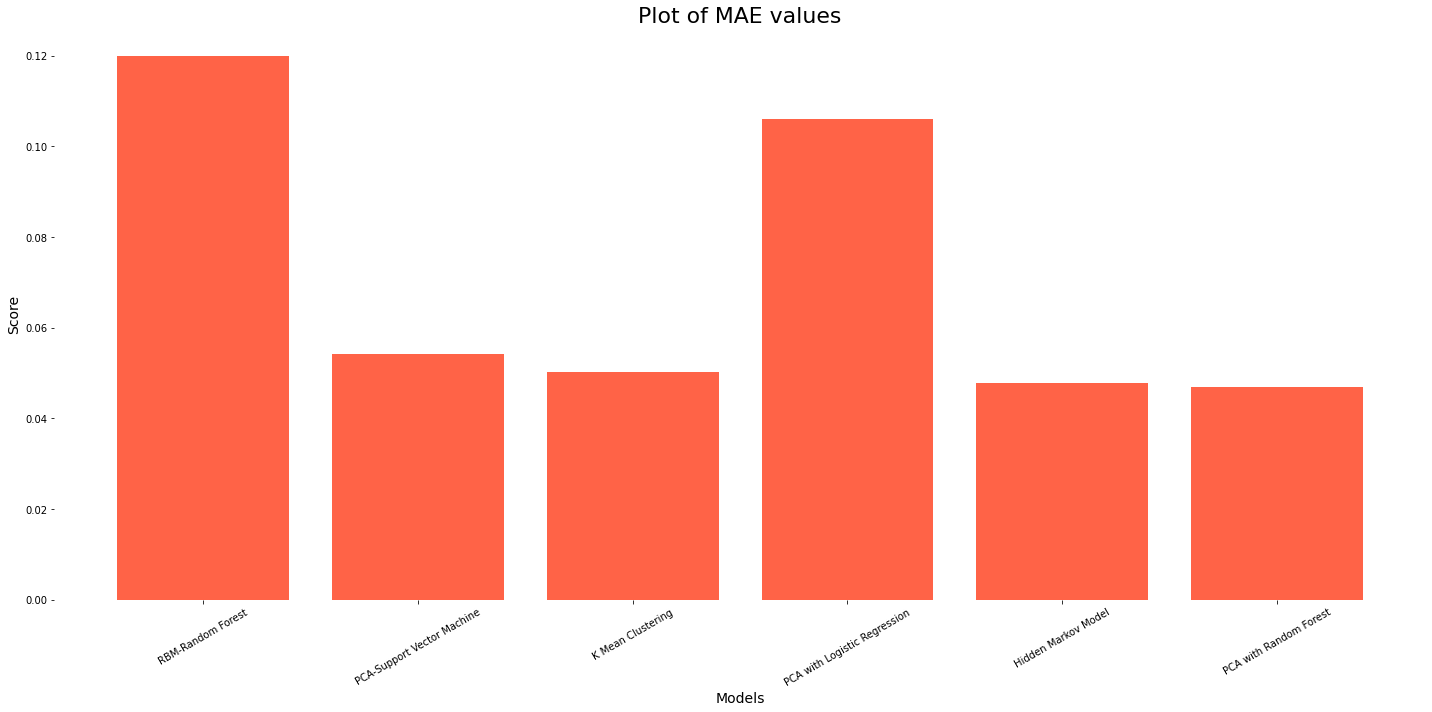

In [ ]:
ticks = modelnames
generate_plot("Plot of MAE values", ticks, resultscore['Mean Absolute Error'], 2)

### Root Square score graph

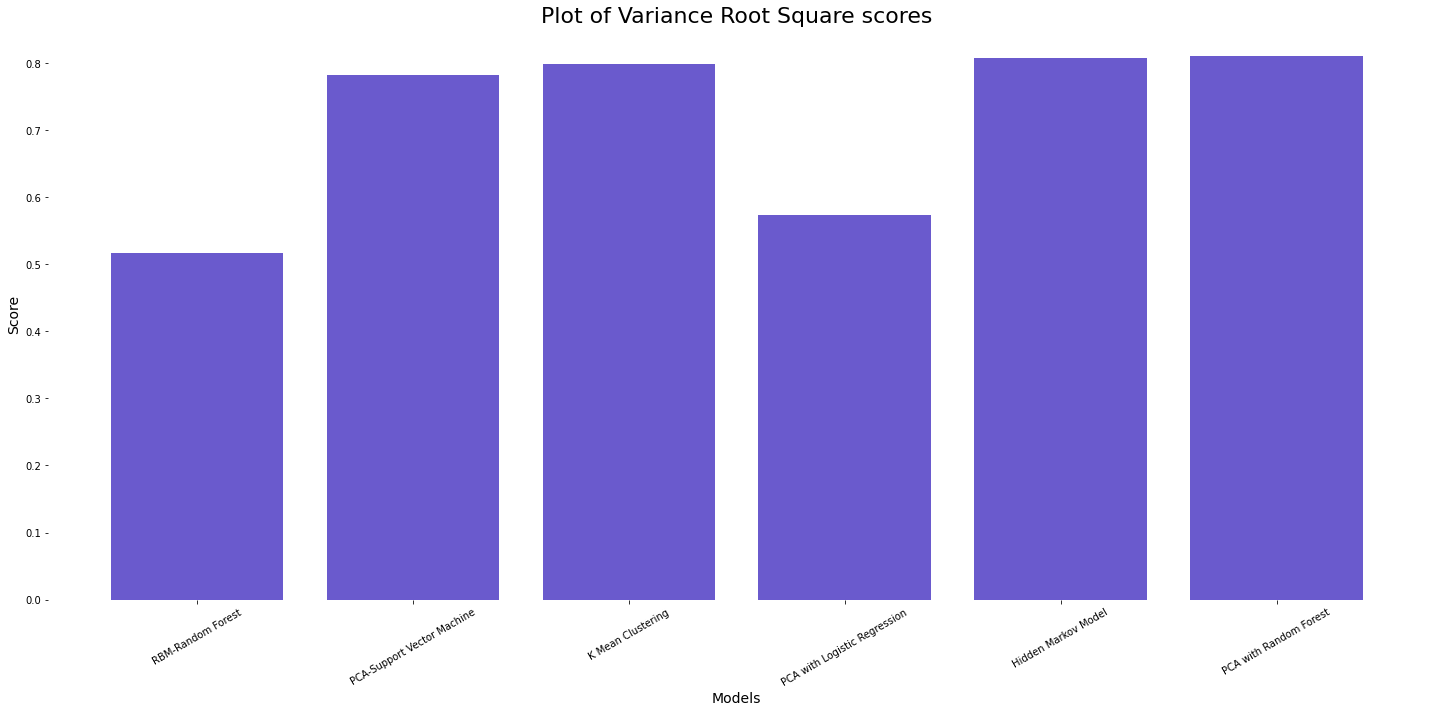

In [ ]:
ticks = modelnames
generate_plot("Plot of Variance Root Square scores", ticks, resultscore['Root2 Score'],0)

In [ ]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)
# Logistic regression
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_test=le.fit_transform(Y_test)
classes= list(le.classes_)
y_pred_prob_lr = BNB_Classifier.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(Y_test, y_pred_prob_lr)

# SVM with rbf
y_pred_prob_SVMrbf = DTC_Classifier.predict_proba(X_test)[:,1]
fpr_SVMrbf, tpr_SVMrbf, thresholds_SVMrbf = roc_curve(Y_test, y_pred_prob_SVMrbf)
roc_auc_SVMrbf = auc(fpr_SVMrbf, tpr_SVMrbf)
precision_SVMrbf, recall_SVMrbf, th_SVMrbf = precision_recall_curve(Y_test, y_pred_prob_SVMrbf)

# SVM with linear
y_pred_prob_SVMlinear = KNN_Classifier.predict_proba(X_test)[:,1]
fpr_SVMlinear, tpr_SVMlinear, thresholds_SVMlinear = roc_curve(Y_test, y_pred_prob_SVMlinear)
roc_auc_SVMlinear = auc(fpr_SVMlinear, tpr_SVMlinear)
precision_SVMlinear, recall_SVMlinear, th_SVMlinear = precision_recall_curve(Y_test, y_pred_prob_SVMlinear)

# KNN
y_pred_prob_KNN = LGR_Classifier.predict_proba(X_test)[:,1]
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(Y_test, y_pred_prob_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
precision_KNN, recall_KNN, th_KNN = precision_recall_curve(Y_test, y_pred_prob_KNN)


# Decision Tree
y_pred_prob_Tree = DTC_Classifier.predict_proba(X_test)[:,1]
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(Y_test, y_pred_prob_Tree)
roc_auc_Tree = auc(fpr_Tree, tpr_Tree)
precision_Tree, recall_Tree, th_Tree = precision_recall_curve(Y_test, y_pred_prob_Tree)

# Random forest
y_pred_prob_rf = KNN_Classifier.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, th_rf = precision_recall_curve(Y_test, y_pred_prob_rf)


# Naive Bayes

y_pred_prob_nb = Genbagging.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(Y_test, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(Y_test, y_pred_prob_nb)


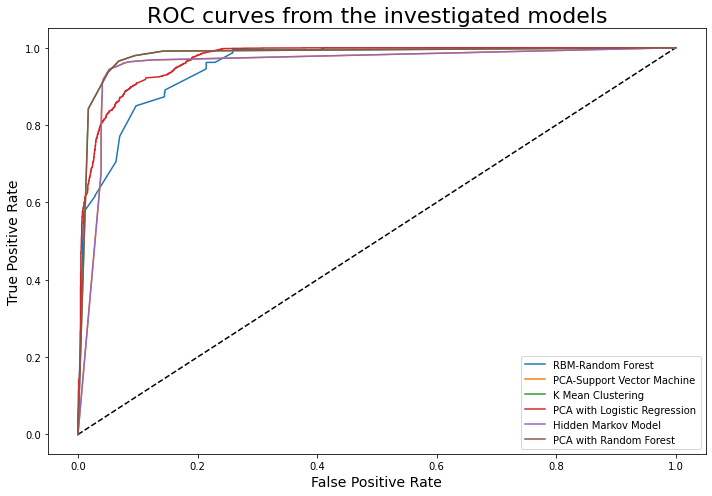

In [ ]:
ticks = ['RBM-Random Forest','PCA-Support Vector Machine','K Mean Clustering', 'PCA with Logistic Regression','Hidden Markov Model','PCA with Random Forest']
# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label=ticks[0] % roc_auc_lr)
plt.plot(fpr_SVMrbf, tpr_SVMrbf, label=ticks[1] % roc_auc_SVMrbf)
plt.plot(fpr_SVMlinear, tpr_SVMlinear, label=ticks[2] % roc_auc_SVMlinear)
plt.plot(fpr_KNN, tpr_KNN, label=ticks[3] % roc_auc_KNN)
plt.plot(fpr_Tree, tpr_Tree, label=ticks[4] % roc_auc_Tree)
plt.plot(fpr_rf, tpr_rf, label=ticks[5] % roc_auc_rf)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC curves from the investigated models', fontsize = 22)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NetworkTrafficData/Results/Correlation Matrix Selected Features/comparisonrocgraph.png')
plt.show()